# clustering phase models

Here, you specifically ask the question: *__how do different odors and visuospatial inputs recruit inhibitory interneurons__*, where recruitment corresponds to spike phase relationships with respect to four different rhythmic frequency bands. Note: because you are only considering correct trials, this will mean that a given odor also correlates perfectly with a given side of the maze in Lara's recording room in the Eichenbaum lab. For this reason, it may be the case that what is really driving differences in recruitment is the side of the maze that the rat finds itself in. 

In [1]:
%reset

import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import seaborn as sns

import kde_spikephase as kd

from mdl_eval_tools import bayes, kl
from rayleigh_pr import rayleigh_pr
import re
from scipy import stats
from scipy.signal import hilbert, find_peaks
from tqdm.notebook import tqdm

sns.set(font_scale=2,style='whitegrid') 
pd.set_option('max_colwidth',100)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [171]:
def get_neuron_cols(df,neuron_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes"""
    
    pattern = re.compile(neuron_expression)
    neuron_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            neuron_cols.append(matched.string)
    
    return neuron_cols

def get_allowable_lfp_wires(neuron_id,split_on):
    """neuron_id: string, e.g. TETSPK53b
    split_on: string, e.g. 'K', you will use this to exclude the unit letter from neuron_id"""

    #figure out who is the corresponding LFP for this neuron, must be on same tetrode!
    unit_wirenum = neuron.split(split_on)[1]
    unit_wirenum = unit_wirenum[:-1]
    if len(unit_wirenum) > 2:
        unit_wirenum = unit_wirenum[:2]
    allow_wire = [int(unit_wirenum), int(unit_wirenum) + 1, int(unit_wirenum) + 2, int(unit_wirenum) + 3]
    allow_wire = [str(w) for w in allow_wire]
    allow_wire = ['0'+w if int(w)<10 else w for w in allow_wire]
    
    return allow_wire

def get_lfp_cols(df,lfp_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes
    lfp_expression: string, e.g."""
#example lfp_expression =  "TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z"
        
    pattern = re.compile(lfp_expression)
    lfp_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            lfp_cols.append(matched.string)

    return lfp_cols


def example_cells_by_side_of_maze(cell_id,kde_odor,cluster_id_df,datapath,ymax,centered,savefig):
    
    example_cell_model = kde_odor[(kde_odor['cell_id'] == cell_id)]
    example_cell_clust = cluster_id_df[cluster_id_df['cell_id']==cell_id]
    
    file = cell_id.split('_')[0] + '_' + cell_id.split('_')[1] + '_correct.csv'
    example_cell_data = pd.read_csv(os.path.join(datapath,file))

    neuron = cell_id.split('_')[2]
    
    #find out which positions each odor in example_cell_clust occurs in
    condition_labels = list(set(example_cell_clust['condition_labels']))
    odor_side = []
    for condition in condition_labels: 

        which_pos = list(set(example_cell_data[example_cell_data['odor_labels']==condition]['pos_labels']))

        if which_pos == [1,2]: 

            side = 'left'

        elif which_pos == [3,4]: 

            side = 'right'

        dct = {'condition_labels': condition,
               'pos': which_pos,
               'side_of_maze': side
              }
        odor_side.append(pd.DataFrame(dct))

    odor_side_df = pd.concat(odor_side)
    
    example_cell_clust = example_cell_clust.merge(odor_side_df,on='condition_labels')
    
    rhythms = ['theta','beta','lowgamma','highgamma']

    sides = list(set(odor_side_df['side_of_maze']))

    fig,ax=plt.subplots(1,4,figsize=(20,5))

    counter = 0
    for side in sides: 

        if side == 'left':
            side_color = 'rosybrown'


        elif side == 'right': 
            side_color = 'steelblue'



        subside = example_cell_clust[example_cell_clust['side_of_maze']==side]

        conditions = list(set(subside['condition_labels']))

        for condition in conditions: 

            for rhythm in rhythms:

                subc = example_cell_model[(example_cell_model['condition_labels']==condition)&(example_cell_model['rhythm']==rhythm)]
                clust_data = subside[subside['condition_labels']==condition]
                inds = list(set(clust_data['spktrn_ind_labels']))

                if centered:
                    
                    if rhythm == 'theta':

                        varname = theta_kde_cent_odor

                    elif rhythm == 'beta':

                        varname = beta_kde_cent_odor

                    elif rhythm == 'lowgamma': 

                        varname = lowgamma_kde_cent_odor

                    elif rhythm == 'highgamma': 

                        varname = highgamma_kde_cent_odor
                        
                    if counter < 4:
                        ax[counter].plot(x,varname[inds,:].T,color=side_color,linewidth=6,alpha=0.7);
                        ax[counter].set_title(rhythm)
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= 4:

                        counter = 0 #reset the counter
                        
                else:
                    
                    if counter < 4:
                        ax[counter].plot(x,subc['kde_spikeprob'].values,color=side_color,linewidth=6,alpha=0.7);
                        ax[counter].set_title(rhythm)
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= 4:

                        counter = 0 #reset the counter
           

    if centered: 
        for a in ax:
            a.set_ylim(-ymax,ymax)
            
    else: 
        for a in ax:
            a.set_ylim(0,ymax)

    fig.tight_layout()
    
    if savefig: 
        
        fig.savefig('figures_odor/example_cell_'+cell_id+'_coloredby_odor_side_of_maze.pdf')



    return 



def example_cells_by_odor(cell_id,kde_odor,cluster_id_df,ymax,centered):
    
    example_cell_model = kde_odor[(kde_odor['cell_id'] == cell_id)]
    example_cell_clust = cluster_id_df[cluster_id_df['cell_id']==cell_id]

    file = cell_id.split('_')[0] + '_' + cell_id.split('_')[1] + '_correct.csv'
    example_cell_data = pd.read_csv(os.path.join(datapath,file))

    neuron = cell_id.split('_')[2]

    #find out which positions each odor in example_cell_clust occurs in
    condition_labels = list(set(example_cell_clust['condition_labels']))
    odor_side = []
    for condition in condition_labels: 

        which_pos = list(set(example_cell_data[example_cell_data['odor_labels']==condition]['pos_labels']))

        if which_pos == [1,2]: 

            side = 'left'

        elif which_pos == [3,4]: 

            side = 'right'

        dct = {'condition_labels': condition,
               'pos': which_pos,
               'side_of_maze': side
              }
        odor_side.append(pd.DataFrame(dct))

    odor_side_df = pd.concat(odor_side)

    example_cell_clust = example_cell_clust.merge(odor_side_df,on='condition_labels')

    rhythms = ['theta','lowgamma','highgamma']

    sides = list(set(odor_side_df['side_of_maze']))

    fig,ax=plt.subplots(1,3,figsize=(20,5))

    counter = 0
    for side in sides: 

        if side == 'left':
            side_colors = ['firebrick','rosybrown','red','lightcoral']


        elif side == 'right': 
            side_colors = ['steelblue','lightsteelblue','dodgerblue','lightskyblue']


        subside = example_cell_clust[example_cell_clust['side_of_maze']==side]

        conditions = list(set(subside['condition_labels']))

        for cind,condition in enumerate(conditions): 

            for rhythm in rhythms:

                subc = example_cell_model[(example_cell_model['condition_labels']==condition)&(example_cell_model['rhythm']==rhythm)]
                clust_data = subside[subside['condition_labels']==condition]
                inds = list(set(clust_data['spktrn_ind_labels']))

                if centered:

                    if rhythm == 'theta':

                        varname = theta_kde_cent_odor

                    elif rhythm == 'lowgamma': 

                        varname = lowgamma_kde_cent_odor

                    elif rhythm == 'highgamma': 

                        varname = highgamma_kde_cent_odor

                    if counter < len(rhythms):

                        if cind >= len(side_colors): 

                            cind = cind - len(side_colors)

                        ax[counter].plot(x,varname[inds,:].T,color=side_colors[cind],linewidth=6,alpha=0.7,label=str(condition));
                        ax[counter].set_title(rhythm)
                        
                        #plot the idealized cycle
                        dom = np.linspace(-np.pi,np.pi,1000)
                        ax[counter].plot(dom,(ymax/2)+(ymax/2)*np.cos(dom),color='grey',alpha=0.3,linewidth=4)
                        
                        
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= len(side_colors):

                        counter = 0 #reset the counter


                else:

                    if counter < len(rhythms):

                        if cind >= len(side_colors): 

                            cind = cind - len(side_colors)

                        ax[counter].plot(x,subc['kde_spikeprob'].values,color=side_colors[cind],linewidth=6,alpha=0.7,label=str(condition));
                        ax[counter].set_title(rhythm)
                        
                        #plot the idealized cycle
                        dom = np.linspace(-np.pi,np.pi,1000)
                        ax[counter].plot(dom,(ymax/2)+(ymax/2)*np.cos(dom),color='grey',alpha=0.3,linewidth=4)
                        
                        ax[0].set_ylabel(cell_id)


                        counter += 1

                    if counter >= len(rhythms):

                        counter = 0 #reset the counter


    if centered: 
        for a in ax:
            a.set_ylim(-ymax,ymax)
            

    else: 
        for a in ax:
            a.set_ylim(0,ymax)
            
    fig.legend()
    fig.tight_layout()
    

    return fig



def compute_circmean(phi_when_sp):
    
    #get cosine of all phase angles that coincide with spikes
    tmpcos = [np.cos(i) for i in phi_when_sp]
    #get sine of all phase angles that coincide with spikes
    tmpsin = [np.sin(i) for i in phi_when_sp]

    #take the average cosine component (x)
    meancos = np.mean(tmpcos)
    #take the average sine component (y)
    meansin = np.mean(tmpsin)

    #get the hypotenuse of the mean sin and cosine components
    mrl = np.sqrt(meancos**2 + meansin**2)

    #compute circular mean
    circmean = np.arctan2(meansin,meancos)
    
    return circmean

def label_phase_cycles(df, filtcol, fs, lfp_trial_ind):
    """This function specifically: finds troughs in the phase time Series, 
    and adds the trough-based cycle labels to the available dataframe 
    df: dataframe, need to make sure that if this is a subset of another DataFrame
    you pass in the subdf.reset_index() version, so that the cycle labels can be
    assigned for the corresponding indices"""
    
   # find the troughs
    troughs, _ = find_peaks(df[filtcol],
                            height=None,
                            threshold=None,
                            distance=None,
                            prominence=None,
                            width=None,
                            wlen=None,
                            rel_height=0.5,
                            plateau_size=None)

    cycle_bin_edges = np.hstack((0,troughs[0],troughs[1:],df.shape[0]))

    ncycles = len(troughs)+1
    cycle_labels = np.arange(0,ncycles)

    df = df.reset_index()
    df['cycle_labels'] = pd.cut(df.index,
                                bins=cycle_bin_edges,
                                labels=cycle_labels,
                                include_lowest=True
                                     )

    return df

### load the fit models
which you set up in notebook `final_fit_kde_models.ipynb`

In [3]:
modelpath = 'kde_models_ints_odorsamp/'
files = os.listdir(modelpath)
files = [f for f in files if not f.startswith('.')]
files = sorted(files)

#first, put all the kde dfs together
kde_odor = []
for file in files: 
    
    model_df = pd.read_csv(os.path.join(modelpath,file))
    
    kde_odor.append(model_df)
    
kde_odor = pd.concat(kde_odor)

Take a look at the models by rhythm.

  0%|          | 0/30 [00:00<?, ?it/s]

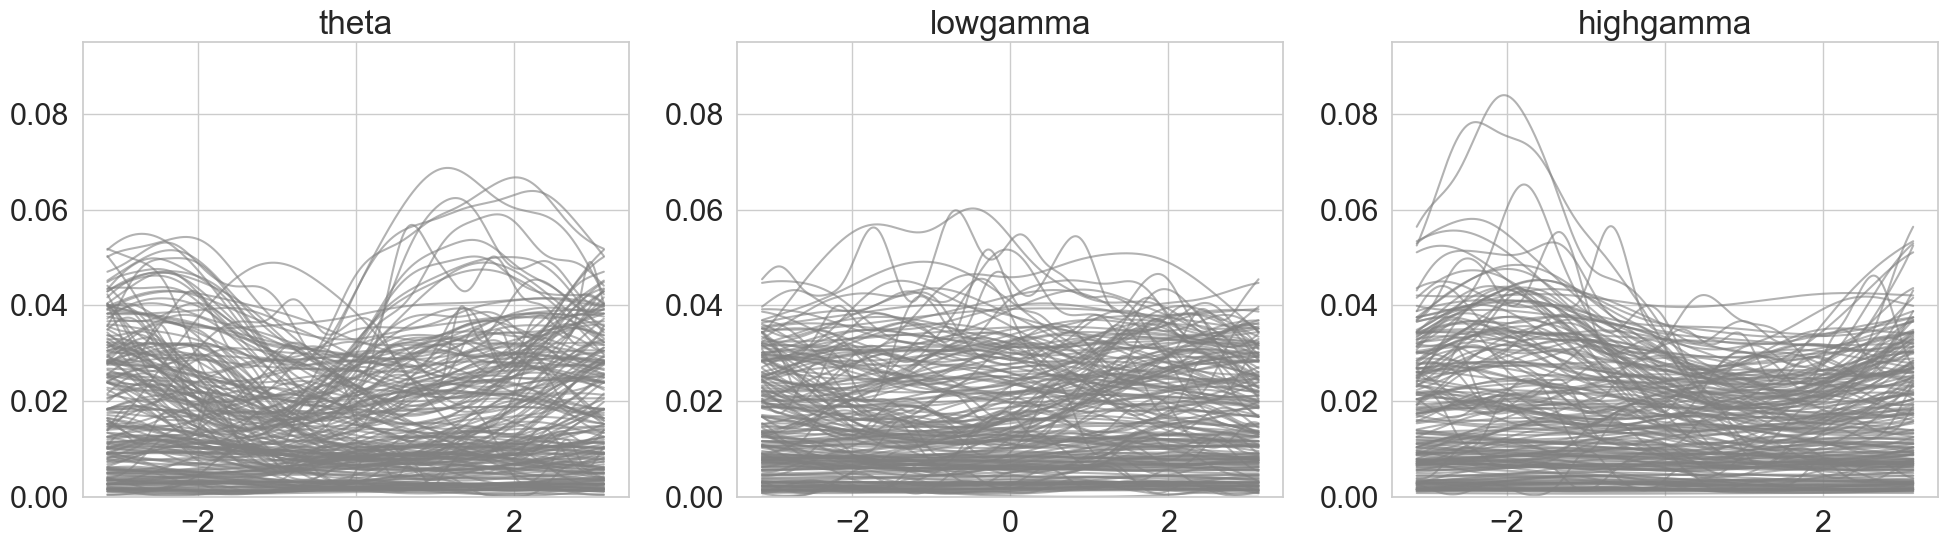

In [4]:
cell_labels_odor = list(set(kde_odor['cell_id'].tolist()))
rhythm_labels = ['theta','lowgamma','highgamma']
x = np.linspace(-np.pi,np.pi,1000)

fig,ax=plt.subplots(1,3,figsize=(20,6))

for cell_odor in tqdm(cell_labels_odor):  
    
    subcell_odor = kde_odor[kde_odor['cell_id'] == cell_odor]
    quarter_labels = list(set(subcell_odor['quarter_labels'].tolist()))
    
    for q in quarter_labels:
   
        subq = subcell_odor[subcell_odor['quarter_labels'] == q]
        condition_labels = list(set(subq['condition_labels']))
    
        for condition in condition_labels: 
            
            subc = subq[subq['condition_labels']==condition]
            
            for i,rhythm in enumerate(rhythm_labels):

                subrh_odor = subc[subc['rhythm'] == rhythm]
                ax[i].plot(x,subrh_odor['kde_spikeprob'].values,color='grey',alpha=0.6)
                ax[i].set_title(rhythm)

for ax in ax.flatten():
    ax.set_ylim(0, .095)

        
fig.tight_layout()

### generate a unique identifier for each odor-context spike train

In [5]:
#generate unique identifier for each odor's spike train (e.g. each neuron at most gets 8 different
#numbers)
cell_labels_odor = list(set(kde_odor['cell_id'].tolist()))
counter = 0
gather_dfs = []
for cell in cell_labels_odor:
    
    subcell_odor = kde_odor[kde_odor['cell_id'] == cell]
    quarter_labels = list(set(subcell_odor['quarter_labels'].tolist()))
    for q in quarter_labels:
        subq = subcell_odor[subcell_odor['quarter_labels'] == q]
        
        condition_labels = list(set(subq['condition_labels']))
        
        for condition in condition_labels: 
            subc = subq[subq['condition_labels']==condition]
            
            spktrn_ind_labels = np.repeat(counter,subc.shape[0])
            subc['spktrn_ind_labels'] = spktrn_ind_labels[0]

            gather_dfs.append(subc)
            counter += 1

kde_odor = pd.concat(gather_dfs)

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subc['spktrn_ind_labels'] = spktrn_ind_labels[0]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1542130006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [6]:
n_spktrns = kde_odor['spktrn_ind_labels'].max() + 1 #remember 0 indexing, this is just the largest
                                                #label, later, you will add 1 to get the actual
                                                #number of spike trains included!
        
print('number of spike trains: ',n_spktrns)

number of spike trains:  206


###### center phase models
To visually compare across models, you will center the phase models according to each curve's own mean probability of spiking. 

In [7]:
### ODORSAMPLING 
# here is where you center each kde curve according to its own mean
x = np.linspace(-np.pi,np.pi,1000)

theta_kde_odor = np.zeros((n_spktrns+1,len(x)))
lowgamma_kde_odor = np.zeros((n_spktrns+1,len(x)))
highgamma_kde_odor = np.zeros((n_spktrns+1,len(x)))

theta_kde_cent_odor = np.zeros((n_spktrns+1,len(x)))
lowgamma_kde_cent_odor = np.zeros((n_spktrns+1,len(x)))
highgamma_kde_cent_odor = np.zeros((n_spktrns+1,len(x)))

spktrn_index_labels = list(set(kde_odor['spktrn_ind_labels'].to_list()))
for index in tqdm(spktrn_index_labels):
    
    for rhythm in rhythm_labels:
        
        subcellrh = kde_odor[(kde_odor['rhythm'] == rhythm) & (kde_odor['spktrn_ind_labels'] == index)]
        
        if rhythm=='theta':
            
            theta_kde_odor[index] = subcellrh['kde_spikeprob'].values
            theta_kde_cent_odor[index] = theta_kde_odor[index] - theta_kde_odor[index].mean()
            
        if rhythm=='lowgamma':
            
            lowgamma_kde_odor[index] = subcellrh['kde_spikeprob'].values
            lowgamma_kde_cent_odor[index] = lowgamma_kde_odor[index] - lowgamma_kde_odor[index].mean()
            
        if rhythm=='highgamma':    
            
            highgamma_kde_odor[index] = subcellrh['kde_spikeprob'].values
            highgamma_kde_cent_odor[index] = highgamma_kde_odor[index] - highgamma_kde_odor[index].mean()
            
            
        

  0%|          | 0/206 [00:00<?, ?it/s]

### compute the sum kld and Rayleigh statistics
On the raw (non-centered models).

In [8]:
n_splits = 7 #corresponds to the number of CV folds used to find the optimal 
             #kernel bandwidth for fitting. this is also the minimal number of spikes
             #that a neuron had to have in an odor-context spike train to be able to fit 
             #the kde models using 7-fold CV
rhythms = ['theta','lowgamma','highgamma']

datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = sorted(files)

sumkld_df = [] #initialize the df that will contain all the files' data
for file in tqdm(files, position=0, desc="file", leave=True, colour='cornflowerblue'): 
 
    df = pd.read_csv(os.path.join(datapath,file))
    odorsamp_df = df[df['trial_segment']=='dur']

    df = [] #clear out to save memory

    quarters = list(set(odorsamp_df['quarter_labels']))

    for quarter in tqdm(quarters,position=1,desc='quarter',leave=False,colour='lavender'): 
    
        subq = odorsamp_df[odorsamp_df['quarter_labels']==quarter]

        if np.all(subq['accuracy'] >= .75):
            
            neuron_cols = get_neuron_cols(subq,'TETSPK')
            
            for rhythm in tqdm(rhythms,position=2,desc='rhythm',leave=False,colour='hotpink'): 

                for neuron in tqdm(neuron_cols,position=3,desc='neuron',leave=False,colour='mediumturquoise'): 

                    cell_id = file.split('_')[0] + '_' + file.split('_')[1] + '_' + neuron

                    allow_wire = get_allowable_lfp_wires(neuron,'K')

                    #grab the lfps
                    lfp_cols = get_lfp_cols(subq,"TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z")
                    lfp_name = lfp_cols[0]

                    #create the phase columns using the hilbert transform on the filtered lfp
                    filt_name = lfp_name + 'filt_' + rhythm 

                    filtered = subq[filt_name]
                    analytic_signal = hilbert(filtered)

                    phase_name = lfp_name + 'phase_' + rhythm 
                    subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);

                    #get the unique odor position identifiers for each condition
                    condition_labels = subq.groupby(['odor_labels']).sum().index
                    
                    for condition in condition_labels:

                        #need to filter the dataset by condition now
                        odor = condition
   
                        d = subq[(subq['odor_labels']==odor)]

                        #now, grab the spikes and phases to fit the kde curves
                        #grab data
                        spikes = d[neuron].values
                        phases = d[phase_name].values

                        phi_when_sp = []
                        for s,p in zip(spikes,phases):
                            if s==1: 
                                phi_when_sp.append(p)

                        phi_when_sp = np.array(phi_when_sp)
                        
                        df_for_ray = pd.DataFrame() #initialize dataframe for the rayleigh code

                        #CRITERION: number of spikes must exceed the number of cross val splits for fitting kde
                        if n_splits < sum(spikes):
                            
                            subcellrh = kde_odor[(kde_odor['cell_id']==cell_id) & (kde_odor['rhythm']==rhythm) & (kde_odor['condition_labels']==odor)]

                            # compute the kld(phase model || uniform spiking) per cell, per rhythm
                            avgspk = d[neuron].sum()/d.shape[0]
                            uni_pspk = np.repeat(avgspk,subcellrh.shape[0])

                            df_for_ray['spikes'] = spikes
                            df_for_ray[rhythm+'_phases'] = phases
                            ray = rayleigh_pr(df_for_ray, rhythm)

                            sumkl = np.sum(kl(subcellrh['kde_spikeprob'].values,uni_pspk))
                            sumkld = {'cell_id': cell_id,
                                      'quarter_labels': quarter,
                                      'condition_labels': odor,
                                      'sumkld': sumkl,
                                      'ray_mrl': ray['mrl'].values,
                                      'ray_pval': ray['pval'].values,
                                      'ray_circmean': ray['circmean'].values,
                                      'frate': avgspk*1000,
                                      'rhythm': rhythm,
                                      'spktrn_ind_labels': subcellrh['spktrn_ind_labels'].iloc[0]
                                          }

                            sumkld_df.append(pd.DataFrame(sumkld))

sumkld_df = pd.concat(sumkld_df)


file:   0%|          | 0/18 [00:00<?, ?it/s]

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be s

quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


quarter:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


rhythm:   0%|          | 0/3 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/1540771621.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered);


## cluster the odor-context spike trains
according to their spike phase relationships

##### set up clustering parameters

In [9]:
alpha = 0.05 #p < alpha for Rayleigh statistical significance

sumkld_df['significant'] = [1 if (i < alpha) else 0 for i in sumkld_df['ray_pval'].values]

Each rhythm gets its own phase boundaries. 

In [10]:
#theta
phase_thresh_midleft_T = -2
phase_thresh_midright_T = 0
phase_thresh_farright_T = 2.85

subtheta_sig = sumkld_df[(sumkld_df['rhythm'] == 'theta') & (sumkld_df['significant'] == 1)]
subtheta_nosig = sumkld_df[(sumkld_df['rhythm'] == 'theta') & (sumkld_df['significant'] == 0)]

cluster0a = subtheta_sig[(subtheta_sig['ray_circmean'] <= phase_thresh_midleft_T)].reset_index()
cluster0b = subtheta_sig[(subtheta_sig['ray_circmean'] > phase_thresh_farright_T)].reset_index()
cluster0 = pd.concat([cluster0a,cluster0b])

cluster1 = subtheta_sig[(subtheta_sig['ray_circmean'] > phase_thresh_midleft_T) & (subtheta_sig['ray_circmean'] <= phase_thresh_midright_T)].reset_index()

cluster2 = subtheta_sig[(subtheta_sig['ray_circmean'] > phase_thresh_midright_T) & (subtheta_sig['ray_circmean'] <= phase_thresh_farright_T)].reset_index()

cluster3 = subtheta_nosig.reset_index()

cluster0['theta_clust_id'] = np.repeat(0,cluster0.shape[0])
cluster1['theta_clust_id'] = np.repeat(1,cluster1.shape[0])
cluster2['theta_clust_id'] = np.repeat(2,cluster2.shape[0])
cluster3['theta_clust_id'] = np.repeat(3,cluster3.shape[0])

theta_cluster_id_df = pd.concat([cluster0,cluster1,cluster2,cluster3])

#lowgamma

sublowgamma_sig = sumkld_df[(sumkld_df['rhythm'] == 'lowgamma') & (sumkld_df['significant'] == 1)]
sublowgamma_nosig = sumkld_df[(sumkld_df['rhythm'] == 'lowgamma') & (sumkld_df['significant'] == 0)]

phase_thresh_farleft_LG = -2
phase_thresh_mid_LG = 0.25
phase_thresh_farright_LG = 1.25

cluster0 = sublowgamma_sig[(sublowgamma_sig['ray_circmean'] > phase_thresh_farleft_LG)&(sublowgamma_sig['ray_circmean'] <= phase_thresh_mid_LG)].reset_index()

cluster1 = sublowgamma_sig[(sublowgamma_sig['ray_circmean'] > phase_thresh_mid_LG) & (sublowgamma_sig['ray_circmean'] <= phase_thresh_farright_LG)].reset_index()

cluster2a = sublowgamma_sig[(sublowgamma_sig['ray_circmean'] > phase_thresh_farright_LG)].reset_index()
cluster2b = sublowgamma_sig[(sublowgamma_sig['ray_circmean'] <= phase_thresh_farleft_LG)].reset_index()
cluster2 = pd.concat([cluster2a,cluster2b])

cluster3 = sublowgamma_nosig.reset_index()

cluster0['lowgamma_clust_id'] = np.repeat(0,cluster0.shape[0])
cluster1['lowgamma_clust_id'] = np.repeat(1,cluster1.shape[0])
cluster2['lowgamma_clust_id'] = np.repeat(2,cluster2.shape[0])
cluster3['lowgamma_clust_id'] = np.repeat(3,cluster3.shape[0])

lowgamma_cluster_id_df = pd.concat([cluster0,cluster1,cluster2,cluster3])


#highgamma

subhighgamma_sig = sumkld_df[(sumkld_df['rhythm'] == 'highgamma') & (sumkld_df['significant'] == 1)]
subhighgamma_nosig = sumkld_df[(sumkld_df['rhythm'] == 'highgamma') & (sumkld_df['significant'] == 0)]

phase_thresh_mid_HG = 0


cluster0 = subhighgamma_sig[(subhighgamma_sig['ray_circmean'] <= phase_thresh_mid_HG)].reset_index()

cluster1 = subhighgamma_sig[(subhighgamma_sig['ray_circmean'] > phase_thresh_mid_HG)].reset_index()

cluster2 = subhighgamma_nosig.reset_index()

cluster0['highgamma_clust_id'] = np.repeat(0,cluster0.shape[0])
cluster1['highgamma_clust_id'] = np.repeat(1,cluster1.shape[0])
cluster2['highgamma_clust_id'] = np.repeat(2,cluster2.shape[0])

highgamma_cluster_id_df = pd.concat([cluster0,cluster1,cluster2])


Now merge the dataframes containing cluster identity information for each rhythm

In [11]:
cluster_id_df = theta_cluster_id_df.merge(highgamma_cluster_id_df,on=['cell_id','quarter_labels','condition_labels','spktrn_ind_labels'],suffixes=('_theta','_highgamma'))
cluster_id_df = cluster_id_df.merge(lowgamma_cluster_id_df,on=['cell_id','quarter_labels','condition_labels','spktrn_ind_labels'],suffixes=('_theta','_highgamma','_lowgamma'))



In [161]:
reduced_clust_id_df = cluster_id_df[['cell_id',
                                     'condition_labels',
                                     'spktrn_ind_labels',
                                     'theta_clust_id',
                                     'lowgamma_clust_id',
                                     'highgamma_clust_id'
                                    ]]

# save this reduced_clust_id_df for analyses in different notebooks
reduced_clust_id_df.to_csv('cluster_ids_theta_lowgamma_highgamma.csv')

### Figure 2A

theta centroids: 
 centroid 0:  -2.653779692966787 
 centroid 1:  -0.9516136776889718 
 centroid 2:  1.7400348393108755
lowgamma centroids: 
 centroid 0:  -0.7526842981201395 
 centroid 1:  0.7700105311470274 
 centroid 2:  2.3058927602778483
highgamma centroids: 
 centroid 0:  -1.728782905659412 
 centroid 1:  2.1282576570150926


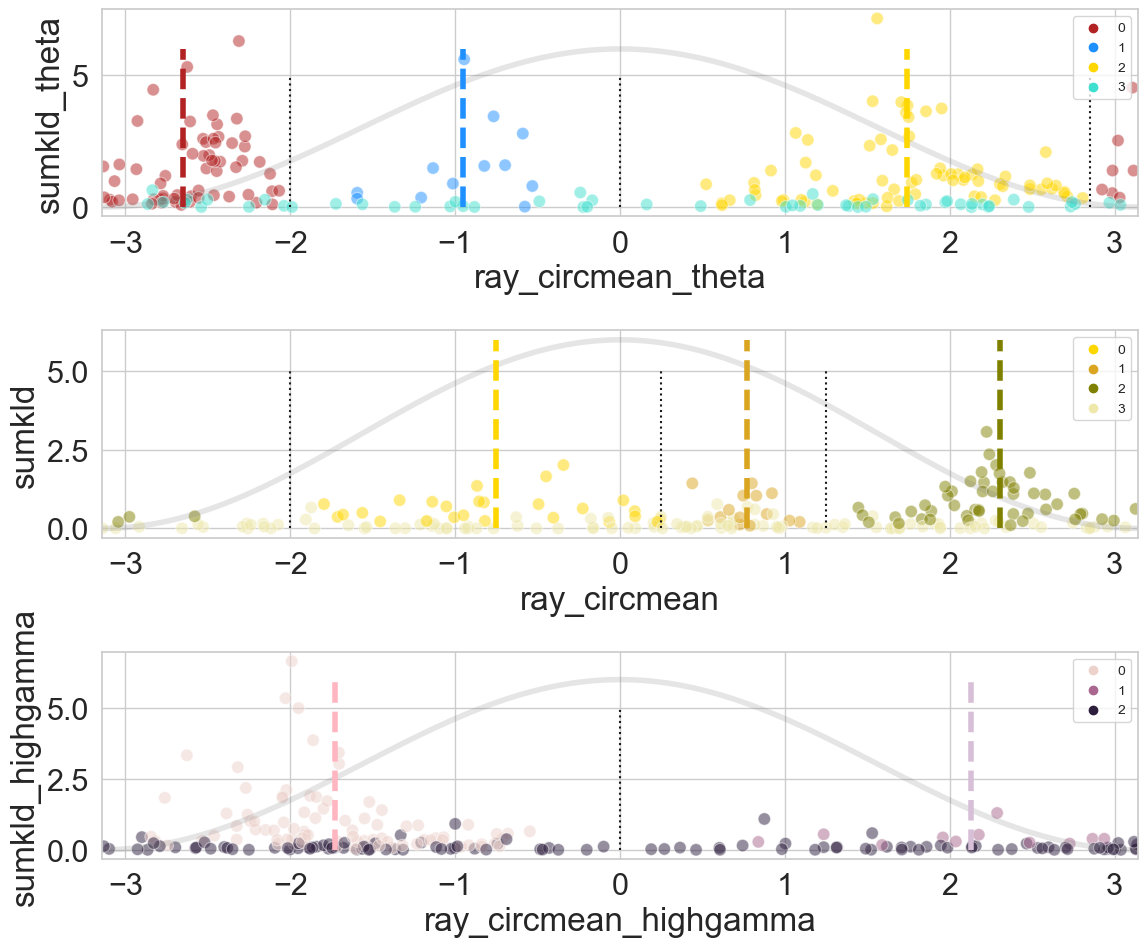

In [162]:
fig,ax=plt.subplots(3,1,figsize=(12,10))

domain = -np.linspace(-np.pi,np.pi,1000)

#theta 

sns.scatterplot(data=cluster_id_df,
                x='ray_circmean_theta',
                y='sumkld_theta',
                hue='theta_clust_id',
                palette=['firebrick','dodgerblue','gold','turquoise'],
                alpha=0.5,
                s=80,
                ax=ax[0]
               )

ax[0].plot(domain,3*(1+np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

circmeans0 = cluster_id_df[cluster_id_df['theta_clust_id']==0]['ray_circmean_theta']
mean0 = compute_circmean(circmeans0)
ax[0].vlines(x=mean0,ymin=0,ymax=6,color='firebrick',linestyle='--',linewidth=4)

circmeans1 = cluster_id_df[cluster_id_df['theta_clust_id']==1]['ray_circmean_theta']
mean1 = compute_circmean(circmeans1)
ax[0].vlines(x=mean1,ymin=0,ymax=6,color='dodgerblue',linestyle='--',linewidth=4)

circmeans2 = cluster_id_df[cluster_id_df['theta_clust_id']==2]['ray_circmean_theta']
mean2 = compute_circmean(circmeans2)
ax[0].vlines(x=mean2,ymin=0,ymax=6,color='gold',linestyle='--',linewidth=4)

print('theta centroids: \n',
      'centroid 0: ', mean0,'\n',
      'centroid 1: ', mean1,'\n',
      'centroid 2: ', mean2
     )

ax[0].set_xlim(-np.pi,np.pi)
ax[0].legend(fontsize=10)

#lowgamma 

sns.scatterplot(data=cluster_id_df,
                x='ray_circmean',
                y='sumkld',
                hue='lowgamma_clust_id',
                palette=['gold','goldenrod','olive','palegoldenrod'],
                alpha=0.5,
                s=80,
                ax=ax[1]
               )

ax[1].plot(domain,3*(1+np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

circmeans0 = cluster_id_df[cluster_id_df['lowgamma_clust_id']==0]['ray_circmean']
mean0 = compute_circmean(circmeans0)
ax[1].vlines(x=mean0,ymin=0,ymax=6,color='gold',linestyle='--',linewidth=4)

circmeans1 = cluster_id_df[cluster_id_df['lowgamma_clust_id']==1]['ray_circmean']
mean1 = compute_circmean(circmeans1)
ax[1].vlines(x=mean1,ymin=0,ymax=6,color='goldenrod',linestyle='--',linewidth=4)

circmeans2 = cluster_id_df[cluster_id_df['lowgamma_clust_id']==2]['ray_circmean']
mean2 = compute_circmean(circmeans2)
ax[1].vlines(x=mean2,ymin=0,ymax=6,color='olive',linestyle='--',linewidth=4)


ax[1].set_xlim(-np.pi,np.pi)
ax[1].legend(fontsize=10)

print('lowgamma centroids: \n',
      'centroid 0: ', mean0,'\n',
      'centroid 1: ', mean1,'\n',
      'centroid 2: ', mean2
     )

#highgamma

sns.scatterplot(data=cluster_id_df,
                x='ray_circmean_highgamma',
                y='sumkld_highgamma',
                hue='highgamma_clust_id',
                alpha=0.5,
                s=80,
                ax=ax[2]
               )

ax[2].plot(domain,3*(1+np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

circmeans0 = cluster_id_df[cluster_id_df['highgamma_clust_id']==0]['ray_circmean_highgamma']
mean0 = compute_circmean(circmeans0)
ax[2].vlines(x=mean0,ymin=0,ymax=6,color='lightpink',linestyle='--',linewidth=4)

circmeans1 = cluster_id_df[cluster_id_df['highgamma_clust_id']==1]['ray_circmean_highgamma']
mean1 = compute_circmean(circmeans1)
ax[2].vlines(x=mean1,ymin=0,ymax=6,color='thistle',linestyle='--',linewidth=4)


ax[2].set_xlim(-np.pi,np.pi)
ax[2].legend(fontsize=10)

print('highgamma centroids: \n',
      'centroid 0: ', mean0,'\n',
      'centroid 1: ', mean1)


ax[0].vlines(x=phase_thresh_farright_T,ymin=0,ymax=5,color='k',linestyle='dotted')
ax[0].vlines(x=phase_thresh_midleft_T,ymin=0,ymax=5,color='k',linestyle='dotted')
ax[0].vlines(x=phase_thresh_midright_T,ymin=0,ymax=5,color='k',linestyle='dotted')

ax[1].vlines(x=phase_thresh_farleft_LG,ymin=0,ymax=5,color='k',linestyle='dotted')
ax[1].vlines(x=phase_thresh_mid_LG,ymin=0,ymax=5,color='k',linestyle='dotted')
ax[1].vlines(x=phase_thresh_farright_LG,ymin=0,ymax=5,color='k',linestyle='dotted')

ax[2].vlines(x=phase_thresh_mid_HG,ymin=0,ymax=5,color='k',linestyle='dotted')

fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'sumkld_clusters_odorsamp.pdf'))

#### find the location of centroids for each cluster 
ignoring the uniform cluster

__theta__

In [163]:
circmeans0 = cluster_id_df[cluster_id_df['theta_clust_id']==0]['ray_circmean_theta']
mean0 = compute_circmean(circmeans0)
circmeans1 = cluster_id_df[cluster_id_df['theta_clust_id']==1]['ray_circmean_theta']
mean1 = compute_circmean(circmeans1)
circmeans2 = cluster_id_df[cluster_id_df['theta_clust_id']==2]['ray_circmean_theta']
mean2 = compute_circmean(circmeans2)

print(mean0, mean1, mean2)

-2.653779692966787 -0.9516136776889718 1.7400348393108755


### Figure 2B (top row)
Visualize the mean-centered phase models

In [164]:
sns.set(style='whitegrid',font_scale=1.1)

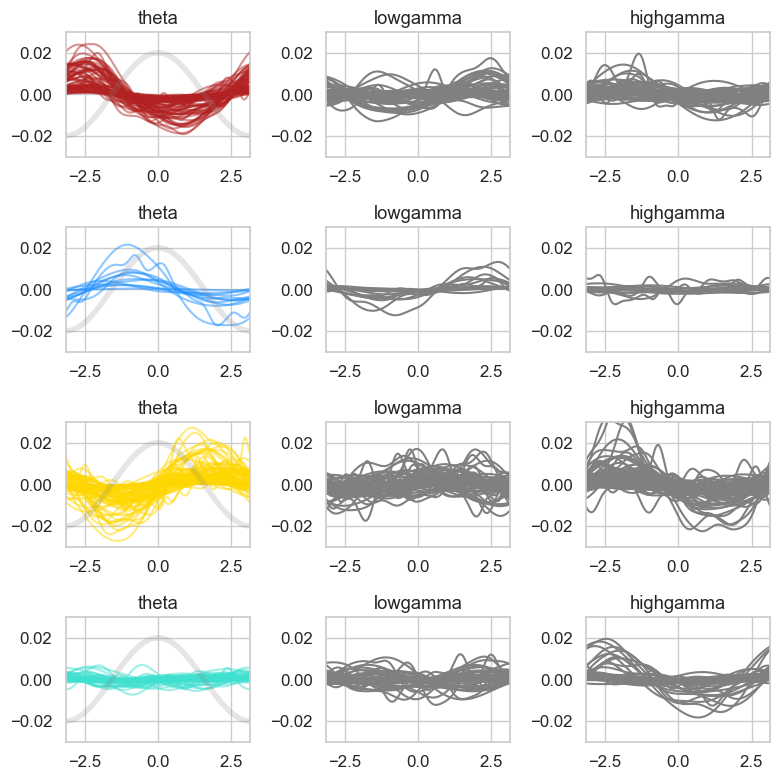

In [166]:
fig,ax=plt.subplots(4,3,figsize=(8,8))

## CLUST 0
rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 0]
inds = subclust['spktrn_ind_labels'].values
ax[0][0].plot(x,theta_kde_cent_odor[inds,:].T,color='firebrick',alpha=0.5);
ax[0][0].set_title('theta')

ax[0][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[0][1].set_title('lowgamma')

ax[0][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[0][2].set_title('highgamma')

ax[0][0].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


## CLUST 1

rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 1]
inds = subclust['spktrn_ind_labels'].values
ax[1][0].plot(x,theta_kde_cent_odor[inds,:].T,color='dodgerblue',alpha=0.5);
ax[1][0].set_title('theta')



ax[1][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[1][1].set_title('lowgamma')

ax[1][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[1][2].set_title('highgamma')

ax[1][0].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


#CLUST 2

rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 2]
inds = subclust['spktrn_ind_labels'].values
ax[2][0].plot(x,theta_kde_cent_odor[inds,:].T,color='gold',alpha=0.5);
ax[2][0].set_title('theta')



ax[2][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[2][1].set_title('lowgamma')

ax[2][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[2][2].set_title('highgamma')

ax[2][0].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


## CLUST 3
rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 3]
inds = subclust['spktrn_ind_labels'].values
ax[3][0].plot(x,theta_kde_cent_odor[inds,:].T,color='turquoise',alpha=0.5);
ax[3][0].set_title('theta')


ax[3][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[3][1].set_title('lowgamma')

ax[3][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[3][2].set_title('highgamma')

ax[3][0].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


    


for ax in ax.flatten():
    ax.set_ylim(-0.03, .03)
    ax.set_xlim(-np.pi,np.pi)
    
fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'centered_phase_models_by_clust_id_theta_odorsamp.pdf'))

##### find the fraction of spike trains per theta cluster

In [12]:
## CLUST 0
rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 0]
clust0_inds = subclust['spktrn_ind_labels'].values

clust0_number = len(clust0_inds)
clust0_fraction = len(clust0_inds)/n_spktrns

## CLUST 1
rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 1]
clust1_inds = subclust['spktrn_ind_labels'].values

clust1_number = len(clust1_inds)
clust1_fraction = len(clust1_inds)/n_spktrns

#CLUST 2

rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 2]
clust2_inds = subclust['spktrn_ind_labels'].values

clust2_number = len(clust2_inds)
clust2_fraction = len(clust2_inds)/n_spktrns

#CLUST 3

rhythm = 'theta'
subclust = cluster_id_df[cluster_id_df['theta_clust_id'] == 3]
clust3_inds = subclust['spktrn_ind_labels'].values

clust3_number = len(clust3_inds)
clust3_fraction = len(clust3_inds)/n_spktrns

print('clust0: ', clust0_fraction, 'n= ', clust0_number,
      '\nclust1: ', clust1_fraction, 'n= ', clust1_number,
      '\nclust2: ' , clust2_fraction,'n= ', clust2_number, 
      '\nclust3: ', clust3_fraction, 'n= ', clust3_number
     )

clust0:  0.3300970873786408 n=  68 
clust1:  0.05825242718446602 n=  12 
clust2:  0.3446601941747573 n=  71 
clust3:  0.2669902912621359 n=  55


### Figure 2B (middle row)

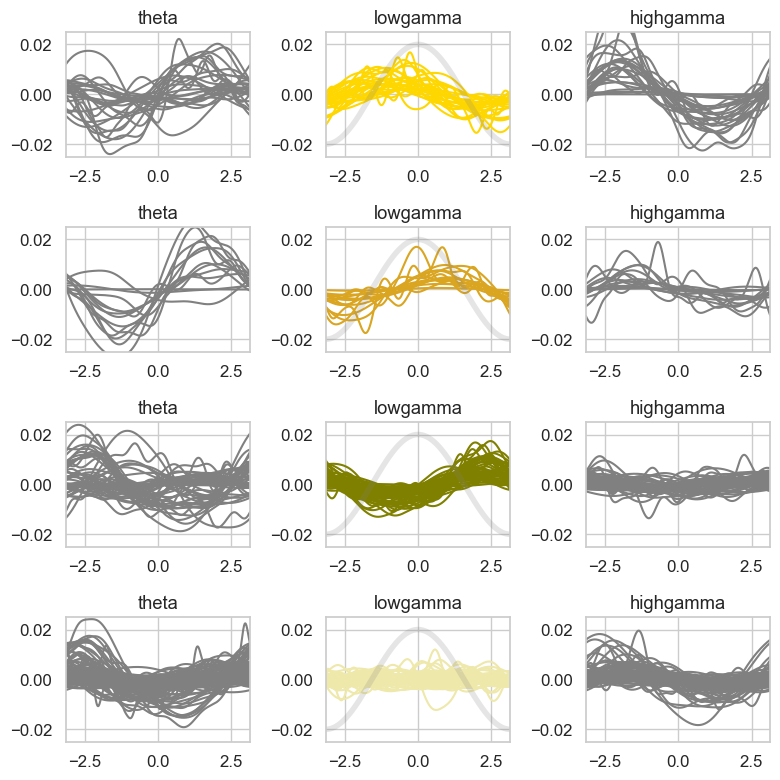

In [168]:
fig,ax=plt.subplots(4,3,figsize=(8,8))

## CLUST 0
rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 0]
inds = subclust['spktrn_ind_labels'].values
ax[0][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[0][0].set_title('theta')

ax[0][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='gold');
ax[0][1].set_title('lowgamma')

ax[0][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[0][2].set_title('highgamma')

ax[0][1].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


## CLUST 1

rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 1]
inds = subclust['spktrn_ind_labels'].values
ax[1][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[1][0].set_title('theta')

ax[1][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='goldenrod');
ax[1][1].set_title('lowgamma')

ax[1][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[1][2].set_title('highgamma')

ax[1][1].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


#CLUST 2

rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 2]
inds = subclust['spktrn_ind_labels'].values
ax[2][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[2][0].set_title('theta')

ax[2][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='olive');
ax[2][1].set_title('lowgamma')

ax[2][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[2][2].set_title('highgamma')

ax[2][1].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

## CLUST 3
rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 3]
inds = subclust['spktrn_ind_labels'].values
ax[3][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[3][0].set_title('theta')

ax[3][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='palegoldenrod');
ax[3][1].set_title('lowgamma')

ax[3][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='grey');
ax[3][2].set_title('highgamma')

ax[3][1].plot(domain,.02*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

    


for ax in ax.flatten():
    ax.set_ylim(-0.025, .025)
    ax.set_xlim(-np.pi,np.pi)
    
fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'centered_phase_models_by_clust_id_lowgamma_odorsamp.pdf'))

##### find the fraction of spike trains per low gamma cluster

In [13]:
## CLUST 0
rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 0]
inds = subclust['spktrn_ind_labels'].values

clust0_number = len(inds)
clust0_fraction = clust0_number/n_spktrns

## CLUST 1

rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 1]
inds = subclust['spktrn_ind_labels'].values

clust1_number = len(inds)
clust1_fraction = clust1_number/n_spktrns

#CLUST 2

rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 2]
inds = subclust['spktrn_ind_labels'].values

clust2_number = len(inds)
clust2_fraction = clust2_number/n_spktrns

## CLUST 3
rhythm = 'lowgamma'
subclust = cluster_id_df[cluster_id_df['lowgamma_clust_id'] == 3]
inds = subclust['spktrn_ind_labels'].values

clust3_number = len(inds)
clust3_fraction = clust3_number/n_spktrns

print('clust0: ', clust0_fraction, 'n= ', clust0_number,
      '\nclust1: ', clust1_fraction, 'n= ', clust1_number,
      '\nclust2: ' , clust2_fraction,'n= ', clust2_number, 
      '\nclust3: ', clust3_fraction, 'n= ', clust3_number
     )

clust0:  0.1262135922330097 n=  26 
clust1:  0.06796116504854369 n=  14 
clust2:  0.24757281553398058 n=  51 
clust3:  0.558252427184466 n=  115


### Figure 2B (bottom row)

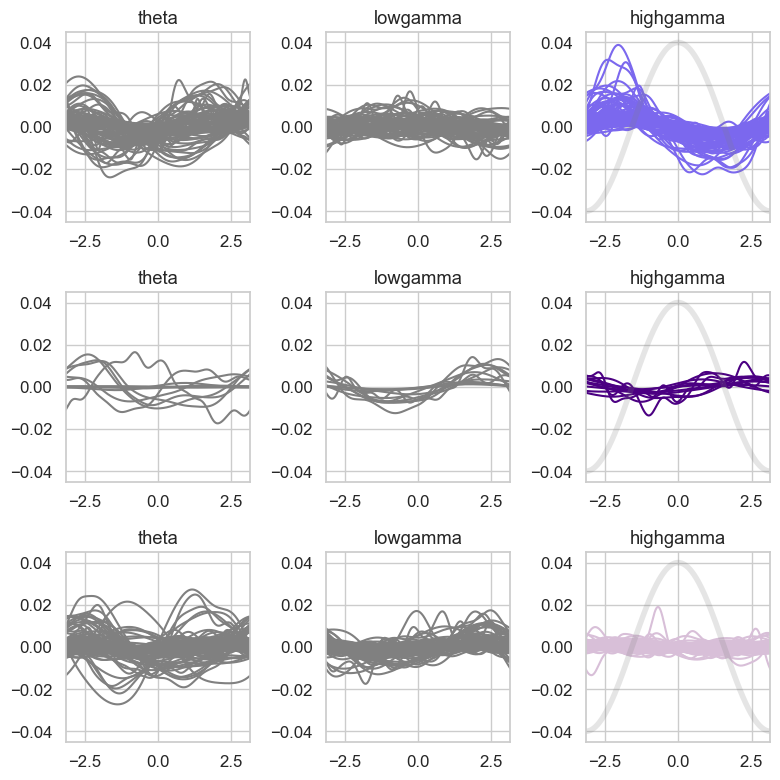

In [170]:
fig,ax=plt.subplots(3,3,figsize=(8,8))

## CLUST 0
rhythm = 'highgamma'
subclust = cluster_id_df[cluster_id_df['highgamma_clust_id'] == 0]
inds = subclust['spktrn_ind_labels'].values
ax[0][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[0][0].set_title('theta')

ax[0][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[0][1].set_title('lowgamma')

ax[0][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='mediumslateblue');
ax[0][2].set_title('highgamma')

ax[0][2].plot(domain,.04*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)


## CLUST 1

rhythm = 'highgamma'
subclust = cluster_id_df[cluster_id_df['highgamma_clust_id'] == 1]
inds = subclust['spktrn_ind_labels'].values
ax[1][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[1][0].set_title('theta')

ax[1][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[1][1].set_title('lowgamma')

ax[1][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='indigo');
ax[1][2].set_title('highgamma')

ax[1][2].plot(domain,.04*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

#CLUST 2

rhythm = 'highgamma'
subclust = cluster_id_df[cluster_id_df['highgamma_clust_id'] == 2]
inds = subclust['spktrn_ind_labels'].values
ax[2][0].plot(x,theta_kde_cent_odor[inds,:].T,color='grey');
ax[2][0].set_title('theta')

ax[2][1].plot(x,lowgamma_kde_cent_odor[inds,:].T,color='grey');
ax[2][1].set_title('lowgamma')

ax[2][2].plot(x,highgamma_kde_cent_odor[inds,:].T,color='thistle');
ax[2][2].set_title('highgamma')

ax[2][2].plot(domain,.04*(np.cos(domain)),color='grey',linewidth=4,alpha=0.2)

for ax in ax.flatten():
    ax.set_ylim(-0.045, .045)
    ax.set_xlim(-np.pi,np.pi)

    
fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'centered_phase_models_by_clust_id_highgamma_odorsamp.pdf'))

##### find the fraction of spike trains in each high gamma cluster


In [14]:
## CLUST 0
rhythm = 'highgamma'
subclust = cluster_id_df[cluster_id_df['highgamma_clust_id'] == 0]
inds = subclust['spktrn_ind_labels'].values

clust0_number = len(inds)
clust0_fraction = clust0_number/n_spktrns

## CLUST 1

rhythm = 'highgamma'
subclust = cluster_id_df[cluster_id_df['highgamma_clust_id'] == 1]
inds = subclust['spktrn_ind_labels'].values

clust1_number = len(inds)
clust1_fraction = clust1_number/n_spktrns
#CLUST 2

rhythm = 'highgamma'
subclust = cluster_id_df[cluster_id_df['highgamma_clust_id'] == 2]
inds = subclust['spktrn_ind_labels'].values

clust2_number = len(inds)
clust2_fraction = clust2_number/n_spktrns

print('clust0: ', clust0_fraction, 'n= ', clust0_number,
      '\nclust1: ', clust1_fraction, 'n= ', clust1_number,
      '\nclust2: ' , clust2_fraction,'n= ', clust2_number)

clust0:  0.4174757281553398 n=  86 
clust1:  0.05339805825242718 n=  11 
clust2:  0.529126213592233 n=  109


### now, figure out how many interneurons changed cluster id

In [15]:
from pprint import pprint

##### theta

In [16]:
cell_labels = list(set(cluster_id_df['cell_id']))

n_cells_clust_change = 0
theta_shifting_cells = []
which_theta_shifts = []
for cell_id in cell_labels:
    
    subclust = cluster_id_df[cluster_id_df['cell_id']==cell_id]
    
    unique_cluster_ids = set(subclust['theta_clust_id'].values)
    
    if len(unique_cluster_ids) > 1:
        n_cells_clust_change += 1
        theta_shifting_cells.append(cell_id)
        which_theta_shifts.append(unique_cluster_ids)

In [17]:
pprint([(i,j) for i,j in zip(theta_shifting_cells,which_theta_shifts)])
print(len(theta_shifting_cells),len(cell_labels))

[('LH02_D11_TETSPK05a', {2, 3}),
 ('LH16_D42_TETSPK37f', {2, 3}),
 ('LH02_D14_TETSPK13a', {2, 3}),
 ('LH08_D32_TETSPK21c', {2, 3}),
 ('LH02_D14_TETSPK41d', {2, 3}),
 ('LH16_D25_TETSPK33m', {0, 3}),
 ('LH03_D20_TETSPK61a', {1, 3}),
 ('LH16_D09_TETSPK29g', {0, 3}),
 ('LH09_D15_TETSPK13b', {2, 3}),
 ('LH16_D09_TETSPK21j', {0, 3}),
 ('LH16_D29_TETSPK53c', {2, 3}),
 ('LH02_D14_TETSPK13b', {2, 3}),
 ('LH08_D32_TETSPK53n', {0, 2, 3}),
 ('LH16_D33_TETSPK33j', {0, 1}),
 ('LH08_D32_TETSPK09c', {0, 3}),
 ('LH08_D28_TETSPK29c', {2, 3})]
16 30


##### low gamma 

In [18]:
cell_labels = list(set(cluster_id_df['cell_id']))

n_cells_clust_change = 0
lowgamma_shifting_cells = []
which_lowgamma_shifts = []
for cell_id in cell_labels:
    
    subclust = cluster_id_df[cluster_id_df['cell_id']==cell_id]
    
    unique_cluster_ids = set(subclust['lowgamma_clust_id'].values)
    
    if len(unique_cluster_ids) > 1:
        n_cells_clust_change += 1
        lowgamma_shifting_cells.append(cell_id)
        which_lowgamma_shifts.append(unique_cluster_ids)

In [19]:
pprint([(i,j) for i,j in zip(lowgamma_shifting_cells,which_lowgamma_shifts)])
print(len(lowgamma_shifting_cells), len(cell_labels))

[('LH02_D11_TETSPK05a', {2, 3}),
 ('LH16_D10_TETSPK33a', {2, 3}),
 ('LH03_D18_TETSPK09f', {0, 3}),
 ('LH08_D32_TETSPK21c', {0, 3}),
 ('LH02_D14_TETSPK41d', {1, 3}),
 ('LH16_D25_TETSPK33m', {1, 3}),
 ('LH03_D20_TETSPK61a', {2, 3}),
 ('LH16_D09_TETSPK29g', {1, 2, 3}),
 ('LH09_D14_TETSPK13b', {2, 3}),
 ('LH16_D10_TETSPK21k', {0, 1, 3}),
 ('LH16_D25_TETSPK37b', {0, 2, 3}),
 ('LH16_D22_TETSPK29g', {0, 3}),
 ('LH16_D42_TETSPK49m', {0, 1, 2, 3}),
 ('LH02_D14_TETSPK13b', {2, 3}),
 ('LH08_D32_TETSPK53n', {2, 3}),
 ('LH16_D33_TETSPK33j', {0, 3}),
 ('LH08_D32_TETSPK09c', {0, 3}),
 ('LH16_D22_TETSPK25f', {0, 3}),
 ('LH08_D28_TETSPK29c', {2, 3})]
19 30


##### high gamma

In [20]:
cell_labels = list(set(cluster_id_df['cell_id']))

n_cells_clust_change = 0
highgamma_shifting_cells = []
which_highgamma_shifts = []
for cell_id in cell_labels:
    
    subclust = cluster_id_df[cluster_id_df['cell_id']==cell_id]
    
    unique_cluster_ids = set(subclust['highgamma_clust_id'].values)
    
    if len(unique_cluster_ids) > 1:
        n_cells_clust_change += 1
        highgamma_shifting_cells.append(cell_id)
        which_highgamma_shifts.append(unique_cluster_ids)

In [21]:
pprint([(i,j) for i,j in zip(highgamma_shifting_cells,which_highgamma_shifts)])
print(len(highgamma_shifting_cells), len(cell_labels))

[('LH02_D11_TETSPK05a', {1, 2}),
 ('LH16_D42_TETSPK37f', {0, 2}),
 ('LH16_D22_TETSPK09c', {1, 2}),
 ('LH16_D10_TETSPK33a', {1, 2}),
 ('LH16_D29_TETSPK09a', {1, 2}),
 ('LH16_D25_TETSPK33m', {0, 2}),
 ('LH03_D20_TETSPK61a', {1, 2}),
 ('LH16_D09_TETSPK29g', {0, 2}),
 ('LH09_D14_TETSPK13b', {0, 2}),
 ('LH09_D15_TETSPK13b', {0, 2}),
 ('LH16_D25_TETSPK37b', {0, 2}),
 ('LH16_D09_TETSPK21j', {0, 2}),
 ('LH16_D22_TETSPK29g', {0, 2}),
 ('LH09_D09_TETSPK21b', {0, 2}),
 ('LH16_D29_TETSPK53c', {1, 2}),
 ('LH16_D42_TETSPK49m', {0, 2}),
 ('LH02_D14_TETSPK13b', {1, 2}),
 ('LH08_D32_TETSPK53n', {0, 2}),
 ('LH16_D33_TETSPK33j', {0, 2}),
 ('LH08_D32_TETSPK09c', {0, 2}),
 ('LH16_D22_TETSPK25f', {0, 2})]
21 30


## are there systematic relationships across rhythmic circuits? 
here, you'll set yourself up to compute conditional probabilities of cross-rhythmic cluster membership

In [22]:
theta_spktrains = cluster_id_df.groupby(['theta_clust_id','spktrn_ind_labels']).count().index
theta_clust0_spktrns = []
theta_clust1_spktrns = []
theta_clust2_spktrns = []
theta_clust3_spktrns = []
for s in theta_spktrains: 
    
    clust = s[0]
    spktrn = s[1]
    
    if clust == 0: 
        
        theta_clust0_spktrns.append(spktrn)
        
    if clust == 1: 
        
        theta_clust1_spktrns.append(spktrn)
        
    if clust == 2 :
        
        theta_clust2_spktrns.append(spktrn)
        
    if clust == 3 :
        
        theta_clust3_spktrns.append(spktrn)
        
        
lowgamma_spktrains = cluster_id_df.groupby(['lowgamma_clust_id','spktrn_ind_labels']).count().index
lowgamma_clust0_spktrns = []
lowgamma_clust1_spktrns = []
lowgamma_clust2_spktrns = []
lowgamma_clust3_spktrns = []
for s in lowgamma_spktrains: 
    
    clust = s[0]
    spktrn = s[1]
    
    if clust == 0: 
        
        lowgamma_clust0_spktrns.append(spktrn)
        
    if clust == 1: 
        
        lowgamma_clust1_spktrns.append(spktrn)
        
    if clust == 2 :
        
        lowgamma_clust2_spktrns.append(spktrn)
        
    if clust == 3 :
        
        lowgamma_clust3_spktrns.append(spktrn)
    
    
highgamma_spktrains = cluster_id_df.groupby(['highgamma_clust_id','spktrn_ind_labels']).count().index
highgamma_clust0_spktrns = []
highgamma_clust1_spktrns = []
highgamma_clust2_spktrns = []
for s in highgamma_spktrains: 
    
    clust = s[0]
    spktrn = s[1]
    
    if clust == 0: 
        
        highgamma_clust0_spktrns.append(spktrn)
        
    if clust == 1: 
        
        highgamma_clust1_spktrns.append(spktrn)
        
    if clust == 2 :
        
        highgamma_clust2_spktrns.append(spktrn)
    
    

    

below you'll actually compute the conditional probs, and then check that the probabilities work out to one per row of theta cluster identity, collapsing across high gamma or low gamma cluster identity

In [23]:
trueL0T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust0_spktrns))
trueL1T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust0_spktrns))
trueL2T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust0_spktrns))
trueL3T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust0_spktrns))

trueL0T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust1_spktrns))
trueL1T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust1_spktrns))
trueL2T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust1_spktrns))
trueL3T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust1_spktrns))

trueL0T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust2_spktrns))
trueL1T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust2_spktrns))
trueL2T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust2_spktrns))
trueL3T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust2_spktrns))

trueL0T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust3_spktrns))
trueL1T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust3_spktrns))
trueL2T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust3_spktrns))
trueL3T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust3_spktrns))

print(trueL0T0 + trueL1T0 + trueL2T0 + trueL3T0, trueL0T1 + trueL1T1 + trueL2T1 + trueL3T1, trueL0T2 + trueL1T2 + trueL2T2 + trueL3T2, trueL0T3 + trueL1T3 + trueL2T3 + trueL3T3)



trueH0T0 = len(set(theta_clust0_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust0_spktrns))
trueH1T0 = len(set(theta_clust0_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust0_spktrns))
trueH2T0 = len(set(theta_clust0_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust0_spktrns))

trueH0T1 = len(set(theta_clust1_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust1_spktrns))
trueH1T1 = len(set(theta_clust1_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust1_spktrns))
trueH2T1 = len(set(theta_clust1_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust1_spktrns))

trueH0T2 = len(set(theta_clust2_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust2_spktrns))
trueH1T2 = len(set(theta_clust2_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust2_spktrns))
trueH2T2 = len(set(theta_clust2_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust2_spktrns))

trueH0T3 = len(set(theta_clust3_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust3_spktrns))
trueH1T3 = len(set(theta_clust3_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust3_spktrns))
trueH2T3 = len(set(theta_clust3_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust3_spktrns))


print(trueH0T0 + trueH1T0 + trueH2T0, trueH0T1 + trueH1T1 + trueH2T1, trueH0T2 + trueH1T2 + trueH2T2, trueH0T3 + trueH1T3 + trueH2T3)





1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0


set these data up nicely to plot using seaborn

In [24]:
LgivenT = {'Ttrough': [trueL0T0,trueL1T0,trueL2T0,trueL3T0],
           'Tasc': [trueL0T1,trueL1T1,trueL2T1,trueL3T1],
           'Tdesc': [trueL0T2,trueL1T2,trueL2T2,trueL3T2],
           'Tuni': [trueL0T3,trueL1T3,trueL2T3,trueL3T3]
          }
LgivenT_df = pd.DataFrame(LgivenT)

T = pd.Series(['Llateasc','Learlydesc','Ltrough','Luni'])
LgivenT_df = LgivenT_df.set_index(T)

HgivenT = {'Ttrough': [trueH0T0,trueH1T0,trueH2T0],
           'Tasc': [trueH0T1,trueH1T1,trueH2T1],
           'Tdesc': [trueH0T2,trueH1T2,trueH2T2],
           'Tuni': [trueH0T3,trueH1T3,trueH2T3]
          }
HgivenT_df = pd.DataFrame(HgivenT)

T = pd.Series(['Hasc','Hdesc','Huni'])
HgivenT_df = HgivenT_df.set_index(T)

### Figure 2C (left columns)

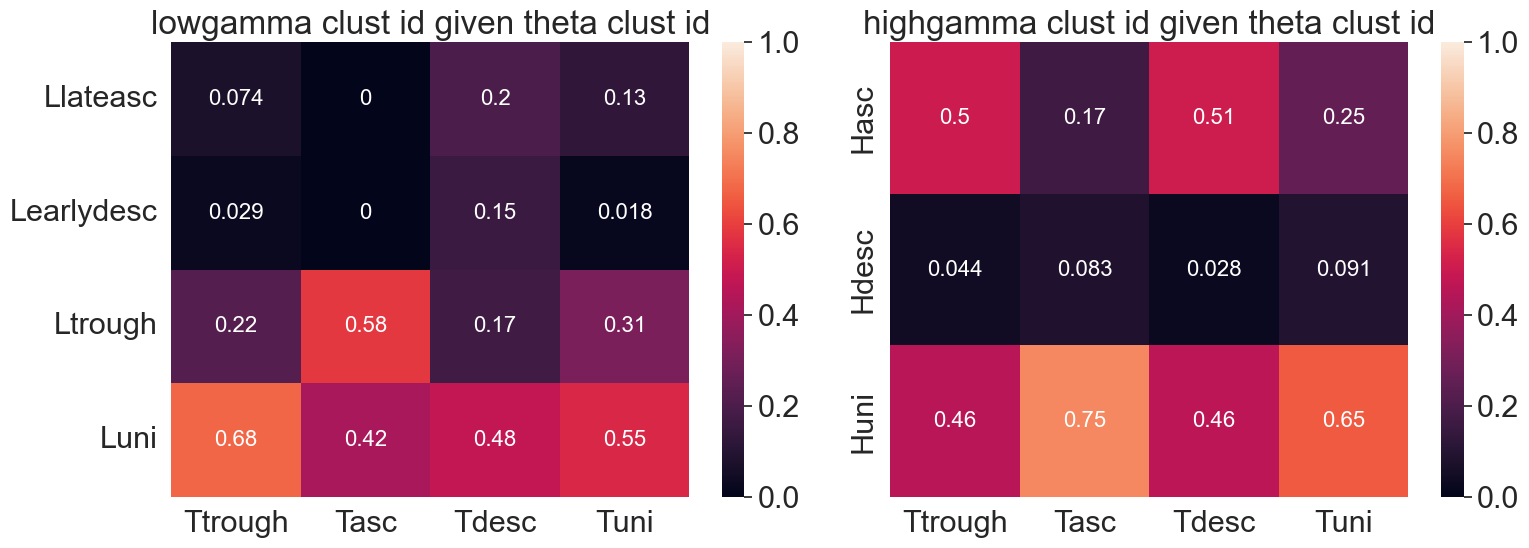

In [182]:
sns.set(font_scale=2)
fig,ax = plt.subplots(1,2,figsize=(16,6))


g = sns.heatmap(data=LgivenT_df,
                vmin=0,
                vmax=1,
                annot=True,
                annot_kws={"size": 16},
                ax=ax[0]
               ).set_title('lowgamma clust id given theta clust id')



g = sns.heatmap(data=HgivenT_df,
                vmin=0,
                vmax=1,
                annot=True,
                annot_kws={"size": 16},
                ax=ax[1]
               ).set_title('highgamma clust id given theta clust id')

fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'cond_probs_highfreq_clust_id_by_theta_id_odorsamp.pdf'))

Now, get the joint probabilities of low gamma and high gamma cluster membership--you will work to find the intersection of venn diagrams of low gamma and high gamma cluster membership

In [25]:
trueH0L0 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust0_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust0_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust0_spktrns)))
trueH0L1 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust1_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust1_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust1_spktrns)))
trueH0L2 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust2_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust2_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust2_spktrns)))
trueH0L3 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust3_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust3_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust3_spktrns)))

trueH1L0 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust0_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust0_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust0_spktrns)))
trueH1L1 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust1_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust1_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust1_spktrns)))
trueH1L2 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust2_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust2_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust2_spktrns)))
trueH1L3 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust3_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust3_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust3_spktrns)))

trueH2L0 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust0_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust0_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust0_spktrns)))
trueH2L1 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust1_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust1_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust1_spktrns)))
trueH2L2 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust2_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust2_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust2_spktrns)))
trueH2L3 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust3_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust3_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust3_spktrns)))



set it up nicely for seaborn plotting

In [26]:
HandL = {'H0andL': [trueH0L0,trueH0L1,trueH0L2,trueH0L3],
         'H1andL': [trueH1L0,trueH1L1,trueH1L2,trueH1L3],
         'H2andL': [trueH2L0,trueH2L1,trueH2L2,trueH2L3]
          }
HandL_df = pd.DataFrame(HandL)

L = pd.Series(['Llateasc','Learlydesc','Ltrough','Luni'])
HandL_df = HandL_df.set_index(L)

### Figure 2D (left columns)

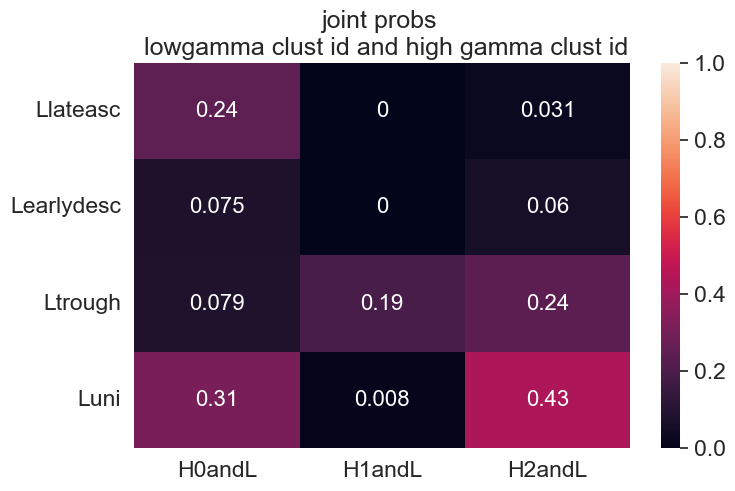

In [185]:
sns.set(font_scale=1.5)
fig,ax = plt.subplots(figsize=(8,5))


g = sns.heatmap(data=HandL_df,
                vmin=0,
                vmax=1,
                annot=True,
                annot_kws={"size": 16},
                ax=ax).set_title('joint probs \n lowgamma clust id and high gamma clust id')

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'joint_probs_lowgamma_highgamma_clust_id_odorsamp.pdf'))


## permutation tests: what would the conditional & joint probabilities have looked like by chance? 
here, try out shuffling the spike times within a theta phase bin relative to the lfp, and see whether you can still get this distribution of conditional probabilities by chance -- importantly, you don't have to fit new models: the important thing is to get the shuffled spike-train's rayleigh statistics and circular mean preference relative to the high frequency rhythms. Since you won't have disturbed the theta phase relationship, the columns of the conditional probs heatmaps above stay the same, it's just that the entries should change if those above are unique, and not attainable by chance. 

In [186]:
datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]

fs = 1000 
nperms = 20


gather_dfs = []

savedir = 'perm_spikes_byclustbin_odorsamp/'
for file in tqdm(files,position=0,leave=True,colour='cornflowerblue'): 
    
    df = pd.read_csv(os.path.join(datapath,file))
    odorsamp_df = df[df['trial_segment']=='dur']
    
    ratsession = file.split('_')[0] + '_' + file.split('_')[1]
    
    #find all neurons in the dataset
    neuron_expression = 'TETSPK'
    neuron_cols = get_neuron_cols(odorsamp_df,neuron_expression)
    
    for neuron in neuron_cols: 
        
        gather_permspikes = pd.DataFrame()
        gather_cycles = pd.DataFrame()
        gather_meta = pd.DataFrame()
        
        #find the corresponding lfp
        allow_wire = get_allowable_lfp_wires(odorsamp_df,'K')
        
        lfp_expression = "TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z"
        lfp_cols = get_lfp_cols(odorsamp_df,lfp_expression)
        
        for lfpname in lfp_cols: 

            #now compute the phase estimates for these filtered columns
            analytic = hilbert(odorsamp_df[lfpname+'filt_theta'].values)
            phase = np.arctan2(analytic.imag,odorsamp_df[lfpname+'filt_theta'].values)
            
            odorsamp_df[lfpname+'phase_theta'] = phase

            #add a column of labels that marks which theta phase bin (as defined by the cluster edges above)
            #describes each lfp cycle
            theta_phase_edges = [-np.pi,-3,-1,1.5,np.pi]
            theta_bin_labels = [2,0,1,2] #cluster identities as arbitrarily defined above

            odorsamp_df[lfpname+'theta_clust_bins'] = pd.cut(phase,
                                                             bins = theta_phase_edges,
                                                             labels = theta_bin_labels,
                                                             ordered=False,
                                                             right=False,
                                                             include_lowest=True
                                                            )

            conditions = list(set(odorsamp_df['odor_labels']))

            for condition in conditions: 

                subcondition = odorsamp_df[odorsamp_df['odor_labels']==condition]

                acc = subcondition['accuracy'].iloc[0]
                if acc >= .75: 
                    
                    trial_labels = list(set(subcondition['trial_labels']))
                    
                    if len(trial_labels) >= 4: 
                    
                        for trial in trial_labels: 

                            subtrial = subcondition[subcondition['trial_labels']==trial]

                            #label all the phase cycles so you can iterate through them

                            filtcol = lfpname+'filt_theta'
                            subtrial = label_phase_cycles(subtrial,filtcol,fs,trial)

                            cycle_labels = list(set(subtrial['cycle_labels']))

                            for cycle in cycle_labels: 

                                subcycle = subtrial[subtrial['cycle_labels']==cycle]

                                phase_bin_labels = list(set(subcycle[lfpname+'theta_clust_bins']))

                                for pbl in phase_bin_labels: 

                                    subbin = subcycle[subcycle[lfpname+'theta_clust_bins']==pbl]

                                    pos = subbin['pos_labels'].iloc[0]

                                    nsamps = subbin.shape[0]

                                    gather_binspikes = pd.DataFrame()
                                    
                                    for perm in range(nperms): 

                                        index_range = subbin.index
                                        new_sequence = np.random.permutation(index_range)
                                        spike_shuffle = subbin.reindex(new_sequence)

                                        #then set up a dataframe of shuffled spike times
                                        #within theta phase bin

                                        gather_binspikes['perm'+str(perm)+'_'+neuron] = spike_shuffle[neuron].values
                                        permcols = [p for p in gather_binspikes.columns if p.startswith('perm')]


                                        mini_meta = {'ratsession_id': np.repeat(ratsession,nsamps),
                                                     'accuracy': np.repeat(acc,nsamps),
                                                     'odor_labels': np.repeat(condition,nsamps),
                                                     'pos_labels': np.repeat(pos,nsamps),
                                                     'trial_labels': np.repeat(trial,nsamps),
                                                     lfpname: subbin[lfpname].values,
                                                     lfpname+'filt_theta': subbin[lfpname+'filt_theta'].values,
                                                     lfpname+'filt_lowgamma': subbin[lfpname+'filt_lowgamma'].values,
                                                     lfpname+'filt_highgamma': subbin[lfpname+'filt_highgamma'].values,
                                                     neuron: subbin[neuron].values,
                                                     'cycle_labels': np.repeat(cycle,nsamps),
                                                     lfpname+'theta_clust_bins': subbin[lfpname+'theta_clust_bins'].values
                                                    }

                                    gather_cycles = pd.concat([gather_cycles,gather_binspikes],
                                                              ignore_index=True
                                                             )
                                    gather_meta = pd.concat([gather_meta,pd.DataFrame(mini_meta)],
                                                            ignore_index=True
                                                           )


            gather_permspikes = pd.concat([gather_meta,gather_cycles[permcols]],axis=1)
            filename = ratsession + '_' + lfpname + '_' + neuron + 'permspikes.csv'
            if not os.path.exists(savedir): 
                os.makedirs(savedir)

            gather_permspikes.to_csv(os.path.join(savedir,filename))

                                

                    

  0%|          | 0/18 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'phase_theta'] = phase
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'theta_clust_bins'] = pd.cut(phase,
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'phase_theta'] = phase
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'theta_clust_bins'] = pd.cut(phase,
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'phase_theta'] = phase
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'theta_clust_bins'] = pd.cut(phase,
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'phase_theta'] = phase
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_2248/2504639080.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odorsamp_df[lfpname+'theta_clust_bins'] = pd.cut(phase,


With this code, you end up saving all permuted datasets per session, per neuron/LFP combination.

Now, re-create the conditional probabilities of cluster membership given theta cluster membership, but with the permuted spike phase distributions.

In [27]:
permpath = 'perm_spikes_byclustbin_odorsamp/'
permfiles = os.listdir(permpath)
permfiles = [f for f in permfiles if not f.startswith('.')]

nsplits = 7 #for model fitting
    
rhythms = ['theta','lowgamma','highgamma']

gather_dfs = pd.DataFrame()
for permfile in tqdm(permfiles,position=0,leave=True,colour='cornflowerblue'): 
    
    permdf = pd.read_csv(os.path.join(permpath,permfile))
    permcols = [p for p in permdf.columns if p.startswith('perm')]
    
    unitwire = permfile.split('perm')[0].split('TETSPK')[1][:2] #grab just the wire number
    lfpcol = [fp for fp in permdf.columns if fp.endswith(unitwire)]
    counter = 1 #in case the lfpcol is empty because the lfp corresponds to a different wire of the tetrode
    while len(lfpcol) == 0: 
        lfpcol = [fp for fp in permdf.columns if fp.endswith(str(int(unitwire)+counter))]
        counter+=1
    lfpcol = lfpcol[0]
    
    ratsession = permfile.split('_')[0] + '_' + permfile.split('_')[1]
    
    neuron = permfile.split('_')[3].split('perm')[0]
    
    for permcol in permcols: 
        
        subperm = permdf[['odor_labels',
                          'accuracy',
                          lfpcol+'filt_theta',
                          lfpcol+'filt_lowgamma',
                          lfpcol+'filt_highgamma',
                          permcol]]
        
        condition_labels = list(set(subperm['odor_labels']))
        
        for condition in condition_labels: 
            
            subcond = subperm[subperm['odor_labels']==condition]

            df_for_ray = pd.DataFrame()
            
            acc = subcond['accuracy'].iloc[0]
            if (acc >= 0.75) & (subcond[permcol].sum() > nsplits): 
        
                for rhythm in rhythms: 
                
                    #take the phase estimates of the filtered lfp
                    filtered = subcond[lfpcol+'filt_'+rhythm].values
                    analytic = hilbert(filtered)
                    phases = np.arctan2(analytic.imag,filtered)

                    spikes = subcond[permcol].values

                    #get the spike-phase distribution
                    phi_when_sp = []
                    for s,p in zip(spikes,phases):
                        if s==1: 
                            phi_when_sp.append(p)

                    #get its rayleigh & circmean
                    df_for_ray['spikes'] = spikes
                    df_for_ray[rhythm+'_phases'] = phases
                    ray = rayleigh_pr(df_for_ray, rhythm)

                    #put this all in a data frame where all neurons's perm data is together
        
                    meta = {'ratsession_id': ratsession,
                            'neuron': neuron,
                            'permutation': permcol,
                            'odor_labels': [condition],
                           }
                    metaray = pd.concat([pd.DataFrame(meta),ray],axis=1)
                    gather_dfs = pd.concat([gather_dfs, metaray])
        

  0%|          | 0/31 [00:00<?, ?it/s]

In [28]:
gather_dfs['cell_id'] = gather_dfs['ratsession_id'] + '_' + gather_dfs['neuron']

In [29]:
kde_odor['odor_labels'] = kde_odor['condition_labels']

In [30]:
cell_labels = list(set(gather_dfs['cell_id']))

gather_permdfs = []
for cell_id in tqdm(cell_labels,position=0,colour='cornflowerblue'): 
    
    subcell = gather_dfs[gather_dfs['cell_id']==cell_id]
    subkde = kde_odor[kde_odor['cell_id']==cell_id]
    
    odor_labels = list(set(subcell['odor_labels']))
    for odor in odor_labels: 
        
        subodor = subcell[subcell['odor_labels']==odor]
        subko = subkde[subkde['odor_labels']==odor]
        
        spktrn_ind = list(set(subko['spktrn_ind_labels']))
        
        if len(spktrn_ind) == 1:
        
            subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
            
        else: 
            
            print('more than one spiketrain label found')
            
        gather_permdfs.append(subodor)
        
gather_permdfs = pd.concat(gather_permdfs)

  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subodor['spktrn_ind_labels'] = np.repeat(spktrn_ind,subodor.shape[0])
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1035/4166546101.py:19: SettingWithCopyWarning: 
A value i

In [31]:
gather_dfs = gather_permdfs

Ok, now apply the clustering scheme for each rhythm


In [78]:
alpha = 0.05

gather_dfs['significant'] = [1 if (i < alpha) else 0 for i in gather_dfs['pval'].values]

In [121]:
#theta
# phase_thresh_midleft_T = -2
# phase_thresh_midright_T = 0
# phase_thresh_farright_T = 2.85

permsubtheta_sig = gather_dfs[(gather_dfs['rhythm'] == 'theta') & (gather_dfs['significant'] == 1)]
permsubtheta_nosig = gather_dfs[(gather_dfs['rhythm'] == 'theta') & (gather_dfs['significant'] == 0)]

cluster0a = permsubtheta_sig[(permsubtheta_sig['circmean'] <= phase_thresh_midleft_T)].reset_index()
cluster0b = permsubtheta_sig[(permsubtheta_sig['circmean'] > phase_thresh_farright_T)].reset_index()
permcluster0_T = pd.concat([cluster0a,cluster0b])

permcluster1_T = permsubtheta_sig[(permsubtheta_sig['circmean'] > phase_thresh_midleft_T) & (permsubtheta_sig['circmean'] <= phase_thresh_midright_T)].reset_index()

permcluster2_T = permsubtheta_sig[(permsubtheta_sig['circmean'] > phase_thresh_midright_T) & (permsubtheta_sig['circmean'] <= phase_thresh_farright_T)].reset_index()

permcluster3_T = permsubtheta_nosig.reset_index()

permcluster0_T['theta_clust_id'] = np.repeat(0,permcluster0_T.shape[0])
permcluster1_T['theta_clust_id'] = np.repeat(1,permcluster1_T.shape[0])
permcluster2_T['theta_clust_id'] = np.repeat(2,permcluster2_T.shape[0])
permcluster3_T['theta_clust_id'] = np.repeat(3,permcluster3_T.shape[0])

permtheta_cluster_id_df = pd.concat([permcluster0_T,permcluster1_T,permcluster2_T,permcluster3_T])

subtheta_clust_df = permtheta_cluster_id_df[['cell_id',
                                             'permutation',
                                             'odor_labels',
                                             'theta_clust_id',
                                             'spktrn_ind_labels'
                                            ]]

#lowgamma

permsublowgamma_sig = gather_dfs[(gather_dfs['rhythm'] == 'lowgamma') & (gather_dfs['significant'] == 1)]
permsublowgamma_nosig = gather_dfs[(gather_dfs['rhythm'] == 'lowgamma') & (gather_dfs['significant'] == 0)]

# phase_thresh_farleft_LG = -2
# phase_thresh_mid_LG = 0.25
# phase_thresh_farright_LG = 1.25

permcluster0 = permsublowgamma_sig[(permsublowgamma_sig['circmean'] > phase_thresh_farleft_LG)&(permsublowgamma_sig['circmean'] <= phase_thresh_mid_LG)].reset_index()

permcluster1 = permsublowgamma_sig[(permsublowgamma_sig['circmean'] > phase_thresh_mid_LG) & (permsublowgamma_sig['circmean'] <= phase_thresh_farright_LG)].reset_index()

permcluster2a = permsublowgamma_sig[(permsublowgamma_sig['circmean'] > phase_thresh_farright_LG)].reset_index()
permcluster2b = permsublowgamma_sig[(permsublowgamma_sig['circmean'] <= phase_thresh_farleft_LG)].reset_index()
permcluster2 = pd.concat([permcluster2a,permcluster2b])

permcluster3 = permsublowgamma_nosig.reset_index()

permcluster0['lowgamma_clust_id'] = np.repeat(0,permcluster0.shape[0])
permcluster1['lowgamma_clust_id'] = np.repeat(1,permcluster1.shape[0])
permcluster2['lowgamma_clust_id'] = np.repeat(2,permcluster2.shape[0])
permcluster3['lowgamma_clust_id'] = np.repeat(3,permcluster3.shape[0])


permlowgamma_cluster_id_df = pd.concat([permcluster0,permcluster1,permcluster2,permcluster3])

sublowgamma_clust_df = permlowgamma_cluster_id_df[['cell_id',
                                                   'permutation',
                                                   'odor_labels',
                                                   'lowgamma_clust_id',
                                                   'spktrn_ind_labels'
                                                  ]]

#highgamma

permsubhighgamma_sig = gather_dfs[(gather_dfs['rhythm'] == 'highgamma') & (gather_dfs['significant'] == 1)]
permsubhighgamma_nosig = gather_dfs[(gather_dfs['rhythm'] == 'highgamma') & (gather_dfs['significant'] == 0)]

# phase_thresh_mid_HG = 0


permcluster0_HG = permsubhighgamma_sig[(permsubhighgamma_sig['circmean'] <= phase_thresh_mid_HG)].reset_index()

permcluster1_HG = permsubhighgamma_sig[(permsubhighgamma_sig['circmean'] > phase_thresh_mid_HG)].reset_index()

permcluster2_HG = permsubhighgamma_nosig.reset_index()

permcluster0_HG['highgamma_clust_id'] = np.repeat(0,permcluster0_HG.shape[0])
permcluster1_HG['highgamma_clust_id'] = np.repeat(1,permcluster1_HG.shape[0])
permcluster2_HG['highgamma_clust_id'] = np.repeat(2,permcluster2_HG.shape[0])

permhighgamma_cluster_id_df = pd.concat([permcluster0_HG,permcluster1_HG,permcluster2_HG])

subhighgamma_clust_df = permhighgamma_cluster_id_df[['cell_id',
                                                     'permutation',
                                                     'odor_labels',
                                                     'highgamma_clust_id',
                                                     'spktrn_ind_labels'
                                                    ]]


In [106]:
permlabels = list(set(subtheta_clust_df['permutation']))
nperms = 20
npermlist = [int(i) for i in np.linspace(0,nperms-1,nperms)]

theta_clust0_perms = []
theta_clust1_perms = []
theta_clust2_perms = []
theta_clust3_perms = []

for perm in tqdm(npermlist,position=0,colour='cornflowerblue'): 
    
    selectperms = [p for p in permlabels if p.startswith('perm'+str(perm)+'_')]
    subperm_theta = subtheta_clust_df[subtheta_clust_df['permutation'].isin(selectperms)]

    theta_spktrains = subperm_theta.groupby(['theta_clust_id','spktrn_ind_labels']).count().index
    theta_clust0_spktrns = []
    theta_clust1_spktrns = []
    theta_clust2_spktrns = []
    theta_clust3_spktrns = []

    for s in theta_spktrains: 

        clust = s[0]
        spktrn = s[1]

        if clust == 0: 

            theta_clust0_spktrns.append(spktrn)

        if clust == 1: 

            theta_clust1_spktrns.append(spktrn)

        if clust == 2 :

            theta_clust2_spktrns.append(spktrn)

        if clust == 3 :

            theta_clust3_spktrns.append(spktrn)


    theta_clust0_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': theta_clust0_spktrns
                              }))
    theta_clust1_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': theta_clust1_spktrns
                              }))
    theta_clust2_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': theta_clust2_spktrns
                              }))
    theta_clust3_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': theta_clust3_spktrns
                              }))

  0%|          | 0/20 [00:00<?, ?it/s]

In [107]:
theta_clust0_perms = pd.concat(theta_clust0_perms)
theta_clust1_perms = pd.concat(theta_clust1_perms)
theta_clust2_perms = pd.concat(theta_clust2_perms)
theta_clust3_perms = pd.concat(theta_clust3_perms)

In [122]:
permlabels = list(set(sublowgamma_clust_df['permutation']))

npermlist = [int(i) for i in np.linspace(0,nperms-1,nperms)]

lowgamma_clust0_perms = []
lowgamma_clust1_perms = []
lowgamma_clust2_perms = []
lowgamma_clust3_perms = []

for perm in tqdm(npermlist,position=0,colour='cornflowerblue'): 
    
    selectperms = [p for p in permlabels if p.startswith('perm'+str(perm)+'_')]
    subperm_lowgamma = sublowgamma_clust_df[sublowgamma_clust_df['permutation'].isin(selectperms)]

    lowgamma_spktrains = subperm_lowgamma.groupby(['lowgamma_clust_id','spktrn_ind_labels']).count().index
    lowgamma_clust0_spktrns = []
    lowgamma_clust1_spktrns = []
    lowgamma_clust2_spktrns = []
    lowgamma_clust3_spktrns = []

    for s in lowgamma_spktrains: 

        clust = s[0]
        spktrn = s[1]

        if clust == 0: 

            lowgamma_clust0_spktrns.append(spktrn)

        if clust == 1: 

            lowgamma_clust1_spktrns.append(spktrn)

        if clust == 2 :

            lowgamma_clust2_spktrns.append(spktrn)

        if clust == 3 :

            lowgamma_clust3_spktrns.append(spktrn)


    lowgamma_clust0_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': lowgamma_clust0_spktrns
                              }))
    lowgamma_clust1_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': lowgamma_clust1_spktrns
                              }))
    lowgamma_clust2_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': lowgamma_clust2_spktrns
                              }))
    lowgamma_clust3_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': lowgamma_clust3_spktrns
                              }))

  0%|          | 0/20 [00:00<?, ?it/s]

In [123]:
lowgamma_clust0_perms = pd.concat(lowgamma_clust0_perms)
lowgamma_clust1_perms = pd.concat(lowgamma_clust1_perms)
lowgamma_clust2_perms = pd.concat(lowgamma_clust2_perms)
lowgamma_clust3_perms = pd.concat(lowgamma_clust3_perms)

In [108]:
permlabels = list(set(subhighgamma_clust_df['permutation']))

npermlist = [int(i) for i in np.linspace(0,nperms-1,nperms)]

highgamma_clust0_perms = []
highgamma_clust1_perms = []
highgamma_clust2_perms = []

for perm in tqdm(npermlist,position=0,colour='cornflowerblue'): 
    
    selectperms = [p for p in permlabels if p.startswith('perm'+str(perm)+'_')]
    subperm_highgamma = subhighgamma_clust_df[subhighgamma_clust_df['permutation'].isin(selectperms)]

    highgamma_spktrains = subperm_highgamma.groupby(['highgamma_clust_id','spktrn_ind_labels']).count().index
    highgamma_clust0_spktrns = []
    highgamma_clust1_spktrns = []
    highgamma_clust2_spktrns = []
 

    for s in highgamma_spktrains: 

        clust = s[0]
        spktrn = s[1]

        if clust == 0: 

            highgamma_clust0_spktrns.append(spktrn)

        if clust == 1: 

            highgamma_clust1_spktrns.append(spktrn)

        if clust == 2 :

            highgamma_clust2_spktrns.append(spktrn)


    highgamma_clust0_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': highgamma_clust0_spktrns
                              }))
    highgamma_clust1_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': highgamma_clust1_spktrns
                              }))
    highgamma_clust2_perms.append(pd.DataFrame({'perm': perm,
                               'spktrns': highgamma_clust2_spktrns
                              }))


  0%|          | 0/20 [00:00<?, ?it/s]

In [109]:
highgamma_clust0_perms = pd.concat(highgamma_clust0_perms)
highgamma_clust1_perms = pd.concat(highgamma_clust1_perms)
highgamma_clust2_perms = pd.concat(highgamma_clust2_perms)


Compute all the permuted-data conditional probabilities

In [124]:
perm_cond_probs = []
for perm in npermlist: 
    
    theta_clust0_spktrns = theta_clust0_perms[theta_clust0_perms['perm']==perm]['spktrns'].values
    theta_clust1_spktrns = theta_clust1_perms[theta_clust1_perms['perm']==perm]['spktrns'].values
    theta_clust2_spktrns = theta_clust2_perms[theta_clust2_perms['perm']==perm]['spktrns'].values
    theta_clust3_spktrns = theta_clust3_perms[theta_clust3_perms['perm']==perm]['spktrns'].values
    
    lowgamma_clust0_spktrns = lowgamma_clust0_perms[lowgamma_clust0_perms['perm']==perm]['spktrns'].values
    lowgamma_clust1_spktrns = lowgamma_clust1_perms[lowgamma_clust1_perms['perm']==perm]['spktrns'].values
    lowgamma_clust2_spktrns = lowgamma_clust2_perms[lowgamma_clust2_perms['perm']==perm]['spktrns'].values
    lowgamma_clust3_spktrns = lowgamma_clust3_perms[lowgamma_clust3_perms['perm']==perm]['spktrns'].values
    
    highgamma_clust0_spktrns = highgamma_clust0_perms[highgamma_clust0_perms['perm']==perm]['spktrns'].values
    highgamma_clust1_spktrns = highgamma_clust1_perms[highgamma_clust1_perms['perm']==perm]['spktrns'].values
    highgamma_clust2_spktrns = highgamma_clust2_perms[highgamma_clust2_perms['perm']==perm]['spktrns'].values
    
    
    L0T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust0_spktrns))
    L1T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust0_spktrns))
    L2T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust0_spktrns))
    L3T0 = len(set(theta_clust0_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust0_spktrns))
    
    L0T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust1_spktrns))
    L1T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust1_spktrns))
    L2T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust1_spktrns))
    L3T1 = len(set(theta_clust1_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust1_spktrns))

    L0T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust2_spktrns))
    L1T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust2_spktrns))
    L2T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust2_spktrns))
    L3T2 = len(set(theta_clust2_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust2_spktrns))

    L0T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust0_spktrns)) / len(set(theta_clust3_spktrns))
    L1T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust1_spktrns)) / len(set(theta_clust3_spktrns))
    L2T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust2_spktrns)) / len(set(theta_clust3_spktrns))
    L3T3 = len(set(theta_clust3_spktrns) & set(lowgamma_clust3_spktrns)) / len(set(theta_clust3_spktrns))
    
    H0T0 = len(set(theta_clust0_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust0_spktrns))
    H1T0 = len(set(theta_clust0_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust0_spktrns))
    H2T0 = len(set(theta_clust0_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust0_spktrns))

    H0T1 = len(set(theta_clust1_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust1_spktrns))
    H1T1 = len(set(theta_clust1_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust1_spktrns))
    H2T1 = len(set(theta_clust1_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust1_spktrns))

    H0T2 = len(set(theta_clust2_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust2_spktrns))
    H1T2 = len(set(theta_clust2_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust2_spktrns))
    H2T2 = len(set(theta_clust2_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust2_spktrns))

    H0T3 = len(set(theta_clust3_spktrns) & set(highgamma_clust0_spktrns)) / len(set(theta_clust3_spktrns))
    H1T3 = len(set(theta_clust3_spktrns) & set(highgamma_clust1_spktrns)) / len(set(theta_clust3_spktrns))
    H2T3 = len(set(theta_clust3_spktrns) & set(highgamma_clust2_spktrns)) / len(set(theta_clust3_spktrns))
    
    perm_cond_probs.append(pd.DataFrame({'perm': [perm],
                                         'L0T0': [L0T0],
                                         'L1T0': [L1T0],
                                         'L2T0': [L2T0],
                                         'L3T0': [L3T0],
                                         'L0T1': [L0T1],
                                         'L1T1': [L1T1],
                                         'L2T1': [L2T1],
                                         'L3T1': [L3T1],
                                         'L0T2': [L0T2],
                                         'L1T2': [L1T2],
                                         'L2T2': [L2T2],
                                         'L3T2': [L3T2],
                                         'L0T3': [L0T3],
                                         'L1T3': [L1T3],
                                         'L2T3': [L2T3],
                                         'L3T3': [L3T3],
                                         'H0T0': [H0T0],
                                         'H1T0': [H1T0],
                                         'H2T0': [H2T0],
                                         'H0T1': [H0T1],
                                         'H1T1': [H1T1],
                                         'H2T1': [H2T1],
                                         'H0T2': [H0T2],
                                         'H1T2': [H1T2],
                                         'H2T2': [H2T2],
                                         'H0T3': [H0T3],
                                         'H1T3': [H1T3],
                                         'H2T3': [H2T3]
                                        }))
    
perm_cond_probs = pd.concat(perm_cond_probs)

They should add up to 1 per theta cluster column

In [125]:
print(L0T0 + L1T0 + L2T0 + L3T0, L0T1 + L1T1 + L2T1 + L3T1, L0T2 + L1T2 + L2T2 + L3T2, L0T3 + L1T3 + L2T3 + L3T3)
print(H0T0 + H1T0 + H2T0, H0T1 + H1T1 + H2T1, H0T2 + H1T2 + H2T2, H0T3 + H1T3 + H2T3)

1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0


You can take a look at each dataset's conditional probability matrices: 

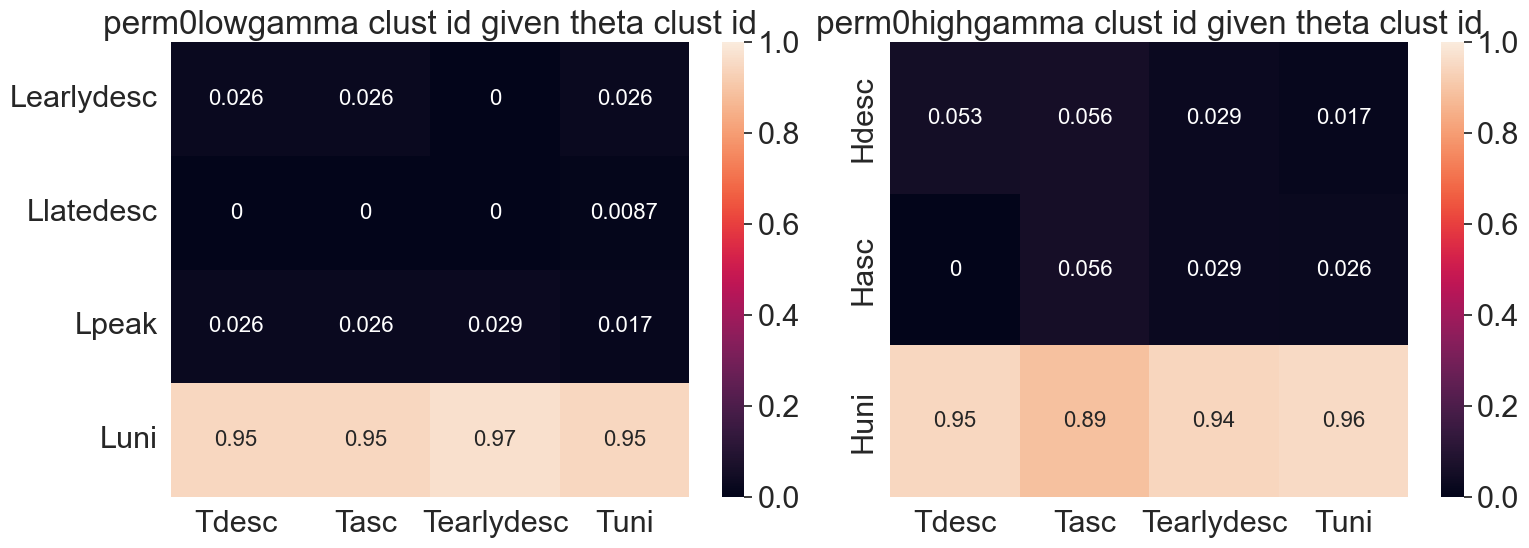

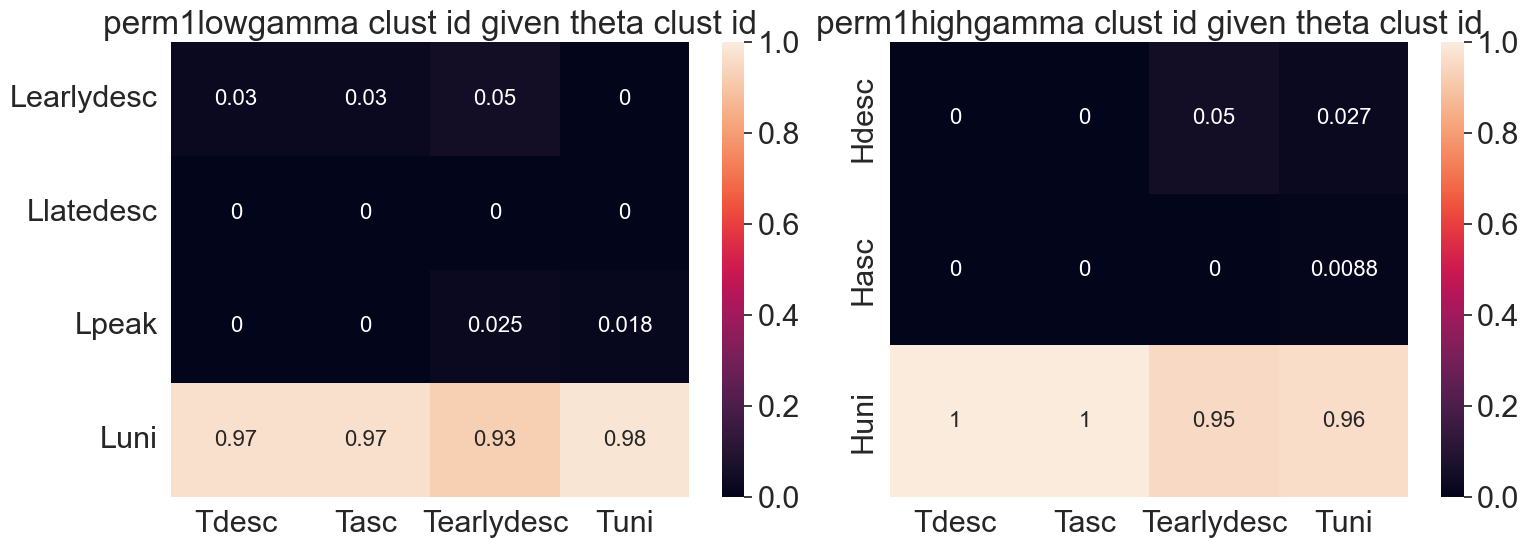

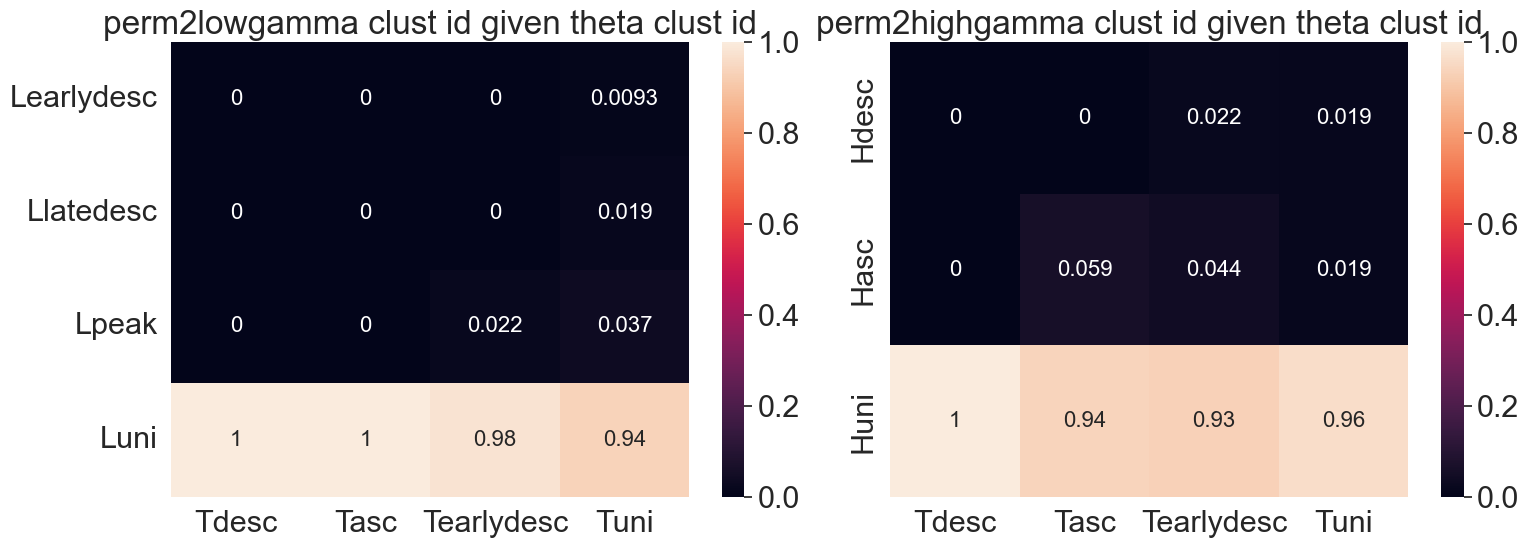

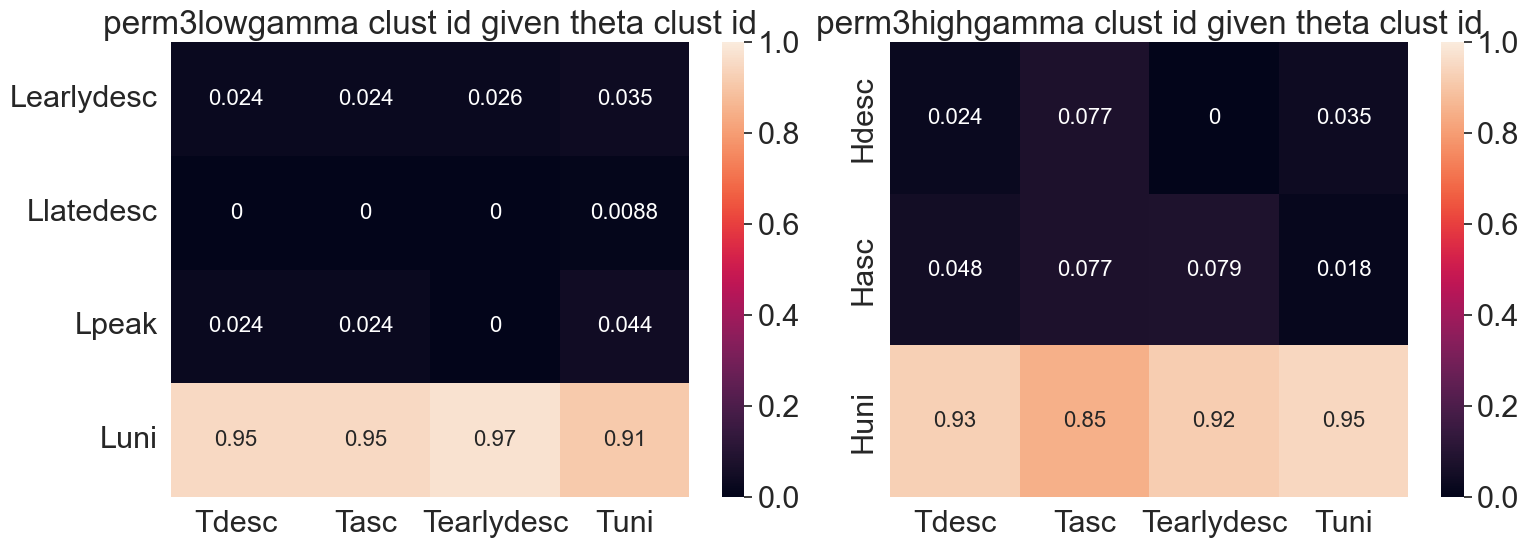

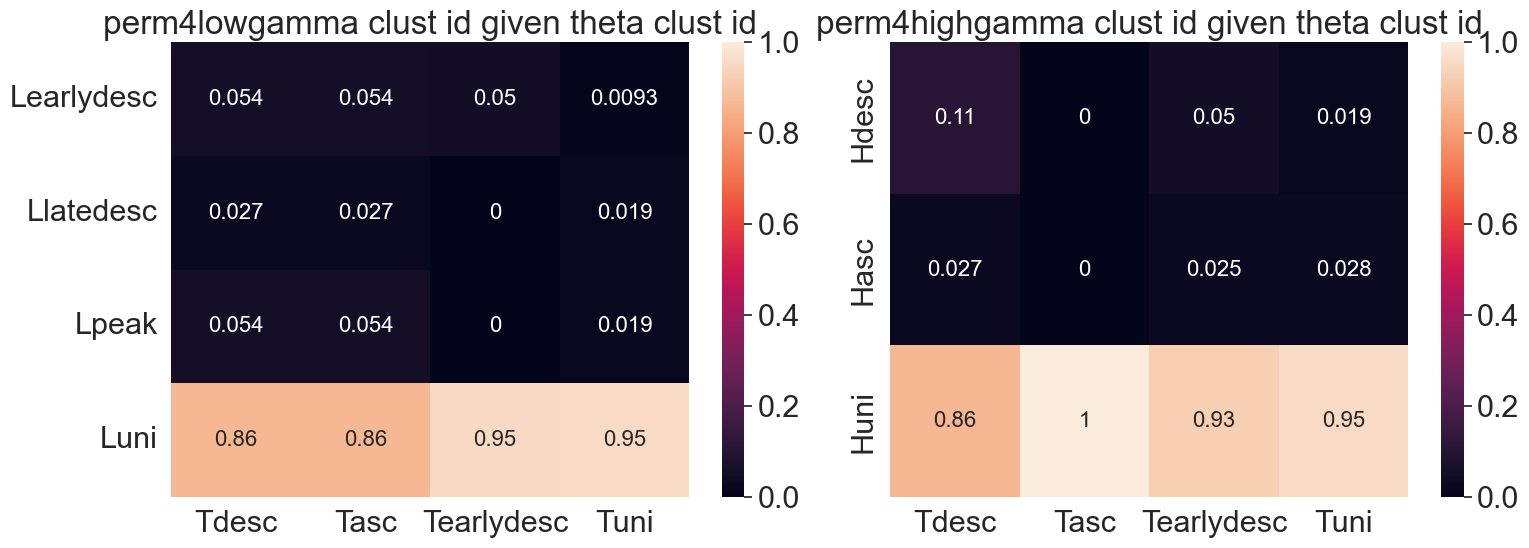

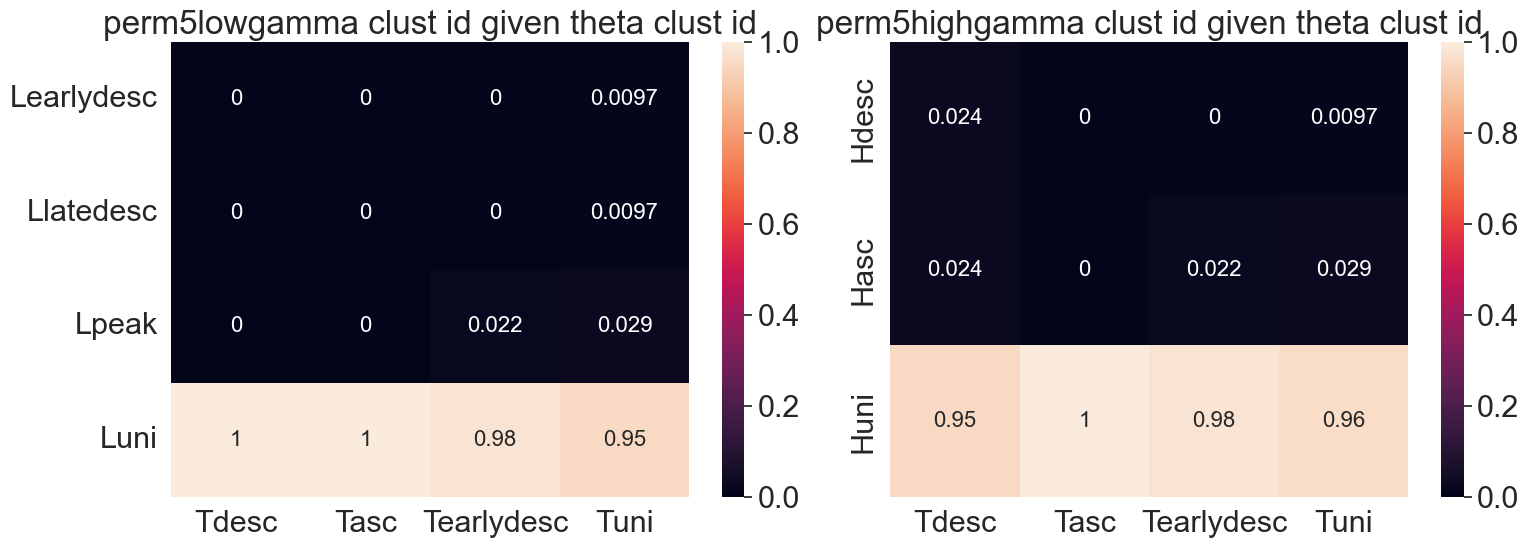

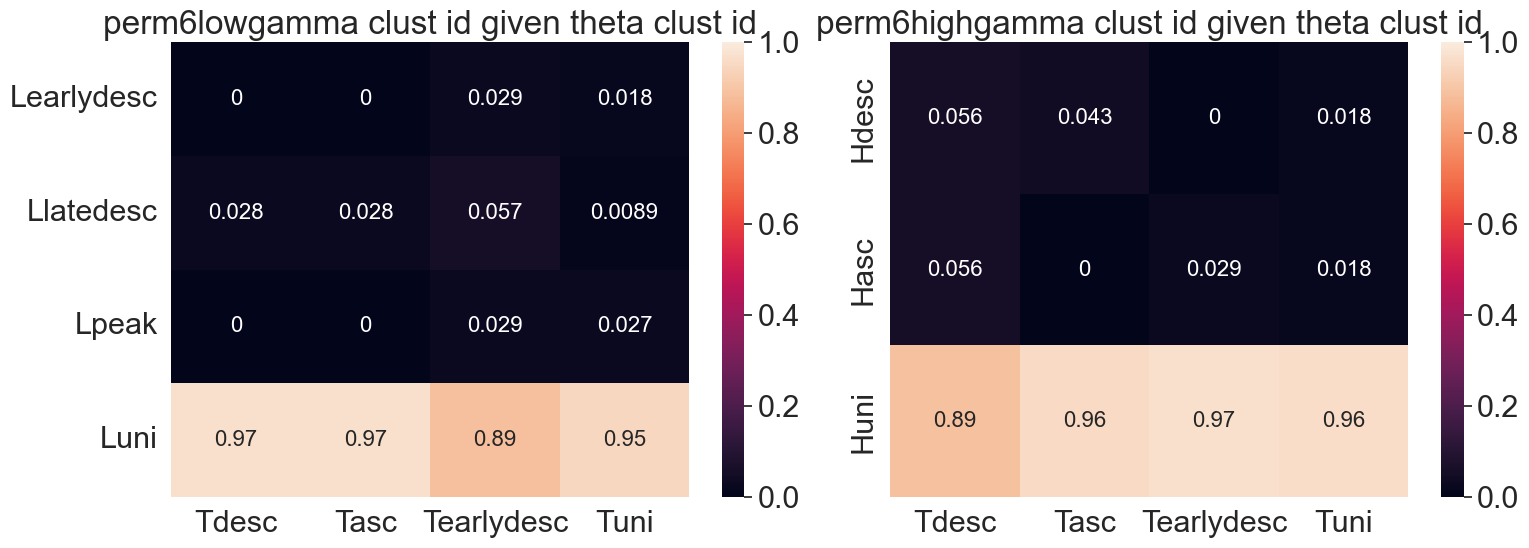

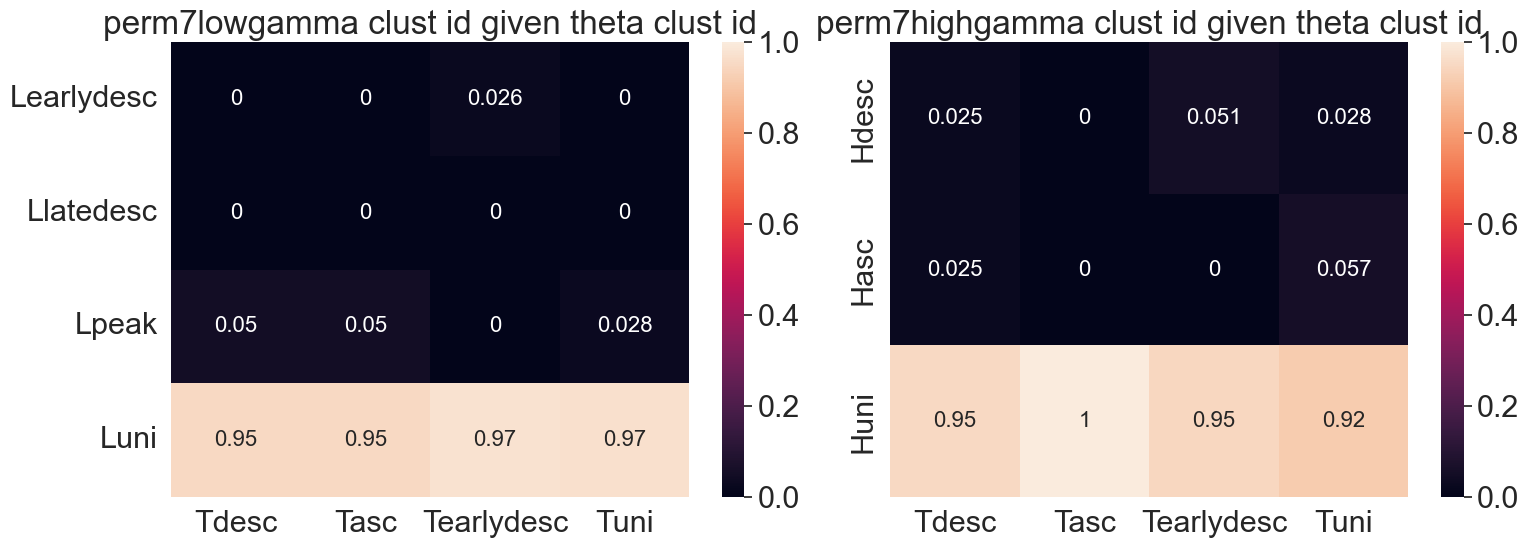

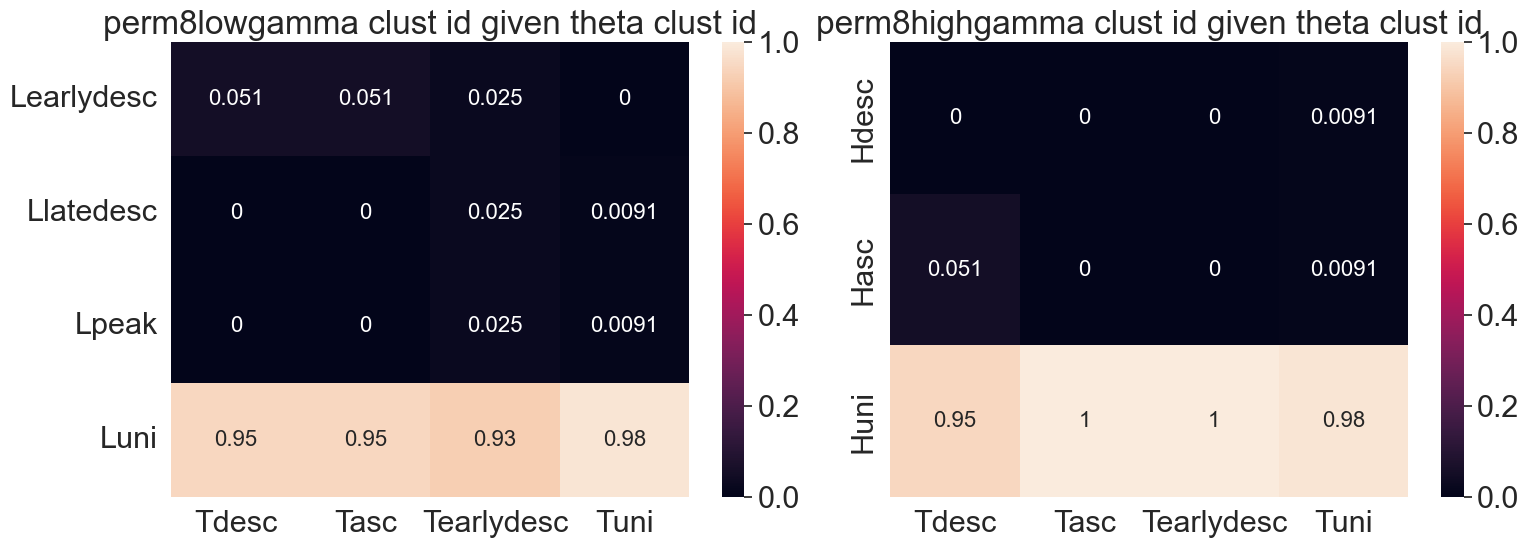

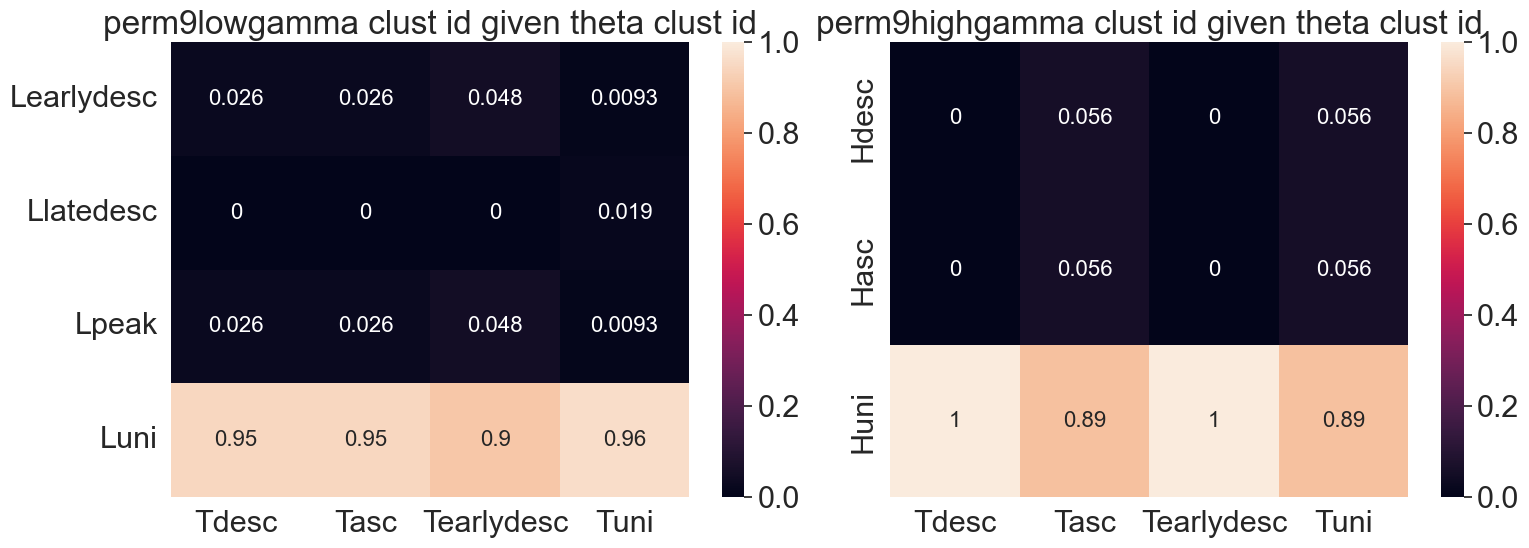

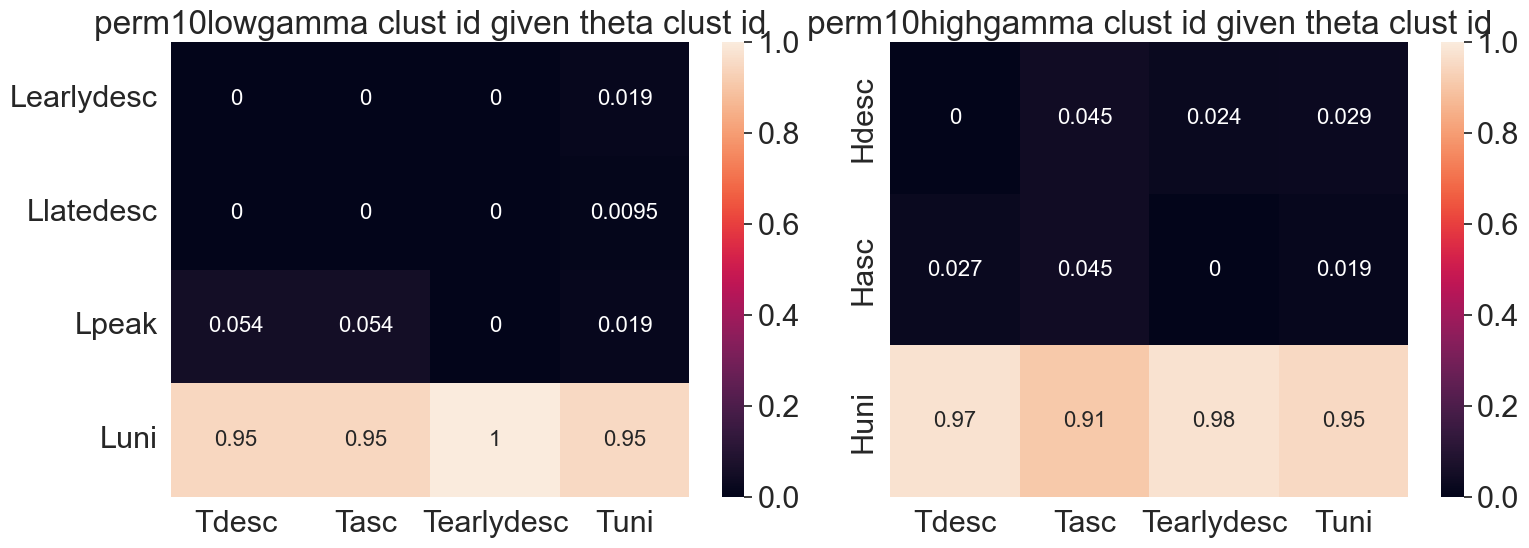

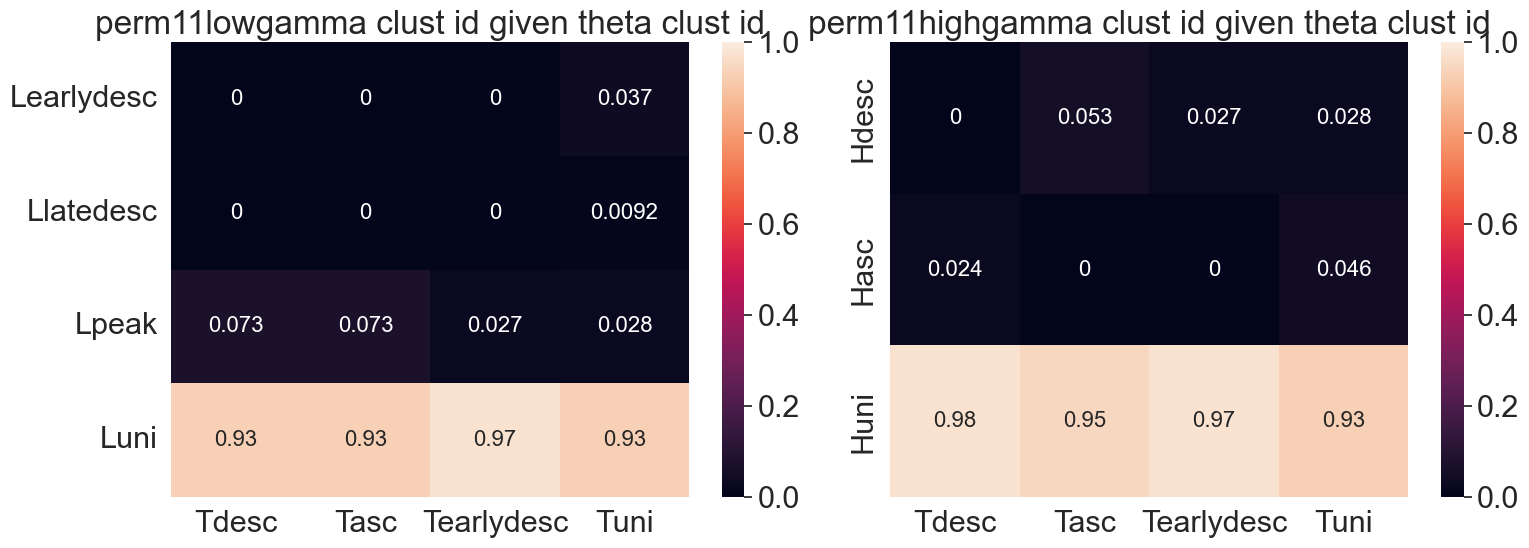

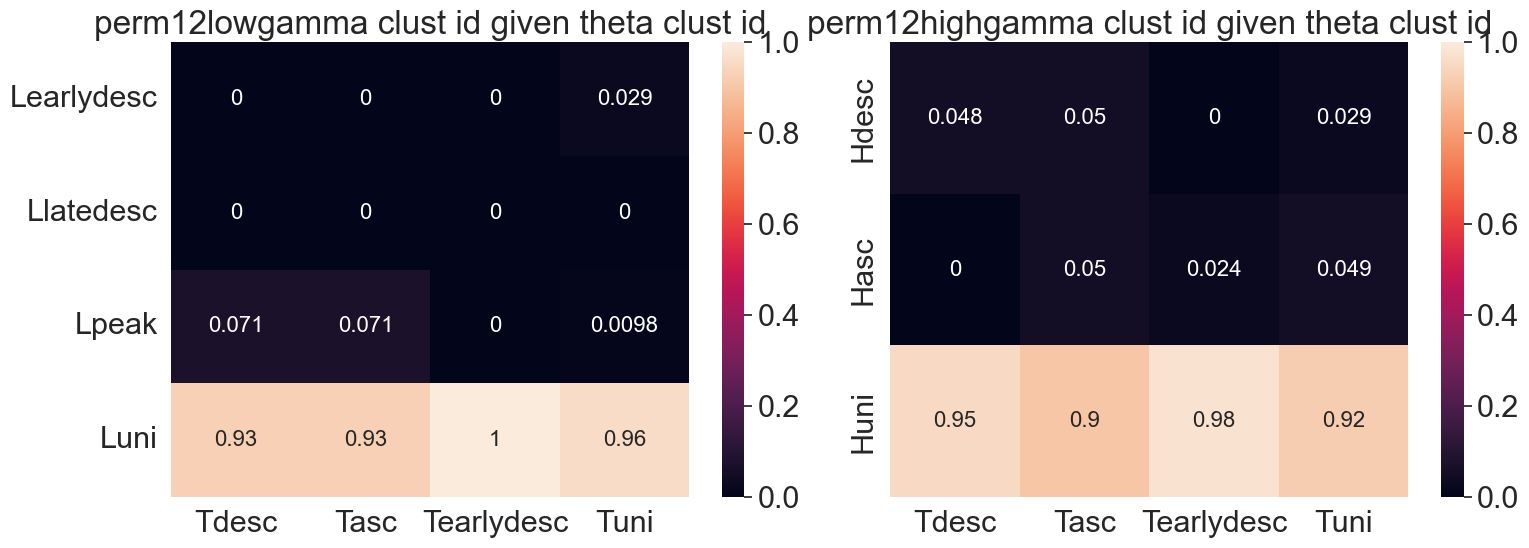

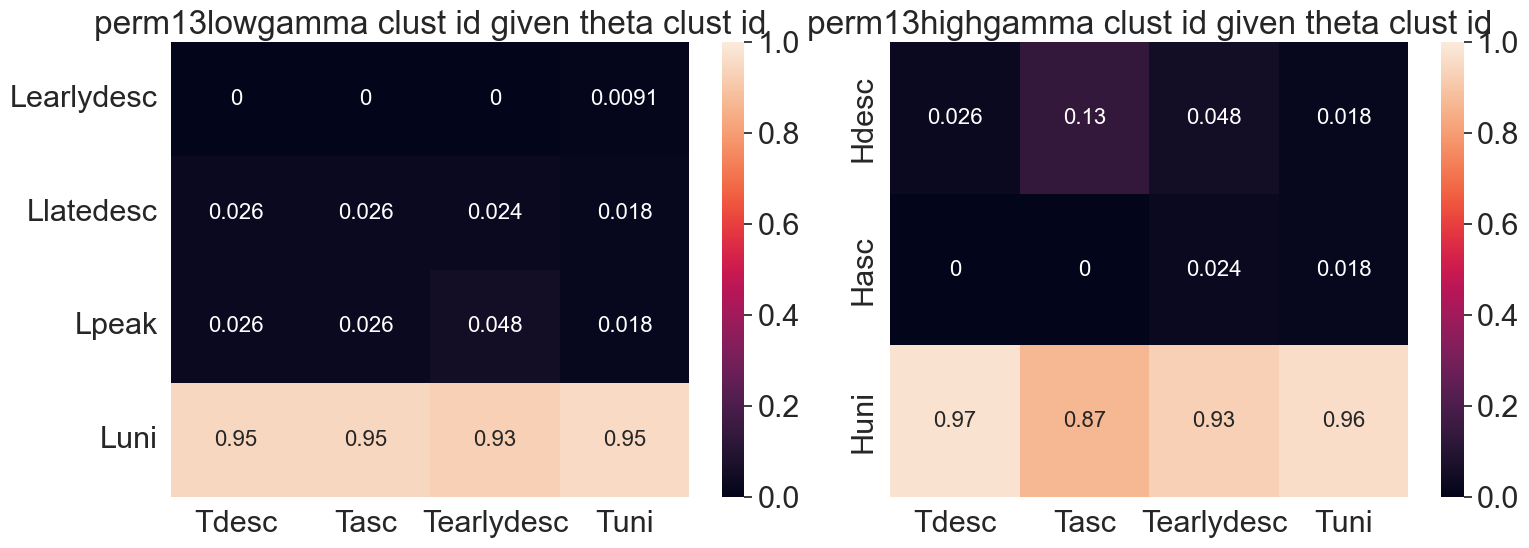

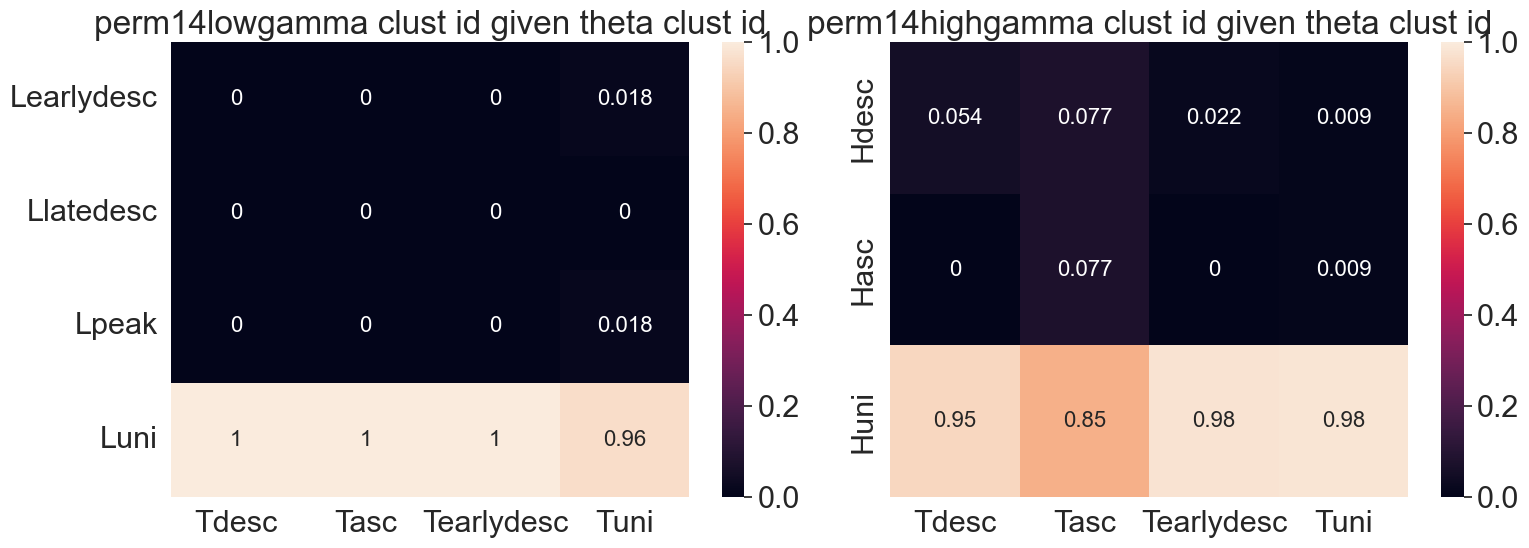

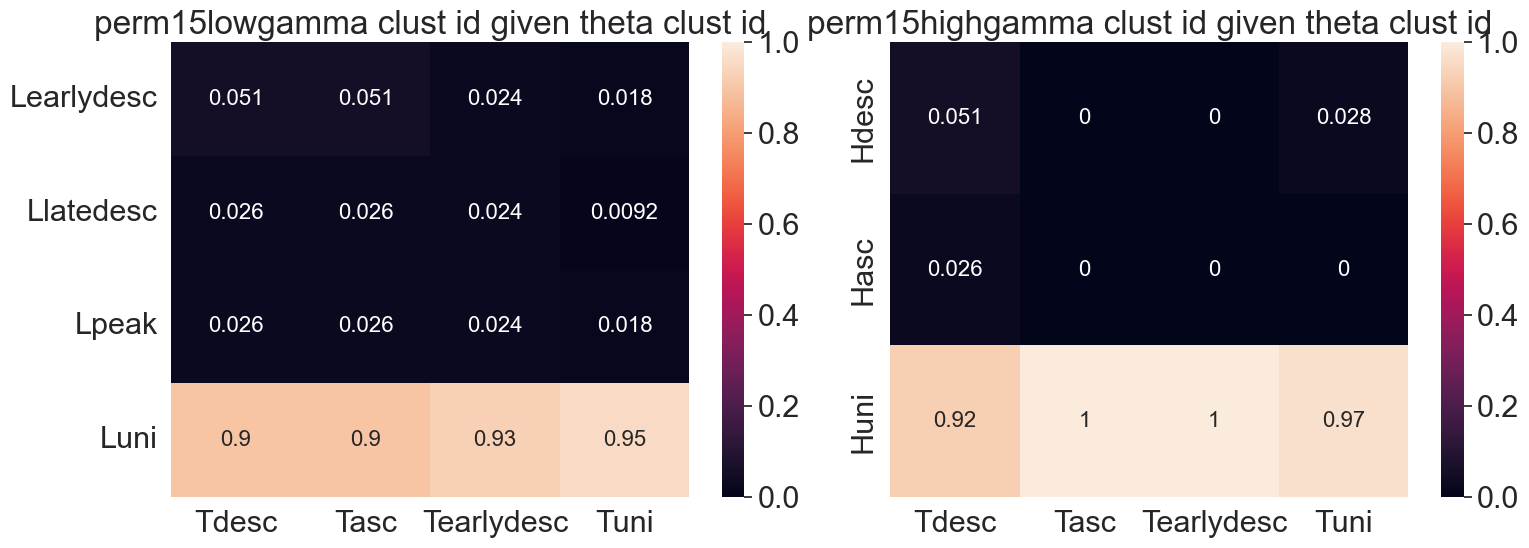

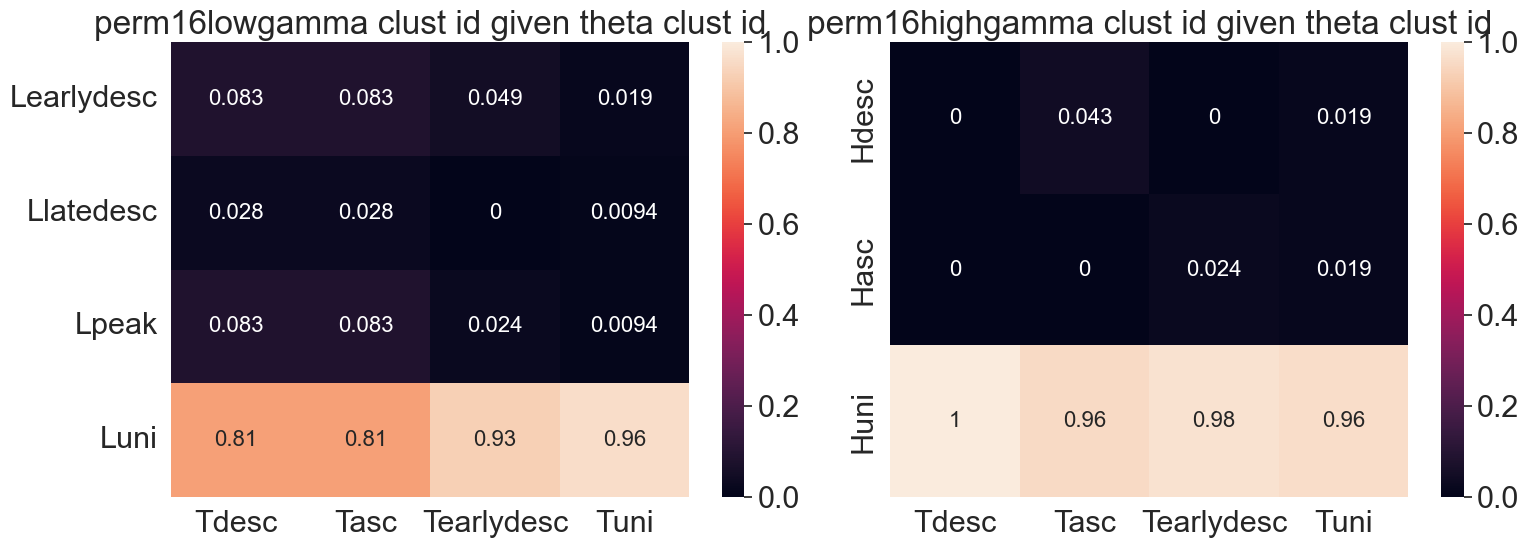

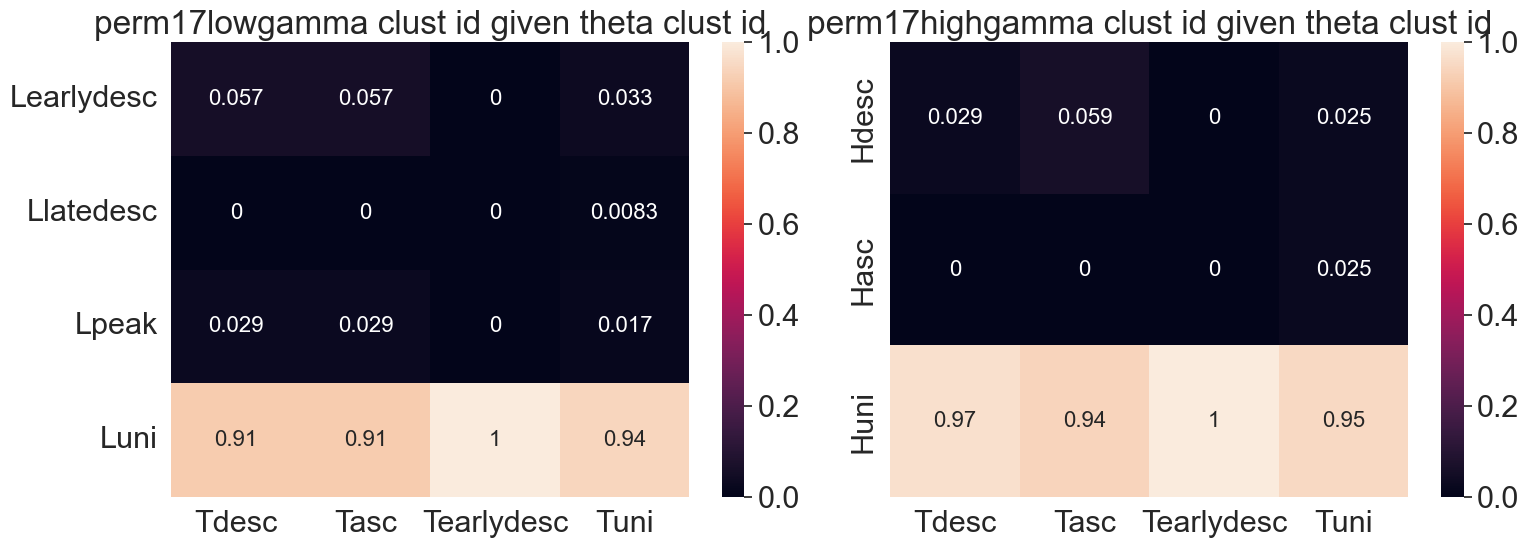

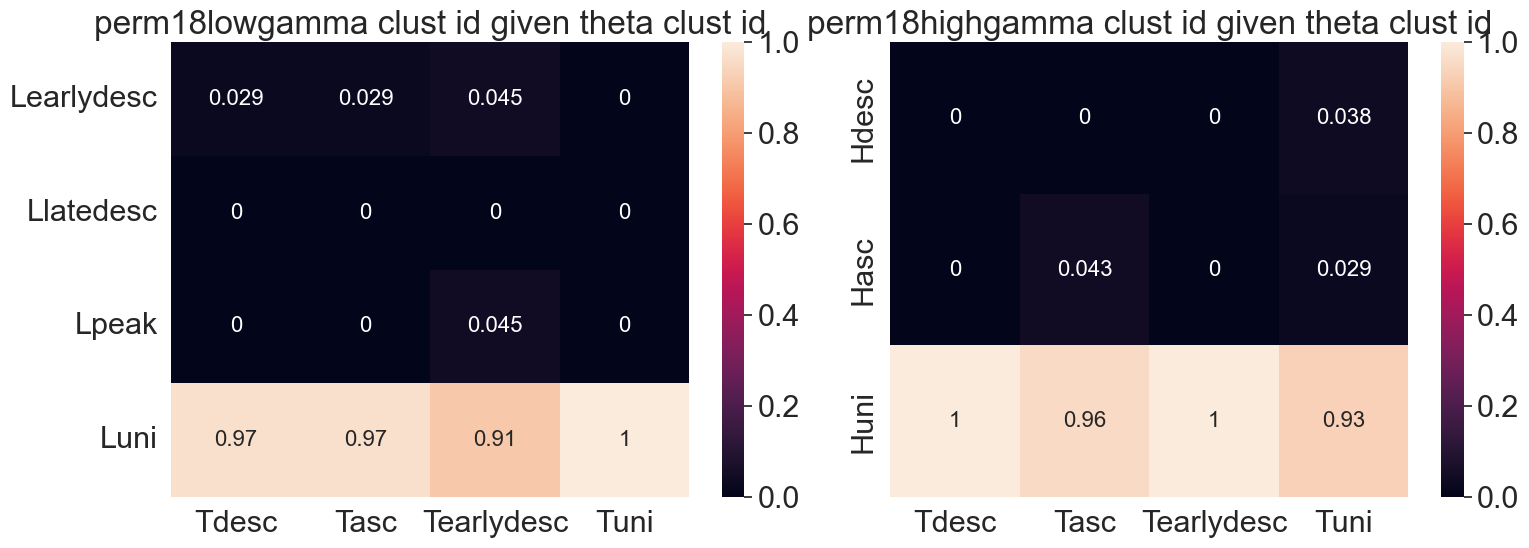

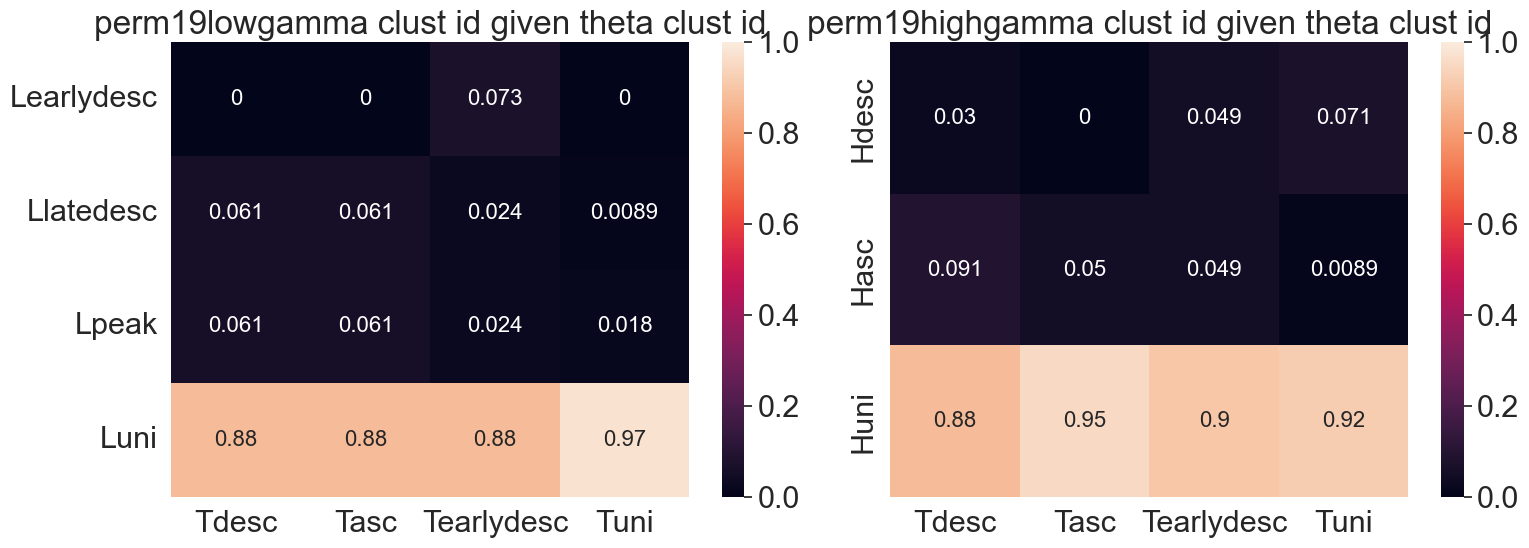

In [126]:
for perm in npermlist: 
    
    subperm = perm_cond_probs[perm_cond_probs['perm']==perm]
    
    L0T0 = subperm['L0T0'].values[0]
    L1T0 = subperm['L1T0'].values[0]
    L2T0 = subperm['L2T0'].values[0]
    L3T0 = subperm['L3T0'].values[0]
    
    L0T1 = subperm['L0T0'].values[0]
    L1T1 = subperm['L1T0'].values[0]
    L2T1 = subperm['L2T0'].values[0]
    L3T1 = subperm['L3T0'].values[0]

    L0T2 = subperm['L0T2'].values[0]
    L1T2 = subperm['L1T2'].values[0]
    L2T2 = subperm['L2T2'].values[0]
    L3T2 = subperm['L3T2'].values[0]
    
    L0T3 = subperm['L0T3'].values[0]
    L1T3 = subperm['L1T3'].values[0]
    L2T3 = subperm['L2T3'].values[0]
    L3T3 = subperm['L3T3'].values[0]
    
    LgivenT = {'Tdesc': [L0T0,L1T0,L2T0,L3T0],
               'Tasc': [L0T1,L1T1,L2T1,L3T1],
               'Tearlydesc': [L0T2,L1T2,L2T2,L3T2],
               'Tuni': [L0T3,L1T3,L2T3,L3T3]
              }
    LgivenT_df = pd.DataFrame(LgivenT)

    T = pd.Series(['Learlydesc','Llatedesc','Lpeak','Luni'])
    LgivenT_df = LgivenT_df.set_index(T)
    
    H0T0 = subperm['H0T0'].values[0]
    H1T0 = subperm['H1T0'].values[0]
    H2T0 = subperm['H2T0'].values[0]
    
    H0T1 = subperm['H0T1'].values[0]
    H1T1 = subperm['H1T1'].values[0]
    H2T1 = subperm['H2T1'].values[0]

    H0T2 = subperm['H0T2'].values[0]
    H1T2 = subperm['H1T2'].values[0]
    H2T2 = subperm['H2T2'].values[0]

    H0T3 = subperm['H0T3'].values[0]
    H1T3 = subperm['H1T3'].values[0]
    H2T3 = subperm['H2T3'].values[0]


    HgivenT = {'Tdesc': [H0T0,H1T0,H2T0],
               'Tasc': [H0T1,H1T1,H2T1],
               'Tearlydesc': [H0T2,H1T2,H2T2],
               'Tuni': [H0T3,H1T3,H2T3]
              }
    HgivenT_df = pd.DataFrame(HgivenT)

    T = pd.Series(['Hdesc','Hasc','Huni'])
    HgivenT_df = HgivenT_df.set_index(T)
    
    sns.set(font_scale=2)
    fig,ax = plt.subplots(1,2,figsize=(16,6))


    g = sns.heatmap(data=LgivenT_df,
                    vmin=0,
                    vmax=1,
                    annot=True,
                    annot_kws={"size": 16},
                    ax=ax[0]
                   ).set_title('perm'+str(perm)+'lowgamma clust id given theta clust id')



    g = sns.heatmap(data=HgivenT_df,
                    vmin=0,
                    vmax=1,
                    annot=True,
                    annot_kws={"size": 16},
                    ax=ax[1]
                   ).set_title('perm'+str(perm)+'highgamma clust id given theta clust id')

    fig.tight_layout()

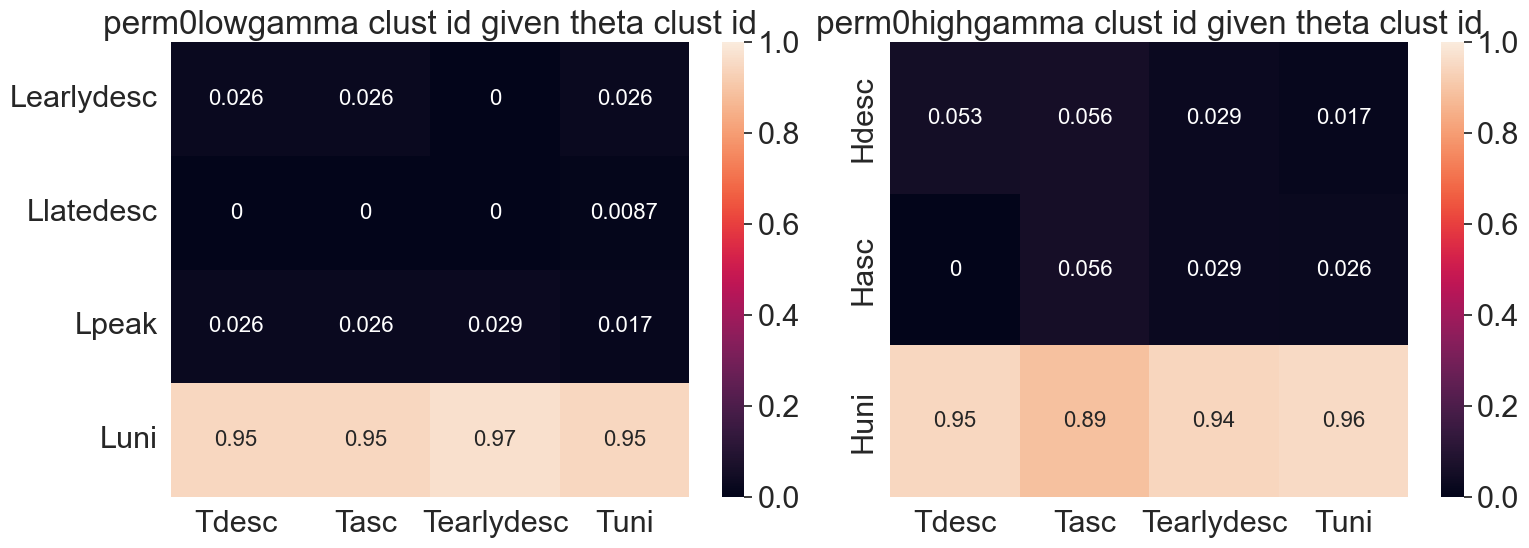

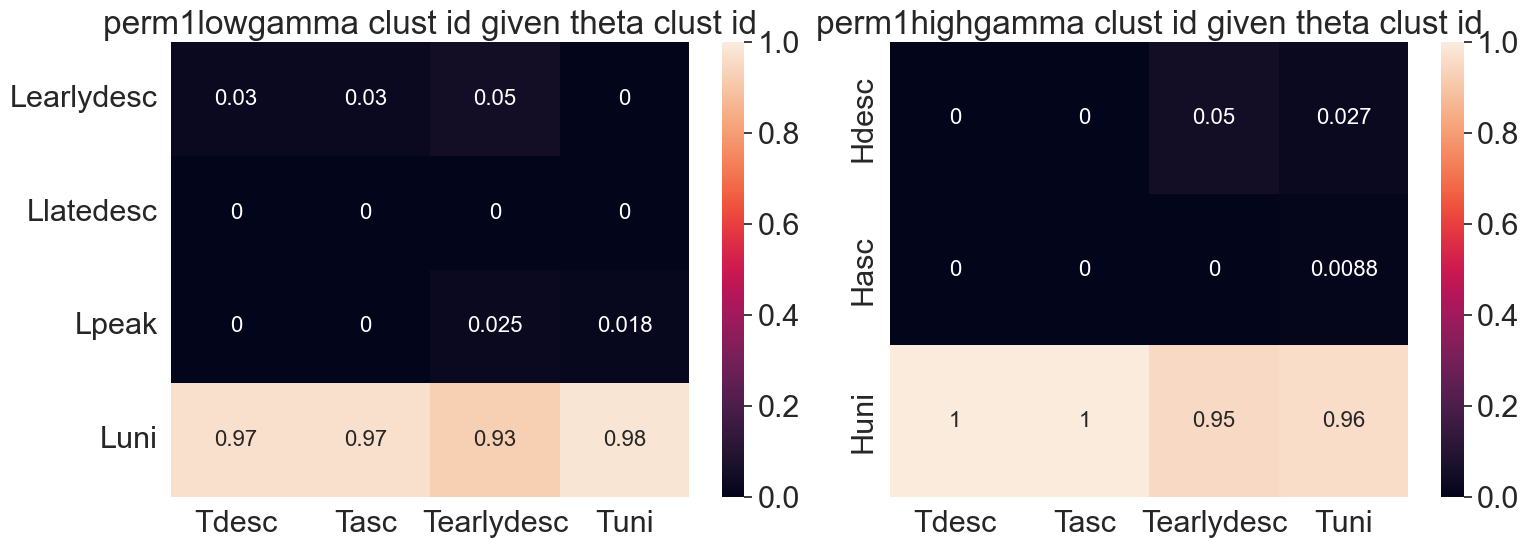

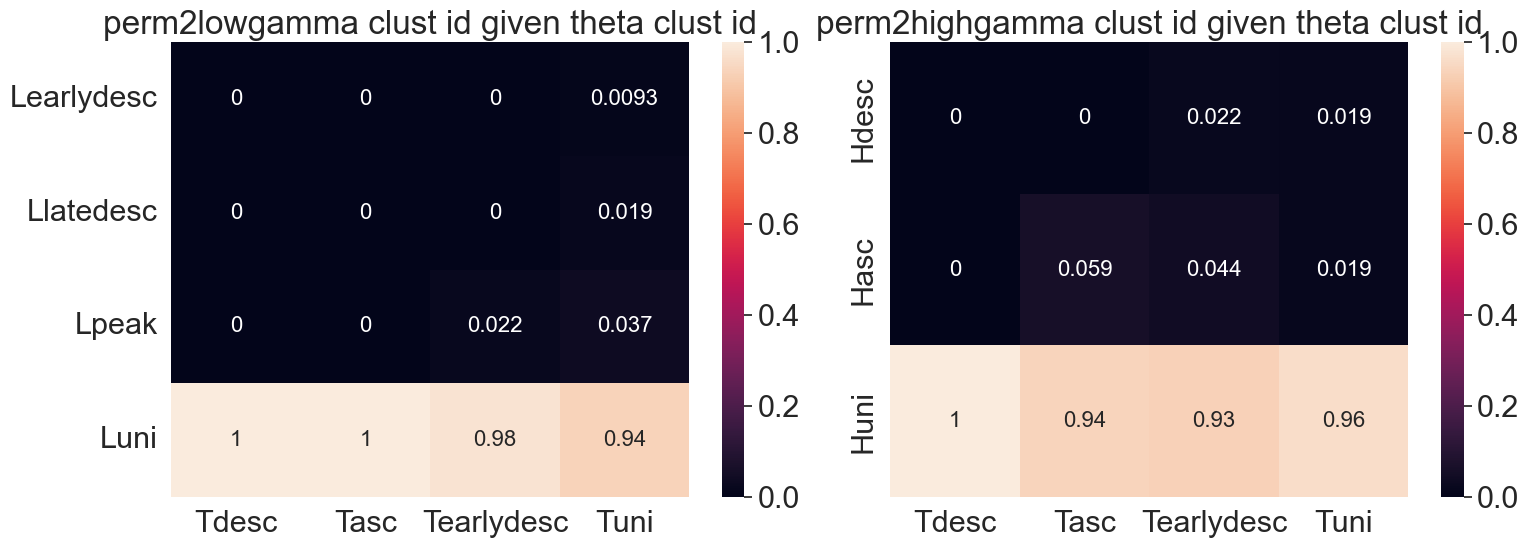

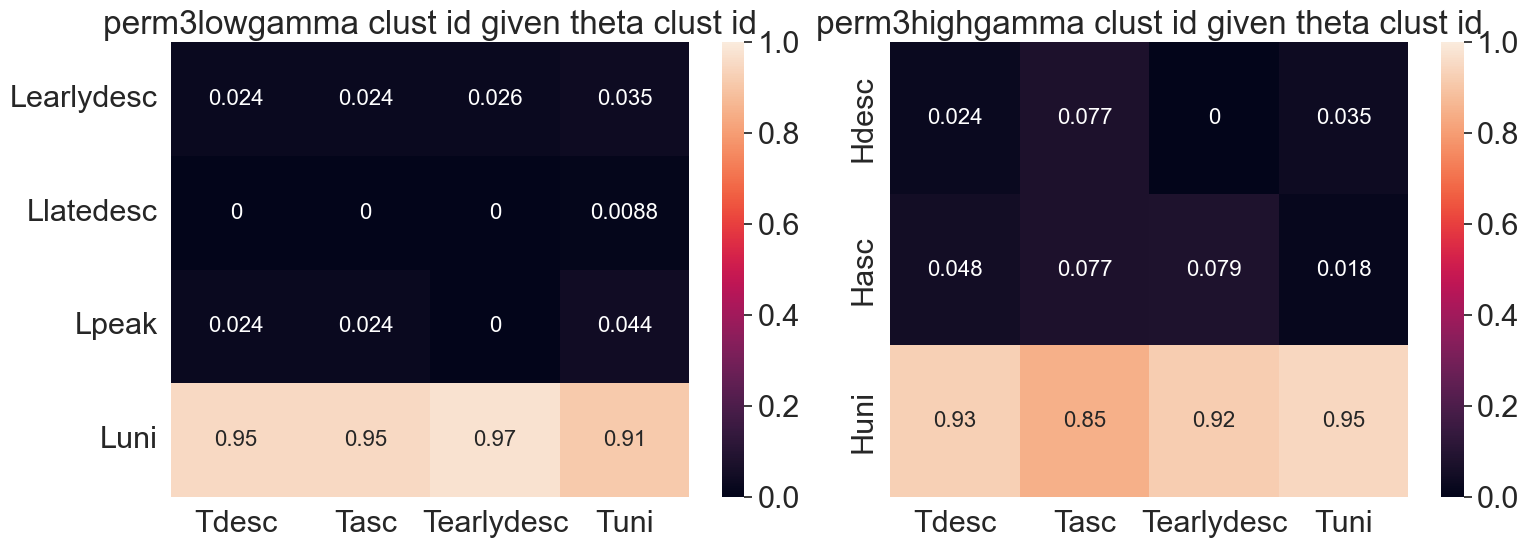

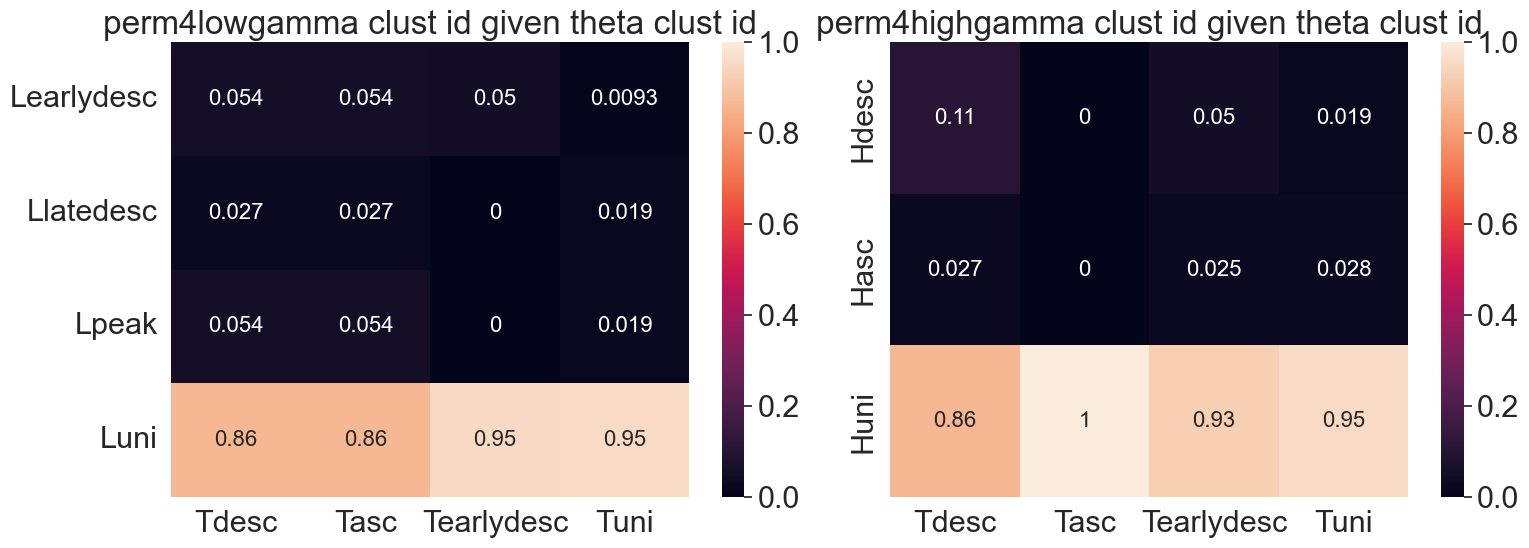

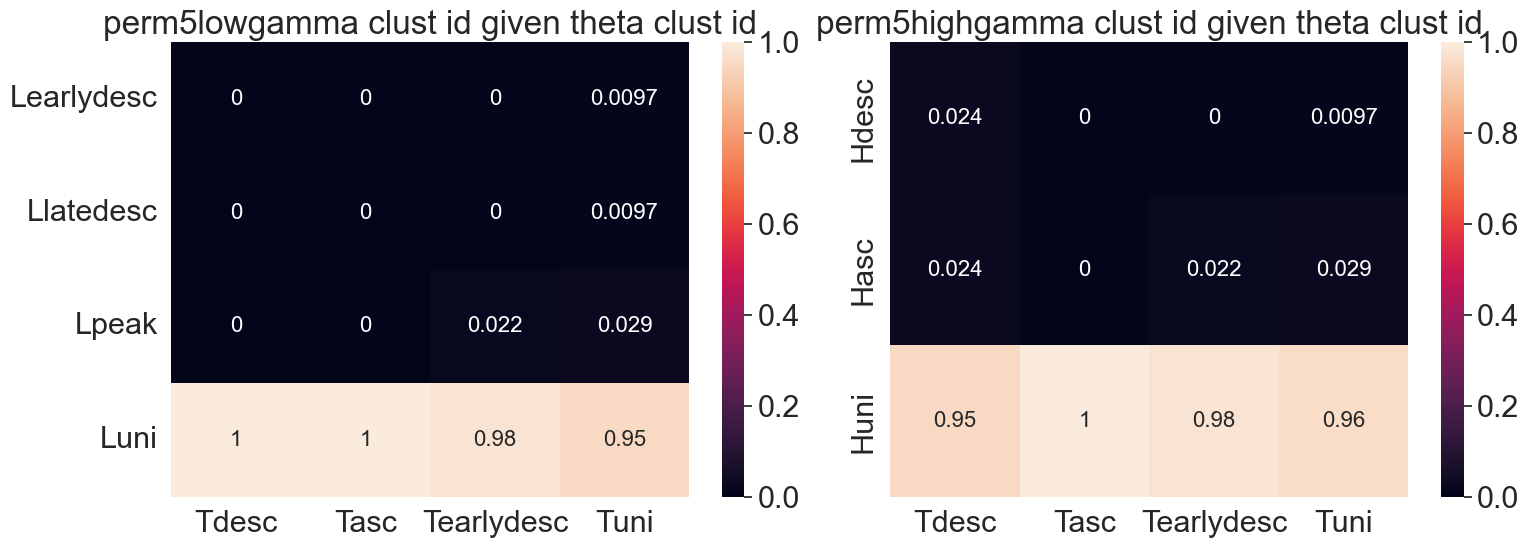

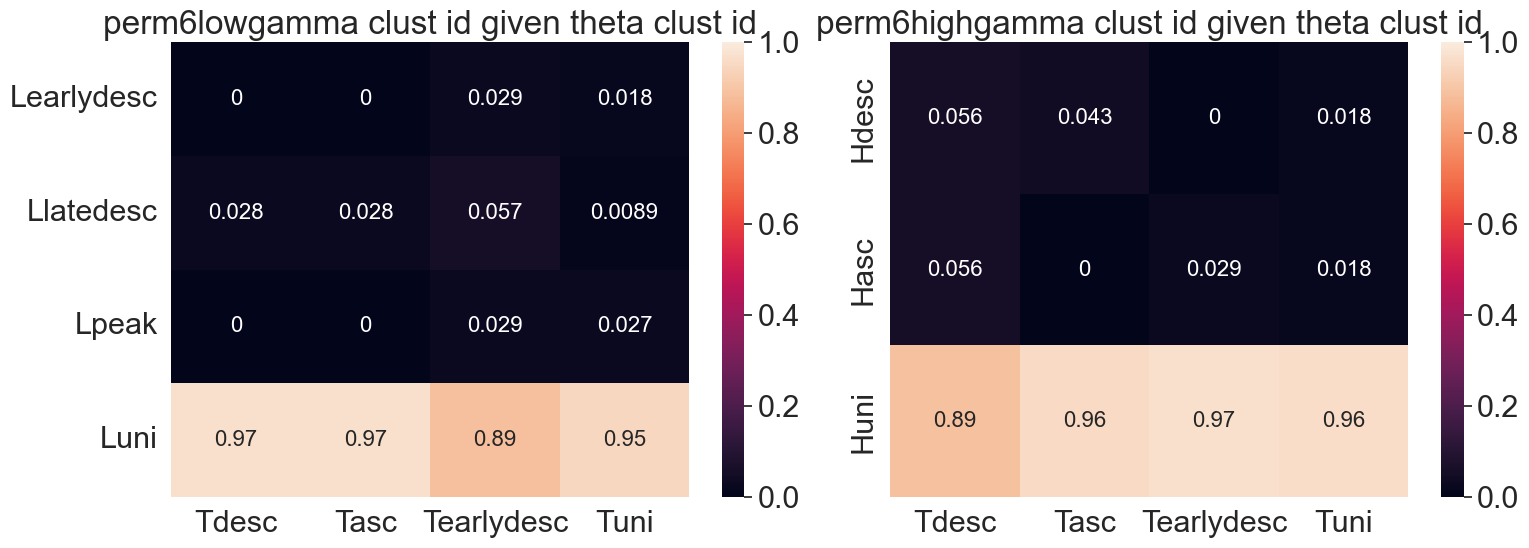

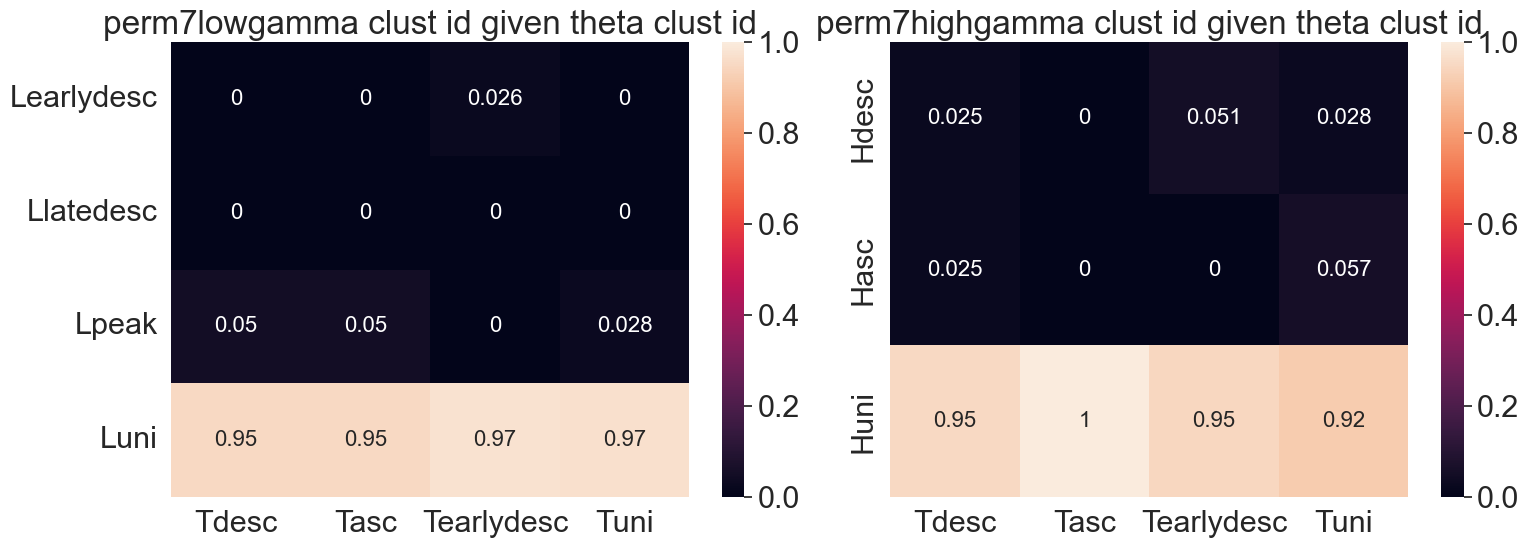

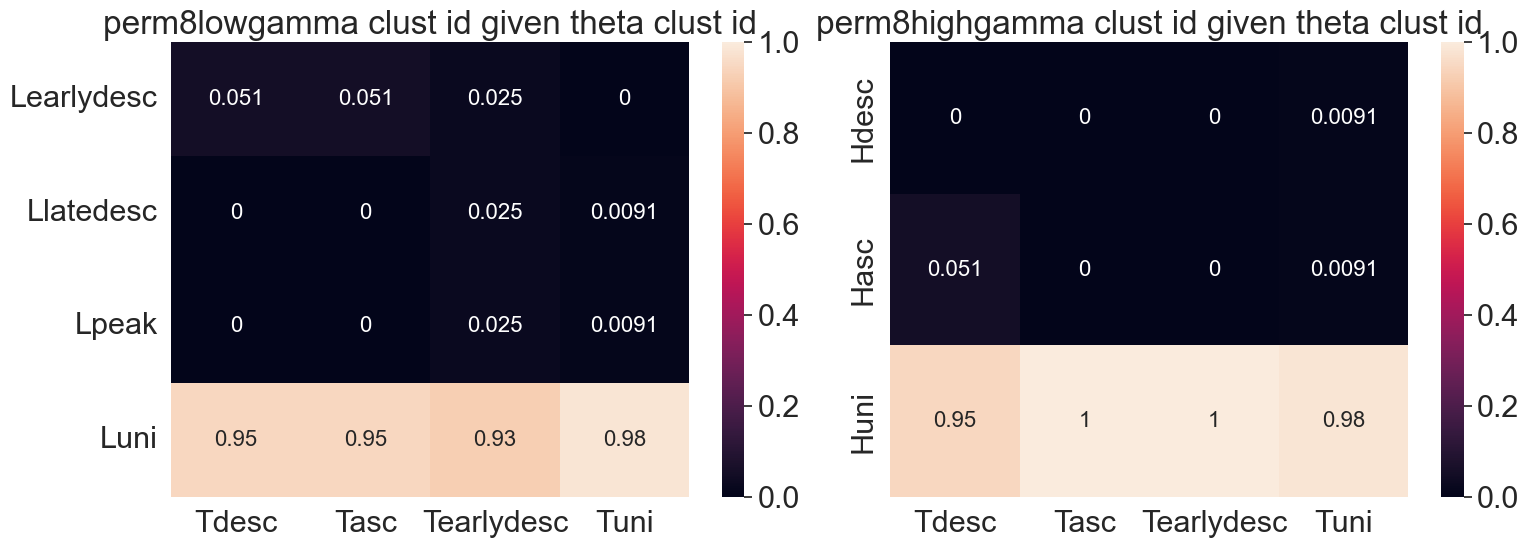

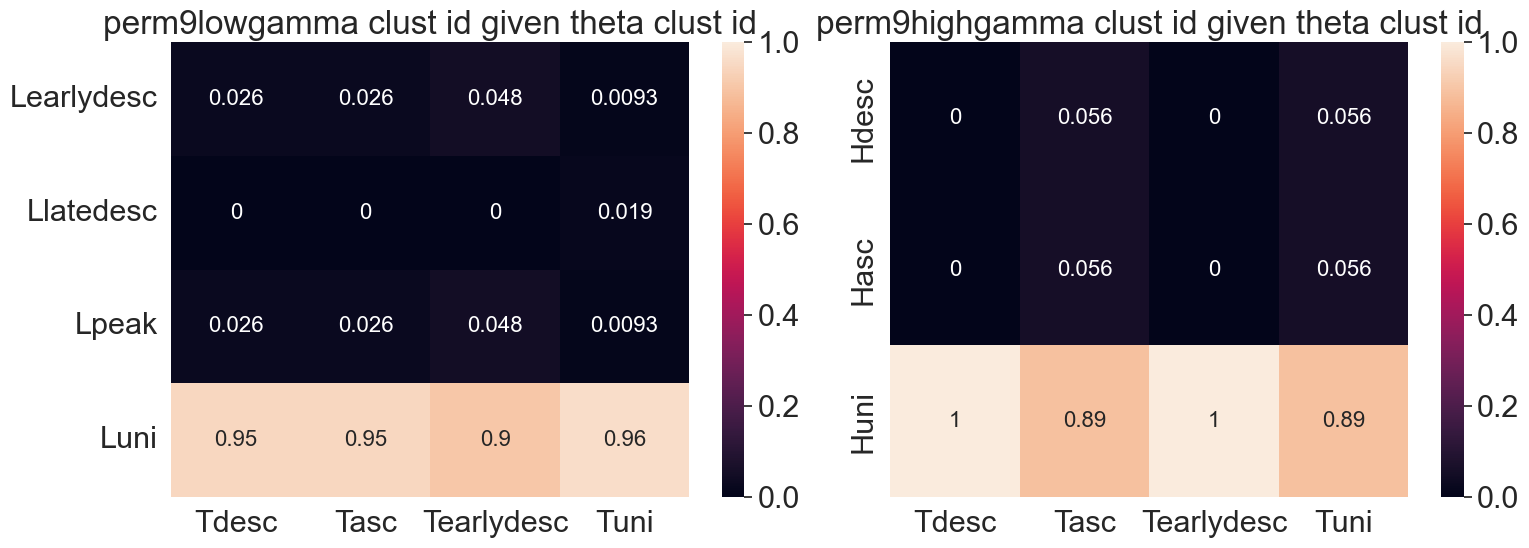

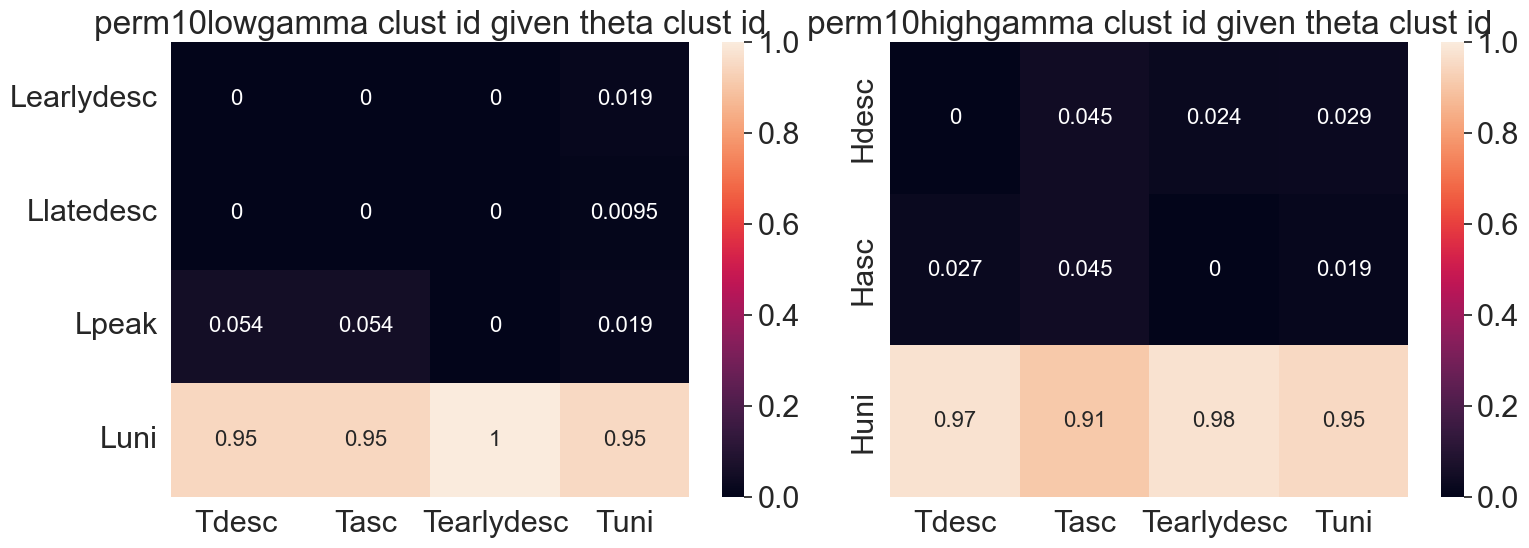

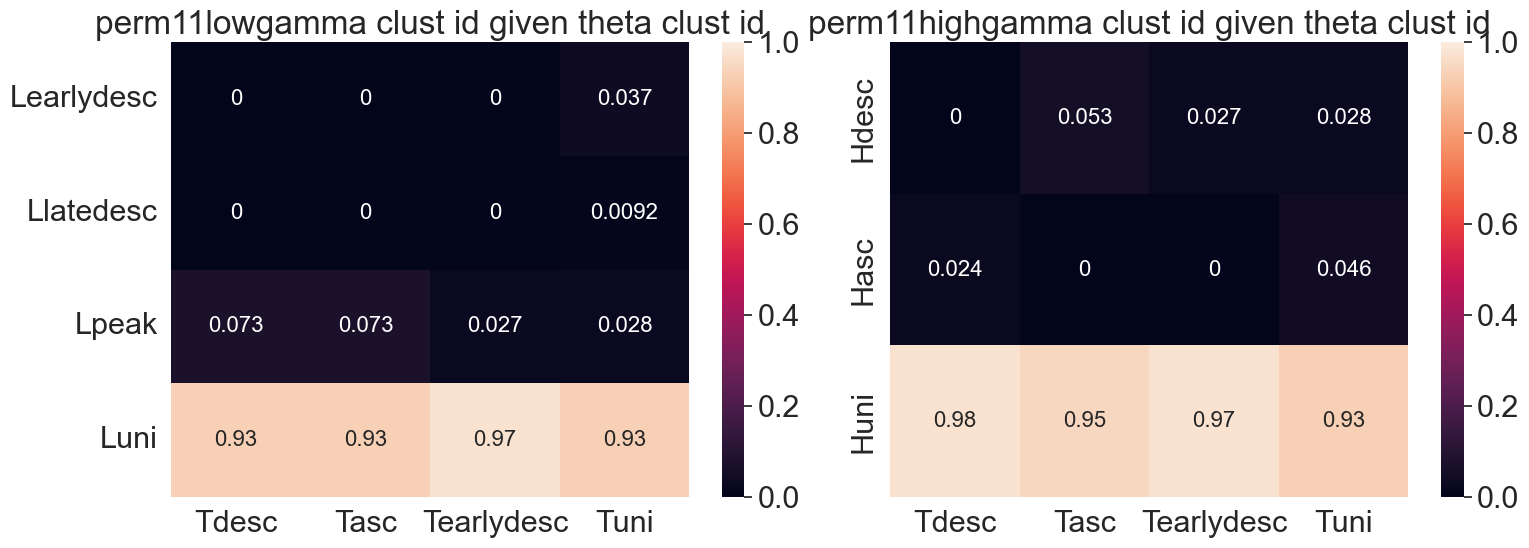

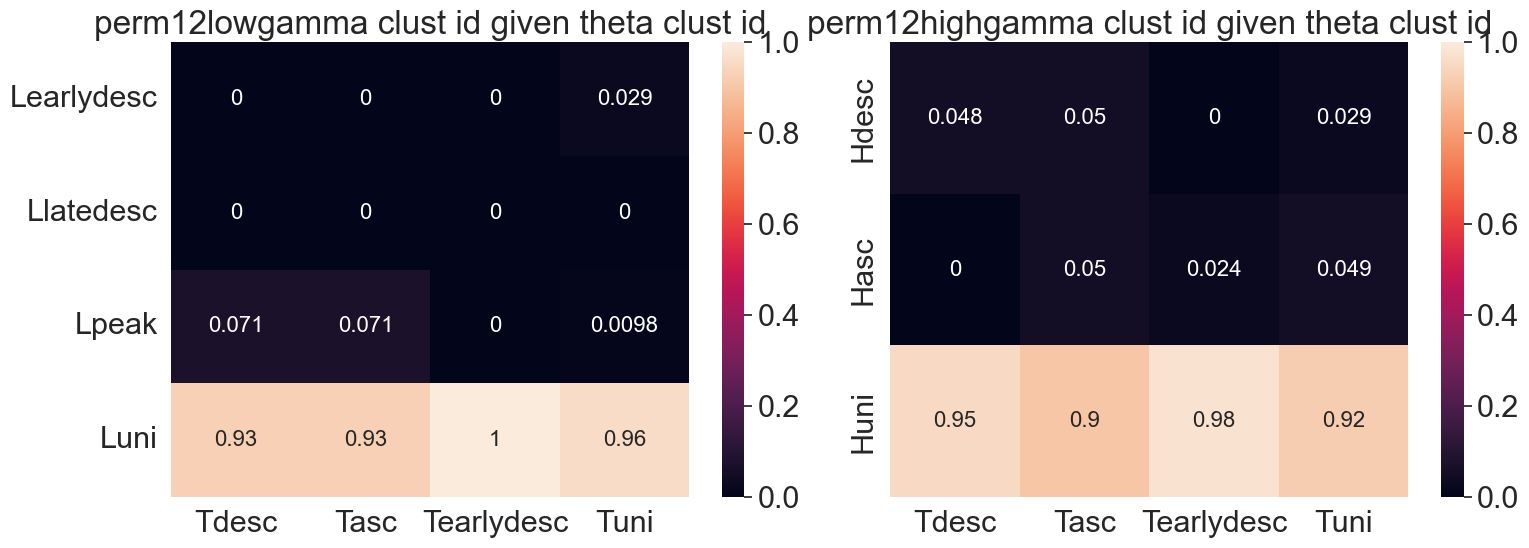

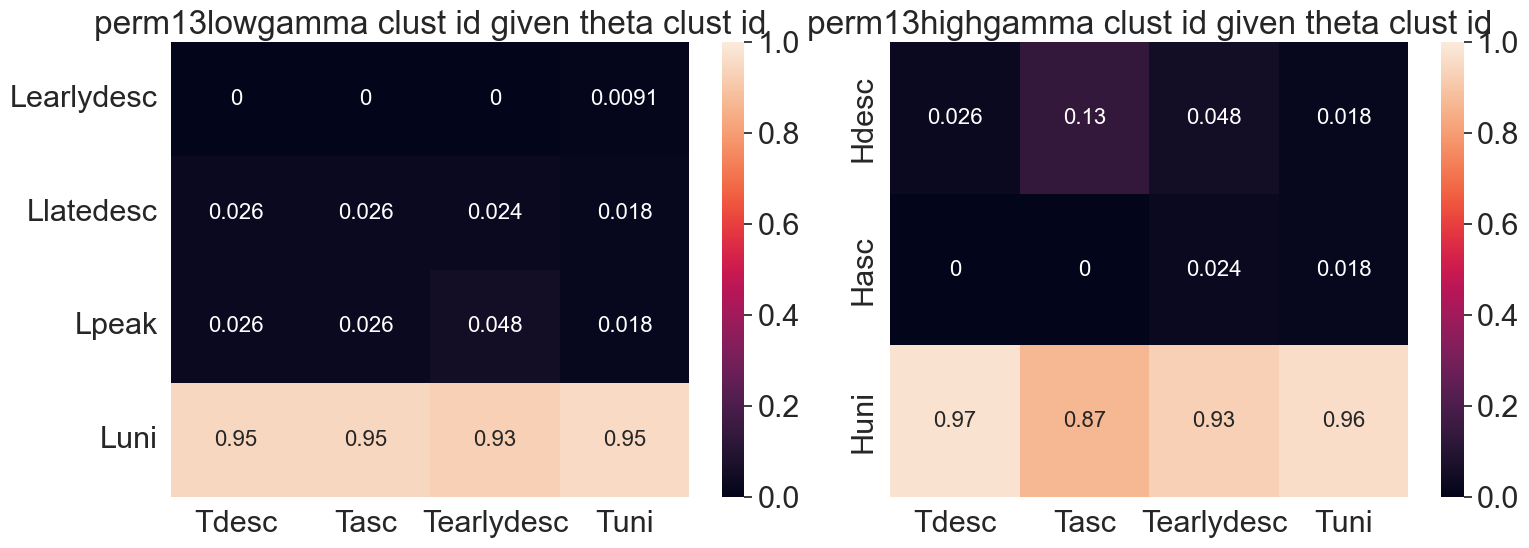

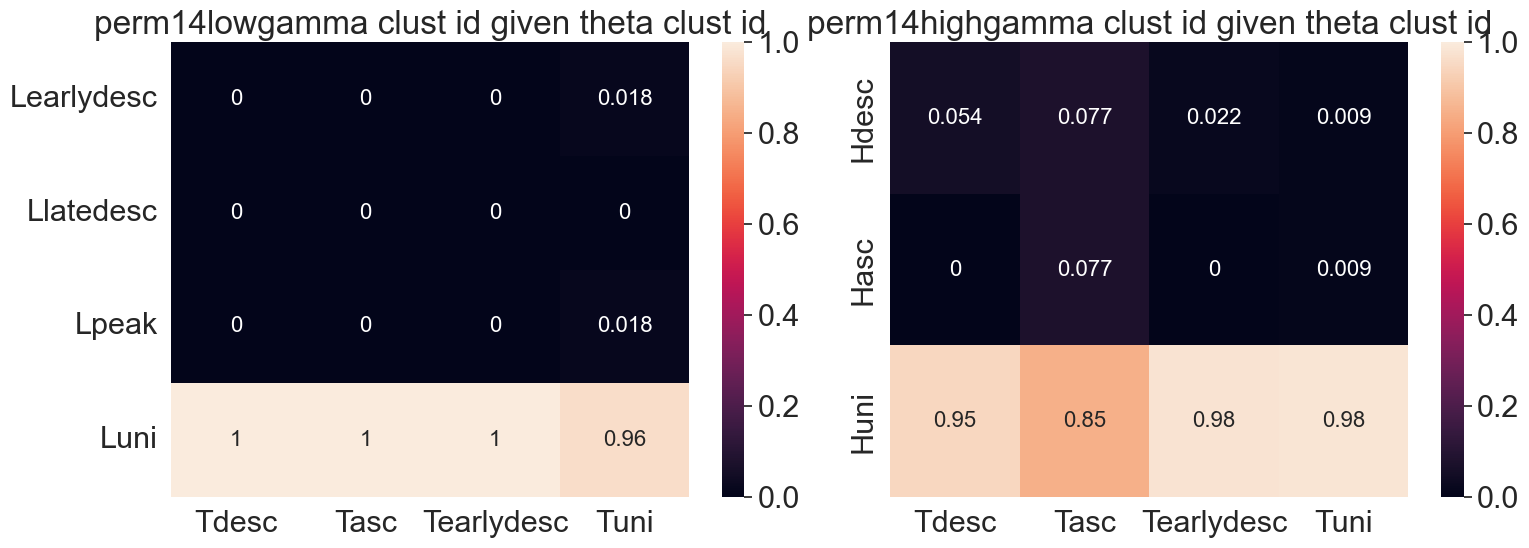

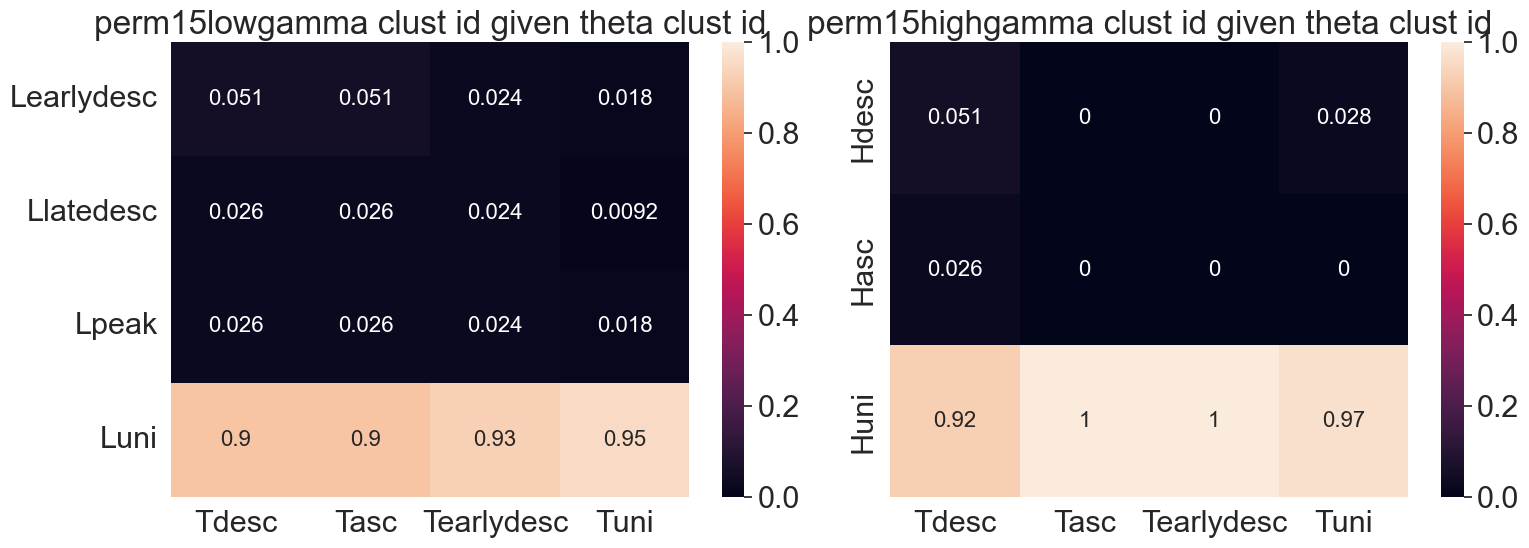

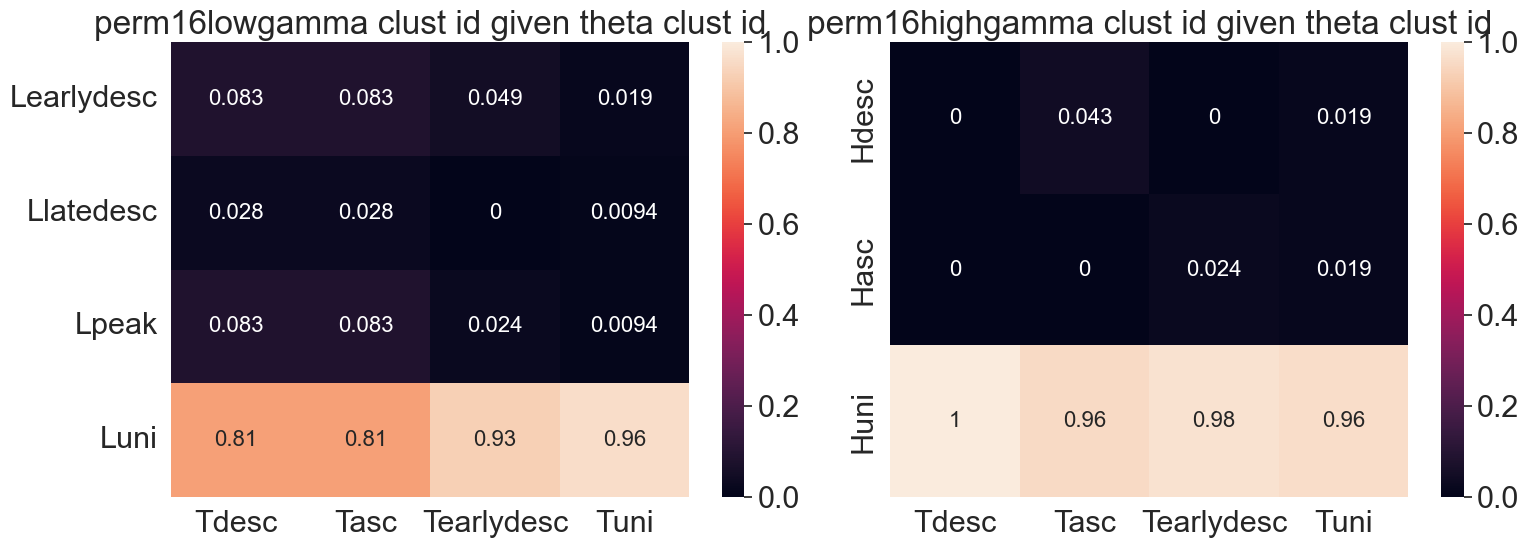

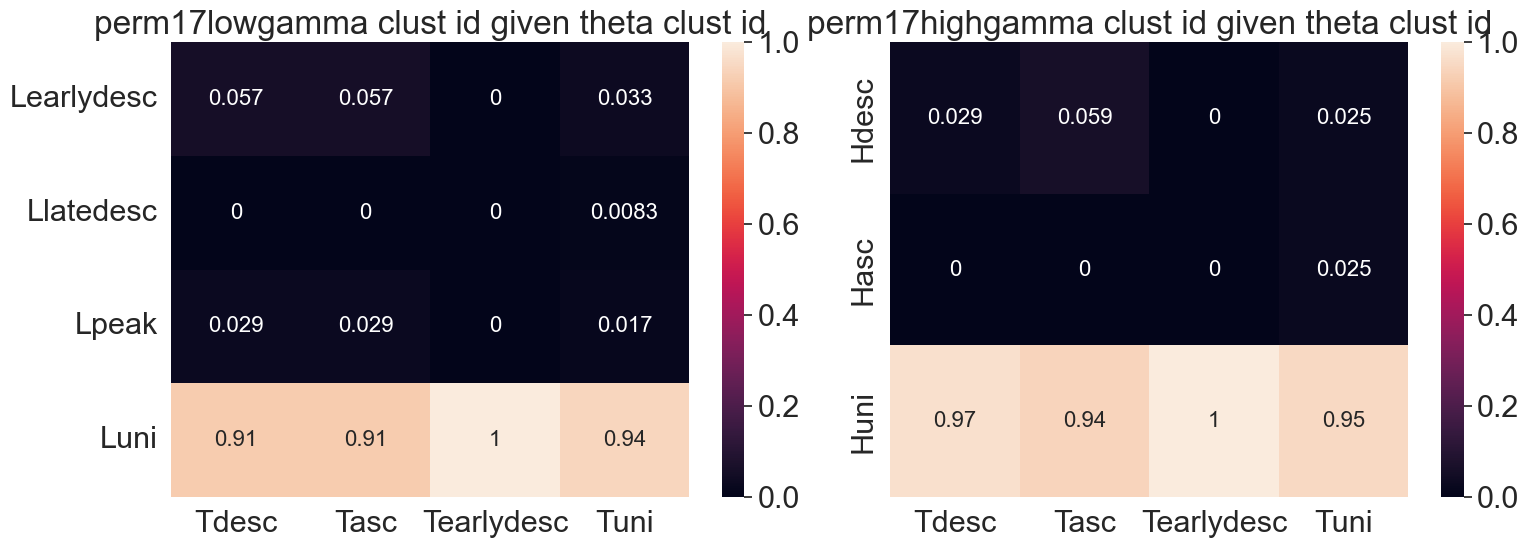

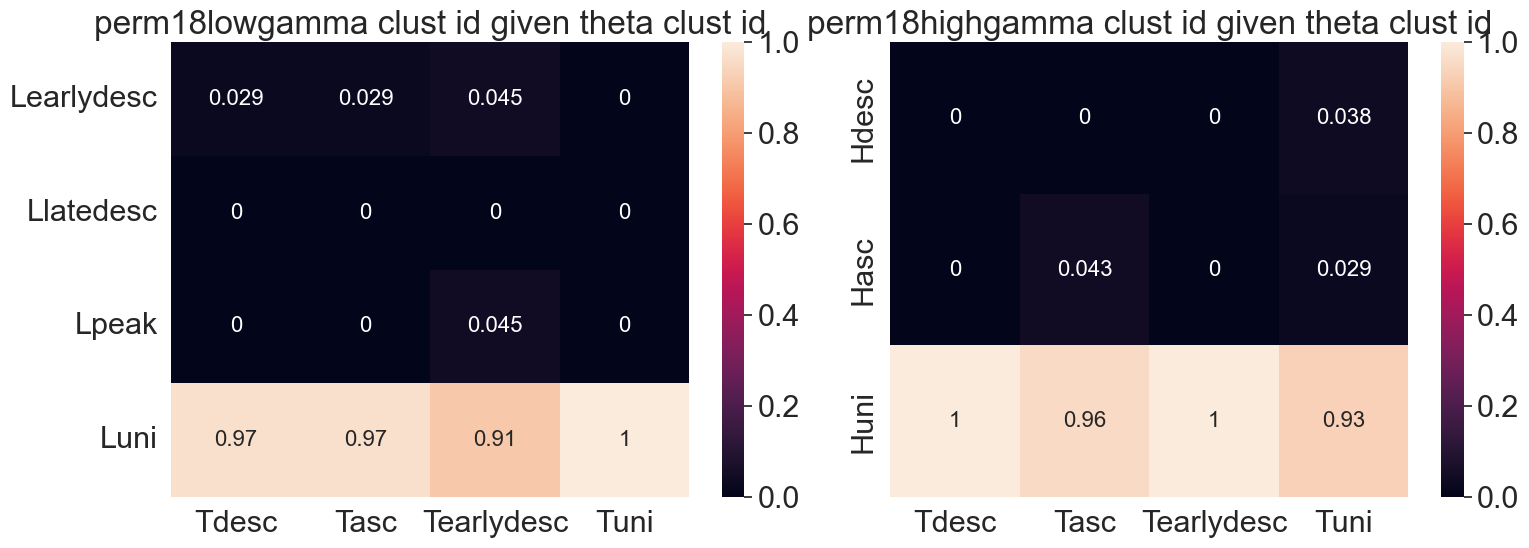

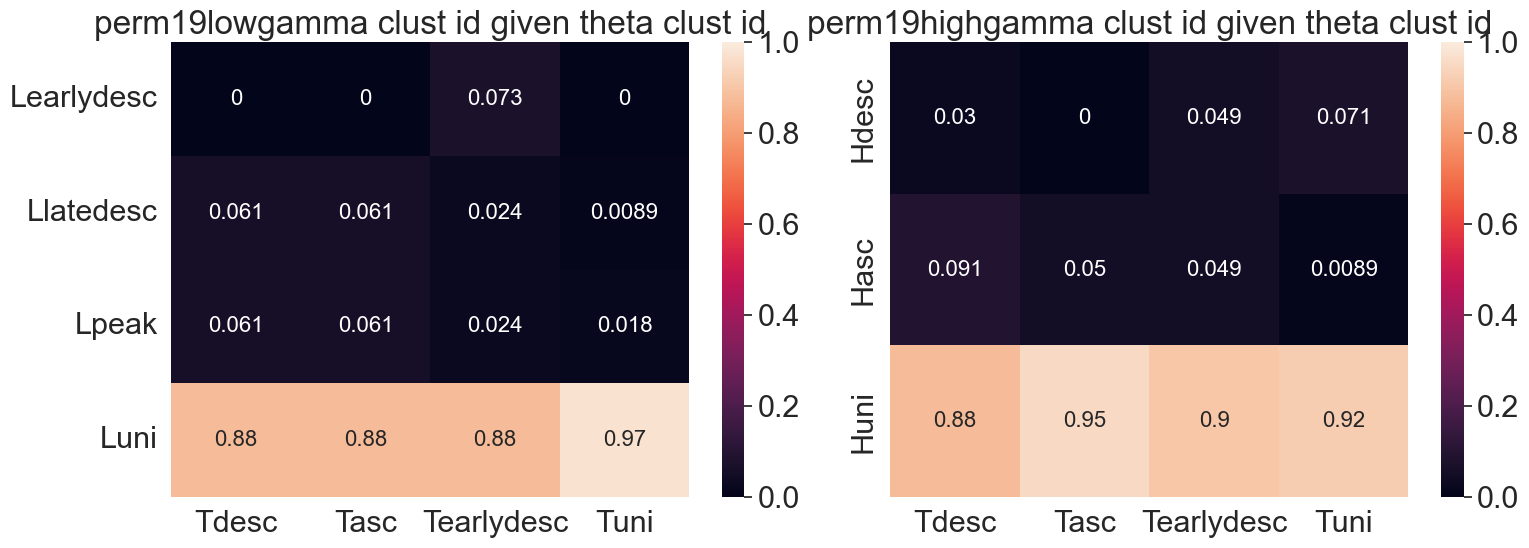

In [127]:
for perm in npermlist: 
    
    subperm = perm_cond_probs[perm_cond_probs['perm']==perm]
    
    L0T0 = subperm['L0T0'].values[0]
    L1T0 = subperm['L1T0'].values[0]
    L2T0 = subperm['L2T0'].values[0]
    L3T0 = subperm['L3T0'].values[0]
    
    L0T1 = subperm['L0T0'].values[0]
    L1T1 = subperm['L1T0'].values[0]
    L2T1 = subperm['L2T0'].values[0]
    L3T1 = subperm['L3T0'].values[0]

    L0T2 = subperm['L0T2'].values[0]
    L1T2 = subperm['L1T2'].values[0]
    L2T2 = subperm['L2T2'].values[0]
    L3T2 = subperm['L3T2'].values[0]
    
    L0T3 = subperm['L0T3'].values[0]
    L1T3 = subperm['L1T3'].values[0]
    L2T3 = subperm['L2T3'].values[0]
    L3T3 = subperm['L3T3'].values[0]
    
    LgivenT = {'Tdesc': [L0T0,L1T0,L2T0,L3T0],
               'Tasc': [L0T1,L1T1,L2T1,L3T1],
               'Tearlydesc': [L0T2,L1T2,L2T2,L3T2],
               'Tuni': [L0T3,L1T3,L2T3,L3T3]
              }
    LgivenT_df = pd.DataFrame(LgivenT)

    T = pd.Series(['Learlydesc','Llatedesc','Lpeak','Luni'])
    LgivenT_df = LgivenT_df.set_index(T)
    
    H0T0 = subperm['H0T0'].values[0]
    H1T0 = subperm['H1T0'].values[0]
    H2T0 = subperm['H2T0'].values[0]
    
    H0T1 = subperm['H0T1'].values[0]
    H1T1 = subperm['H1T1'].values[0]
    H2T1 = subperm['H2T1'].values[0]

    H0T2 = subperm['H0T2'].values[0]
    H1T2 = subperm['H1T2'].values[0]
    H2T2 = subperm['H2T2'].values[0]

    H0T3 = subperm['H0T3'].values[0]
    H1T3 = subperm['H1T3'].values[0]
    H2T3 = subperm['H2T3'].values[0]


    HgivenT = {'Tdesc': [H0T0,H1T0,H2T0],
               'Tasc': [H0T1,H1T1,H2T1],
               'Tearlydesc': [H0T2,H1T2,H2T2],
               'Tuni': [H0T3,H1T3,H2T3]
              }
    HgivenT_df = pd.DataFrame(HgivenT)

    T = pd.Series(['Hdesc','Hasc','Huni'])
    HgivenT_df = HgivenT_df.set_index(T)
    
    sns.set(font_scale=2)
    fig,ax = plt.subplots(1,2,figsize=(16,6))


    g = sns.heatmap(data=LgivenT_df,
                    vmin=0,
                    vmax=1,
                    annot=True,
                    annot_kws={"size": 16},
                    ax=ax[0]
                   ).set_title('perm'+str(perm)+'lowgamma clust id given theta clust id')



    g = sns.heatmap(data=HgivenT_df,
                    vmin=0,
                    vmax=1,
                    annot=True,
                    annot_kws={"size": 16},
                    ax=ax[1]
                   ).set_title('perm'+str(perm)+'highgamma clust id given theta clust id')

    fig.tight_layout()

### Supplementary Figure 2A (top matrix)

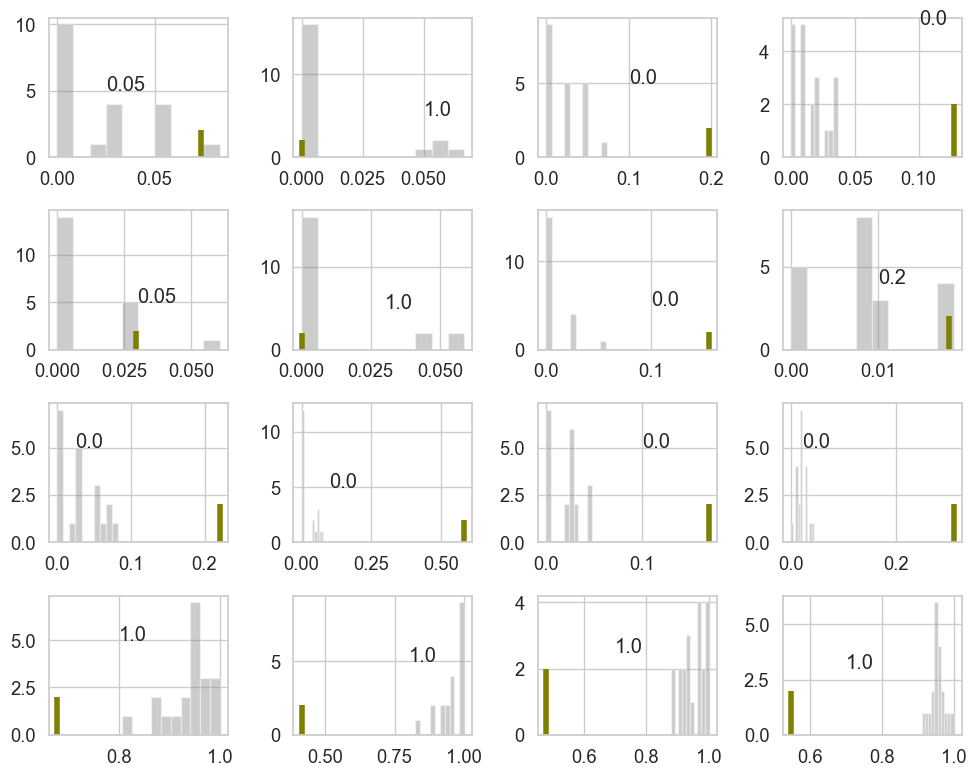

In [142]:
sns.set(style='whitegrid',font_scale=1.2)
fig,ax = plt.subplots(4,4,figsize=(10,8))

ax[0][0].hist(perm_cond_probs['L0T0'].values,alpha=0.4,color='grey')
ax[0][0].vlines(x=trueL0T0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L0T0'].values if i>=trueL0T0]
p_geq_L0T0 =  len(geq) / len(perm_cond_probs['L0T0'].values)
ax[0][0].text(0.025,5,str(p_geq_L0T0))

ax[0][1].hist(perm_cond_probs['L0T1'].values,alpha=0.4,color='grey')
ax[0][1].vlines(x=trueL0T1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L0T1'].values if i>=trueL0T1]
p_geq_L0T1 =  len(geq) / len(perm_cond_probs['L0T1'].values)
ax[0][1].text(0.05,5,str(p_geq_L0T1))

ax[0][2].hist(perm_cond_probs['L0T2'].values,alpha=0.4,color='grey')
ax[0][2].vlines(x=trueL0T2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L0T2'].values if i>=trueL0T2]
p_geq_L0T2 =  len(geq) / len(perm_cond_probs['L0T2'].values)
ax[0][2].text(0.1,5,str(p_geq_L0T2))

ax[0][3].hist(perm_cond_probs['L0T3'].values,alpha=0.4,color='grey')
ax[0][3].vlines(x=trueL0T3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L0T3'].values if i>=trueL0T3]
p_geq_L0T3 =  len(geq) / len(perm_cond_probs['L0T3'].values)
ax[0][3].text(0.1,5,str(p_geq_L0T3))


ax[1][0].hist(perm_cond_probs['L1T0'].values,alpha=0.4,color='grey')
ax[1][0].vlines(x=trueL1T0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L1T0'].values if i>=trueL1T0]
p_geq_L1T0 =  len(geq) / len(perm_cond_probs['L1T0'].values)
ax[1][0].text(0.03,5,str(p_geq_L1T0))

ax[1][1].hist(perm_cond_probs['L1T1'].values,alpha=0.4,color='grey')
ax[1][1].vlines(x=trueL1T1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L1T1'].values if i>=trueL1T1]
p_geq_L1T1 =  len(geq) / len(perm_cond_probs['L1T1'].values)
ax[1][1].text(0.03,5,str(p_geq_L1T1))

ax[1][2].hist(perm_cond_probs['L1T2'].values,alpha=0.4,color='grey')
ax[1][2].vlines(x=trueL1T2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L1T2'].values if i>=trueL1T2]
p_geq_L1T2 =  len(geq) / len(perm_cond_probs['L1T2'].values)
ax[1][2].text(0.1,5,str(p_geq_L1T2))

ax[1][3].hist(perm_cond_probs['L1T3'].values,alpha=0.4,color='grey')
ax[1][3].vlines(x=trueL1T3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L1T3'].values if i>=trueL1T3]
p_geq_L1T3 =  len(geq) / len(perm_cond_probs['L1T3'].values)
ax[1][3].text(0.01,4,str(p_geq_L1T3))

ax[2][0].hist(perm_cond_probs['L2T0'].values,alpha=0.4,color='grey')
ax[2][0].vlines(x=trueL2T0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L2T0'].values if i>=trueL2T0]
p_geq_L2T0 =  len(geq) / len(perm_cond_probs['L2T0'].values)
ax[2][0].text(0.025,5,str(p_geq_L2T0))

ax[2][1].hist(perm_cond_probs['L2T1'].values,alpha=0.4,color='grey')
ax[2][1].vlines(x=trueL2T1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L2T1'].values if i>=trueL2T1]
p_geq_L2T1 =  len(geq) / len(perm_cond_probs['L2T1'].values)
ax[2][1].text(0.1,5,str(p_geq_L2T1))

ax[2][2].hist(perm_cond_probs['L2T2'].values,alpha=0.4,color='grey')
ax[2][2].vlines(x=trueL2T2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L2T2'].values if i>=trueL2T2]
p_geq_L2T2 =  len(geq) / len(perm_cond_probs['L2T2'].values)
ax[2][2].text(0.1,5,str(p_geq_L2T2))

ax[2][3].hist(perm_cond_probs['L2T3'].values,alpha=0.4,color='grey')
ax[2][3].vlines(x=trueL2T3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L2T3'].values if i>=trueL2T3]
p_geq_L2T3 =  len(geq) / len(perm_cond_probs['L2T3'].values)
ax[2][3].text(0.021,5,str(p_geq_L2T3))

ax[3][0].hist(perm_cond_probs['L3T0'].values,alpha=0.4,color='grey')
ax[3][0].vlines(x=trueL3T0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L3T0'].values if i>=trueL0T3]
p_geq_L3T0 =  len(geq) / len(perm_cond_probs['L3T0'].values)
ax[3][0].text(0.8,5,str(p_geq_L3T0))

ax[3][1].hist(perm_cond_probs['L3T1'].values,alpha=0.4,color='grey')
ax[3][1].vlines(x=trueL3T1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L3T1'].values if i>=trueL3T1]
p_geq_L3T1 =  len(geq) / len(perm_cond_probs['L3T1'].values)
ax[3][1].text(0.8,5,str(p_geq_L3T1))

ax[3][2].hist(perm_cond_probs['L3T2'].values,alpha=0.4,color='grey')
ax[3][2].vlines(x=trueL3T2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L3T2'].values if i>=trueL3T2]
p_geq_L3T2 =  len(geq) / len(perm_cond_probs['L3T2'].values)
ax[3][2].text(0.7,2.5,str(p_geq_L3T2))

ax[3][3].hist(perm_cond_probs['L3T3'].values,alpha=0.4,color='grey')
ax[3][3].vlines(x=trueL3T3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['L3T3'].values if i>=trueL3T3]
p_geq_L3T3 =  len(geq) / len(perm_cond_probs['L3T3'].values)
ax[3][3].text(0.7,3,str(p_geq_L3T3))


fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'perm_condprobs_lowgamma_odorsamp.pdf'))

### Supplementary Figure 2A (bottom matrix)

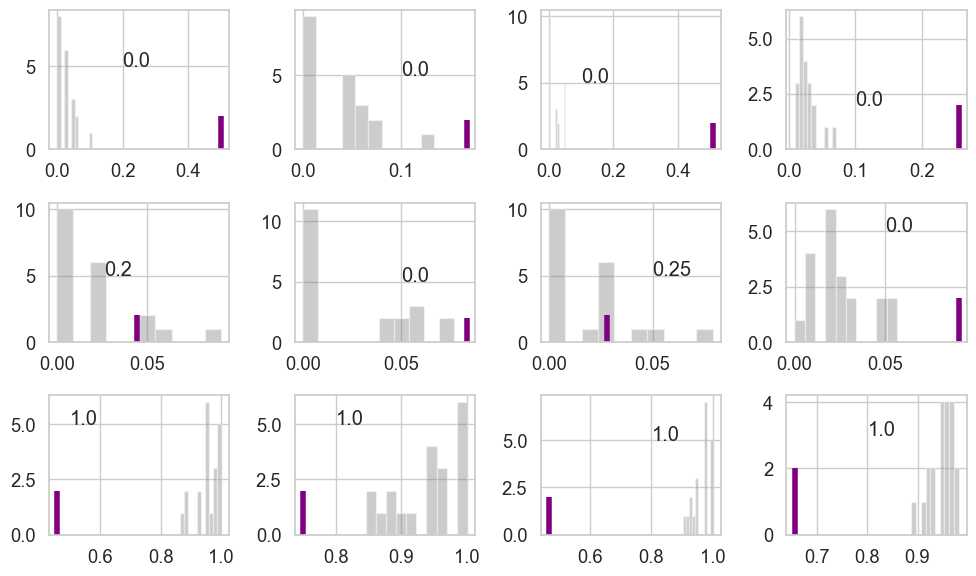

In [133]:
sns.set(style='whitegrid',font_scale=1.2)
fig,ax = plt.subplots(3,4,figsize=(10,6))

ax[0][0].hist(perm_cond_probs['H0T0'].values,alpha=0.4,color='grey')
ax[0][0].vlines(x=trueH0T0,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H0T0'].values if i>=trueH0T0]
p_geq_H0T0 =  len(geq) / len(perm_cond_probs['H0T0'].values)
ax[0][0].text(0.2,5,str(p_geq_H0T0))

ax[0][1].hist(perm_cond_probs['H0T1'].values,alpha=0.4,color='grey')
ax[0][1].vlines(x=trueH0T1,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H0T1'].values if i>=trueH0T1]
p_geq_H0T1 =  len(geq) / len(perm_cond_probs['H0T1'].values)
ax[0][1].text(0.1,5,str(p_geq_H0T1))

ax[0][2].hist(perm_cond_probs['H0T2'].values,alpha=0.4,color='grey')
ax[0][2].vlines(x=trueH0T2,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H0T2'].values if i>=trueH0T2]
p_geq_H0T2 =  len(geq) / len(perm_cond_probs['H0T2'].values)
ax[0][2].text(0.1,5,str(p_geq_H0T2))

ax[0][3].hist(perm_cond_probs['H0T3'].values,alpha=0.4,color='grey')
ax[0][3].vlines(x=trueH0T3,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H0T3'].values if i>=trueH0T3]
p_geq_H0T3 =  len(geq) / len(perm_cond_probs['H0T3'].values)
ax[0][3].text(0.1,2,str(p_geq_H0T3))

ax[1][0].hist(perm_cond_probs['H1T0'].values,alpha=0.4,color='grey')
ax[1][0].vlines(x=trueH1T0,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H1T0'].values if i>=trueH1T0]
p_geq_H1T0 =  len(geq) / len(perm_cond_probs['H1T0'].values)
ax[1][0].text(0.026,5,str(p_geq_H1T0))

ax[1][1].hist(perm_cond_probs['H1T1'].values,alpha=0.4,color='grey')
ax[1][1].vlines(x=trueH1T1,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H1T1'].values if i>=trueH1T1]
p_geq_H1T1 =  len(geq) / len(perm_cond_probs['H1T1'].values)
ax[1][1].text(0.05,5,str(p_geq_H1T1))

ax[1][2].hist(perm_cond_probs['H1T2'].values,alpha=0.4,color='grey')
ax[1][2].vlines(x=trueH1T2,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H1T2'].values if i>=trueH1T2]
p_geq_H1T2 =  len(geq) / len(perm_cond_probs['H1T2'].values)
ax[1][2].text(0.05,5,str(p_geq_H1T2))

ax[1][3].hist(perm_cond_probs['H1T3'].values,alpha=0.4,color='grey')
ax[1][3].vlines(x=trueH1T3,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H1T3'].values if i>=trueH1T3]
p_geq_H1T3 =  len(geq) / len(perm_cond_probs['H1T3'].values)
ax[1][3].text(0.05,5,str(p_geq_H1T3))

ax[2][0].hist(perm_cond_probs['H2T0'].values,alpha=0.4,color='grey')
ax[2][0].vlines(x=trueH2T0,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H2T0'].values if i>=trueH2T0]
p_geq_H2T0 =  len(geq) / len(perm_cond_probs['H2T0'].values)
ax[2][0].text(0.5,5,str(p_geq_H2T0))

ax[2][1].hist(perm_cond_probs['H2T1'].values,alpha=0.4,color='grey')
ax[2][1].vlines(x=trueH2T1,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H2T1'].values if i>=trueH2T1]
p_geq_H2T1 =  len(geq) / len(perm_cond_probs['H2T1'].values)
ax[2][1].text(0.8,5,str(p_geq_H2T1))

ax[2][2].hist(perm_cond_probs['H2T2'].values,alpha=0.4,color='grey')
ax[2][2].vlines(x=trueH2T2,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H2T2'].values if i>=trueH2T2]
p_geq_H2T2 =  len(geq) / len(perm_cond_probs['H2T2'].values)
ax[2][2].text(0.8,5,str(p_geq_H2T2))

ax[2][3].hist(perm_cond_probs['H2T3'].values,alpha=0.4,color='grey')
ax[2][3].vlines(x=trueH2T3,ymin=0,ymax=2,color='purple',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_cond_probs['H2T3'].values if i>=trueH2T3]
p_geq_H2T3 =  len(geq) / len(perm_cond_probs['H2T3'].values)
ax[2][3].text(0.8,3,str(p_geq_H2T3))



fig.tight_layout()

figpath = 'figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)

fig.savefig(os.path.join(figpath,'perm_condprobs_highgamma_odorsamp.pdf'))

#### rinse and repeat for the joint probabilities,
You'll use the same permuted datasets here!

In [143]:
perm_joint_probs = []
for perm in npermlist: 
    
    theta_clust0_spktrns = theta_clust0_perms[theta_clust0_perms['perm']==perm]['spktrns'].values
    theta_clust1_spktrns = theta_clust1_perms[theta_clust1_perms['perm']==perm]['spktrns'].values
    theta_clust2_spktrns = theta_clust2_perms[theta_clust2_perms['perm']==perm]['spktrns'].values
    theta_clust3_spktrns = theta_clust3_perms[theta_clust3_perms['perm']==perm]['spktrns'].values
    
    lowgamma_clust0_spktrns = lowgamma_clust0_perms[lowgamma_clust0_perms['perm']==perm]['spktrns'].values
    lowgamma_clust1_spktrns = lowgamma_clust1_perms[lowgamma_clust1_perms['perm']==perm]['spktrns'].values
    lowgamma_clust2_spktrns = lowgamma_clust2_perms[lowgamma_clust2_perms['perm']==perm]['spktrns'].values
    lowgamma_clust3_spktrns = lowgamma_clust3_perms[lowgamma_clust3_perms['perm']==perm]['spktrns'].values
    
    highgamma_clust0_spktrns = highgamma_clust0_perms[highgamma_clust0_perms['perm']==perm]['spktrns'].values
    highgamma_clust1_spktrns = highgamma_clust1_perms[highgamma_clust1_perms['perm']==perm]['spktrns'].values
    highgamma_clust2_spktrns = highgamma_clust2_perms[highgamma_clust2_perms['perm']==perm]['spktrns'].values
    
    
    H0L0 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust0_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust0_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust0_spktrns)))
    H0L1 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust1_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust1_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust1_spktrns)))
    H0L2 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust2_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust2_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust2_spktrns)))
    H0L3 = len(set(highgamma_clust0_spktrns) & set(lowgamma_clust3_spktrns)) / ((len(highgamma_clust0_spktrns) + len(lowgamma_clust3_spktrns)) - len(set(highgamma_clust0_spktrns) & set(lowgamma_clust3_spktrns)))

    H1L0 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust0_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust0_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust0_spktrns)))
    H1L1 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust1_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust1_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust1_spktrns)))
    H1L2 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust2_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust2_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust2_spktrns)))
    H1L3 = len(set(highgamma_clust1_spktrns) & set(lowgamma_clust3_spktrns)) / ((len(highgamma_clust1_spktrns) + len(lowgamma_clust3_spktrns)) - len(set(highgamma_clust1_spktrns) & set(lowgamma_clust3_spktrns)))

    H2L0 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust0_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust0_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust0_spktrns)))
    H2L1 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust1_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust1_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust1_spktrns)))
    H2L2 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust2_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust2_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust2_spktrns)))
    H2L3 = len(set(highgamma_clust2_spktrns) & set(lowgamma_clust3_spktrns)) / ((len(highgamma_clust2_spktrns) + len(lowgamma_clust3_spktrns)) - len(set(highgamma_clust2_spktrns) & set(lowgamma_clust3_spktrns)))


    perm_joint_probs.append(pd.DataFrame({'perm': [perm],
                                         'H0L0': [H0L0],
                                         'H0L1': [H0L1],
                                         'H0L2': [H0L2],
                                         'H0L3': [H0L3],
                                         'H1L0': [H1L0],
                                         'H1L1': [H1L1],
                                         'H1L2': [H1L2],
                                         'H1L3': [H1L3],
                                         'H2L0': [H2L0],
                                         'H2L1': [H2L1],
                                         'H2L2': [H2L2],
                                         'H2L3': [H2L3]
                                        }))
    
perm_joint_probs = pd.concat(perm_joint_probs)



You can take a look at what the shuffled data joint probability heatmaps would look like: 

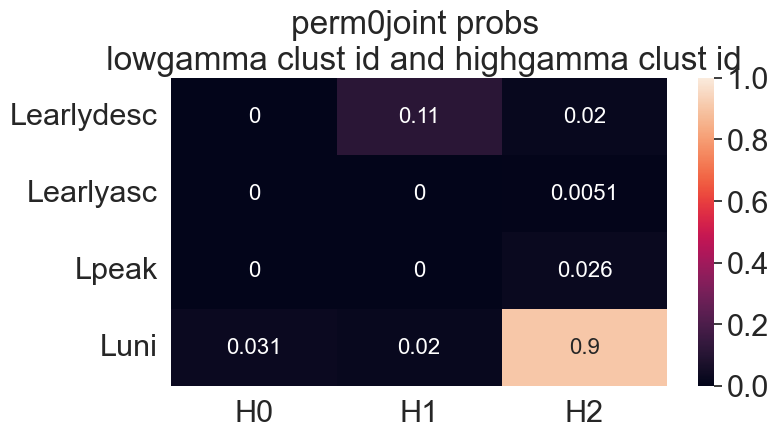

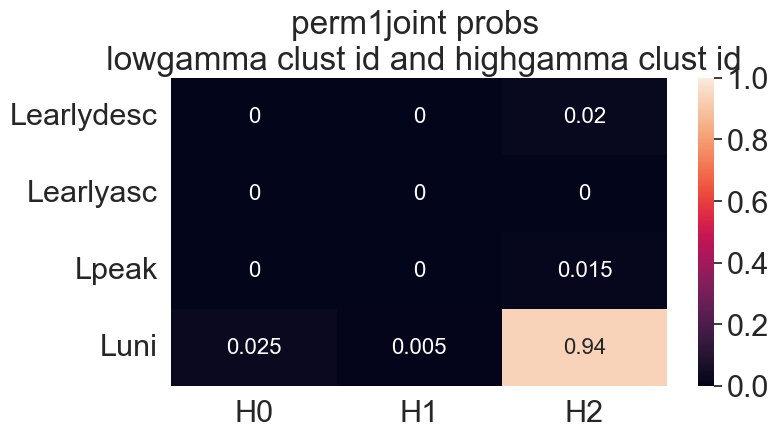

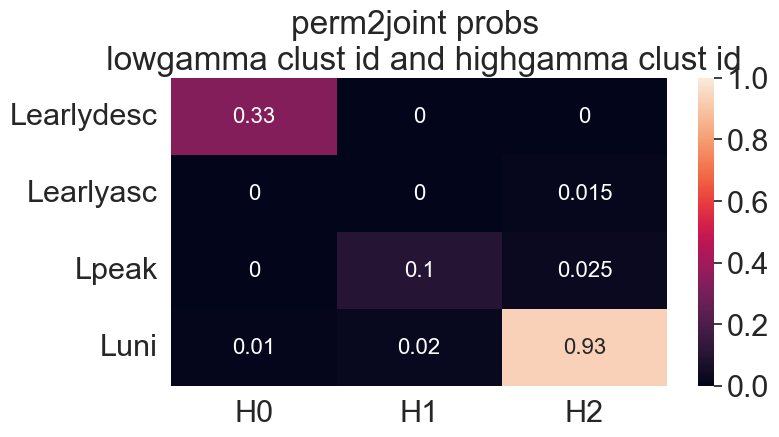

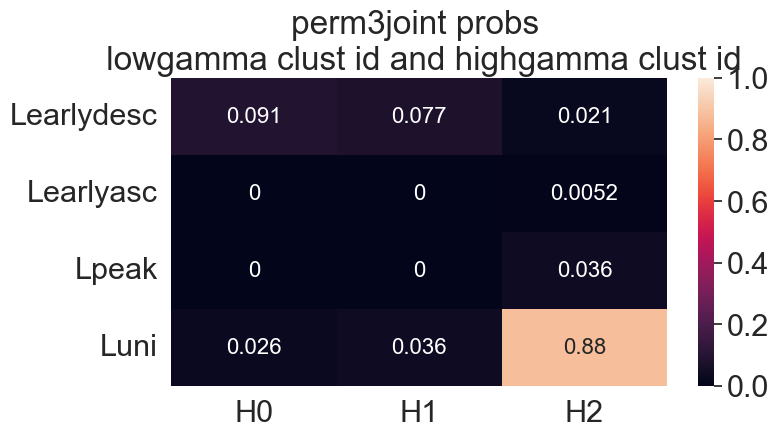

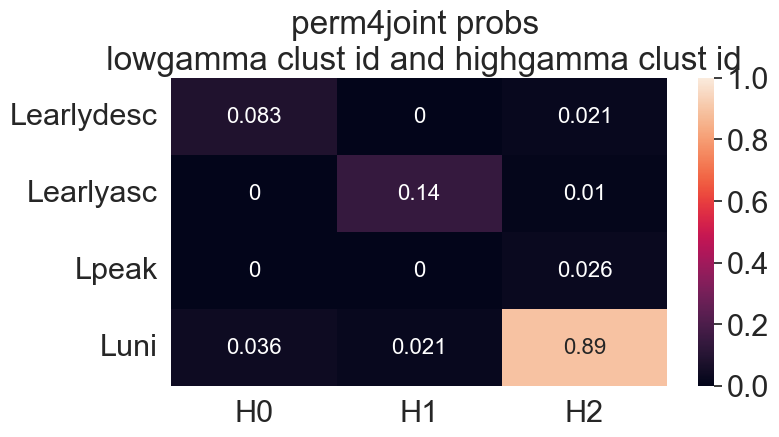

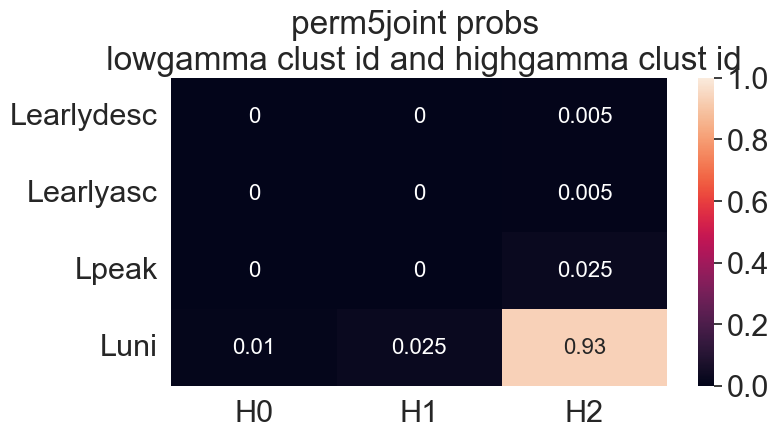

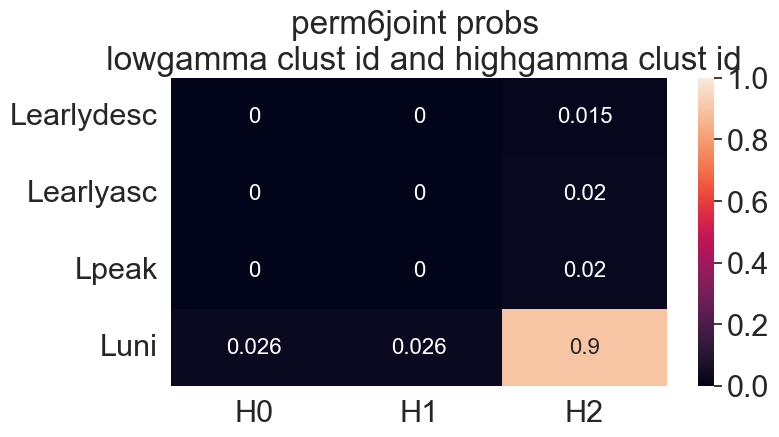

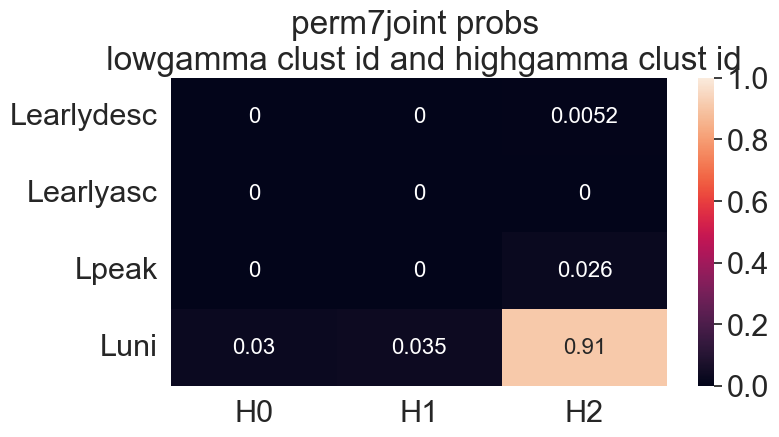

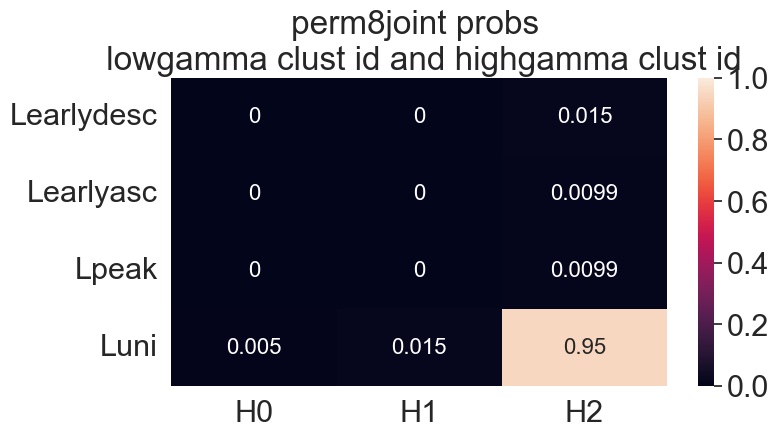

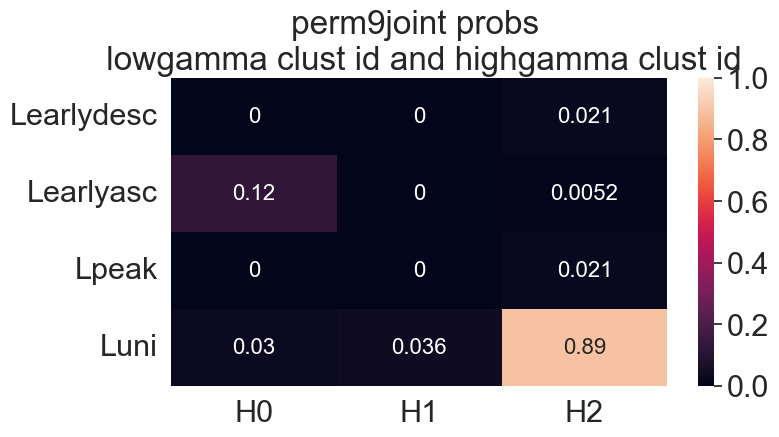

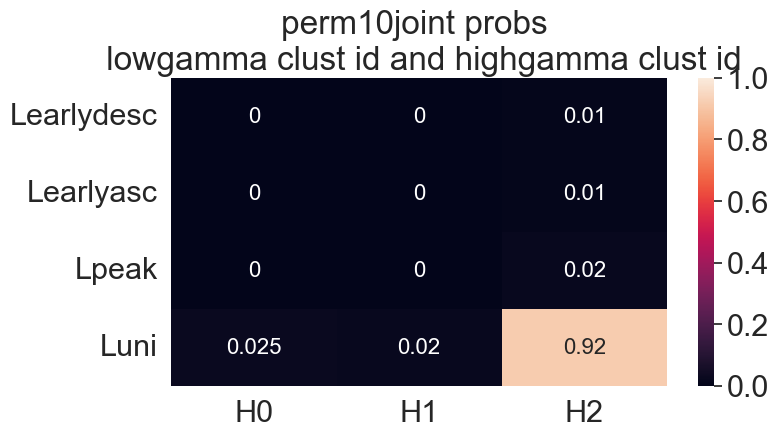

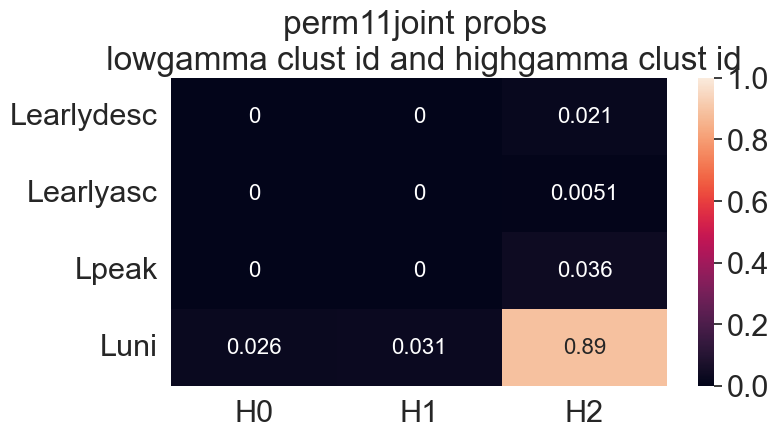

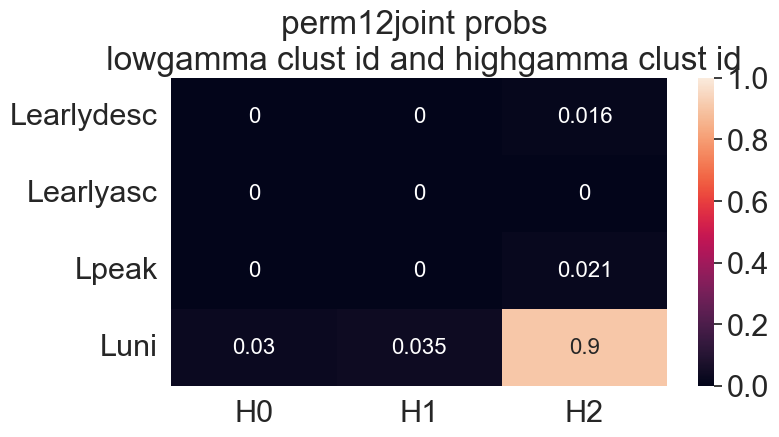

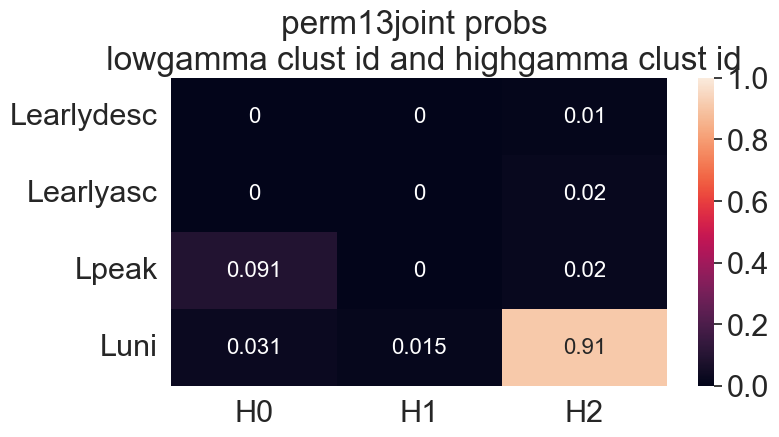

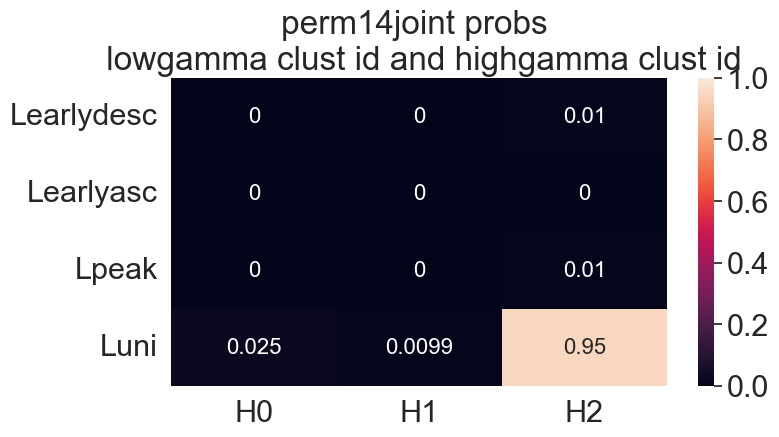

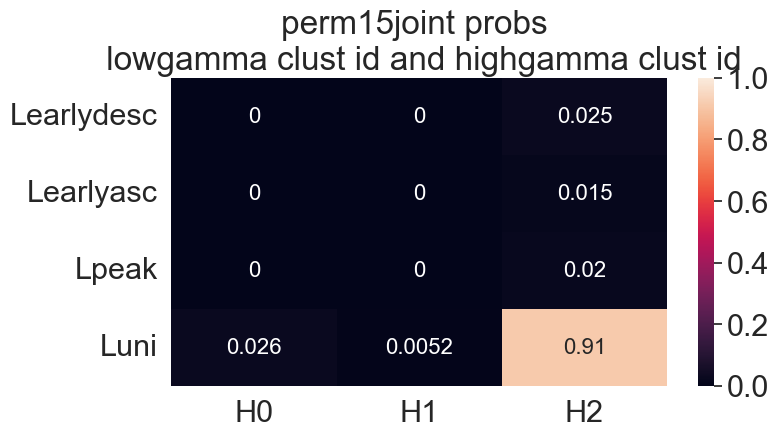

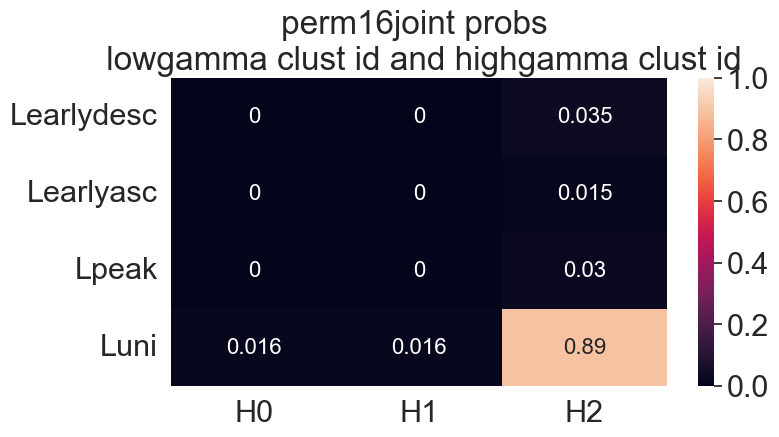

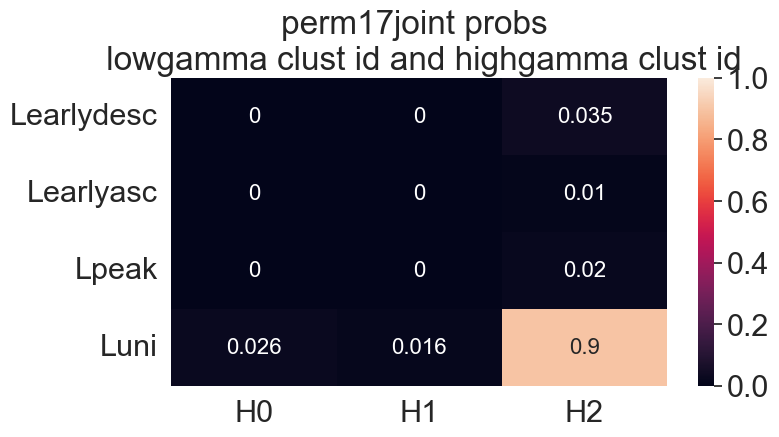

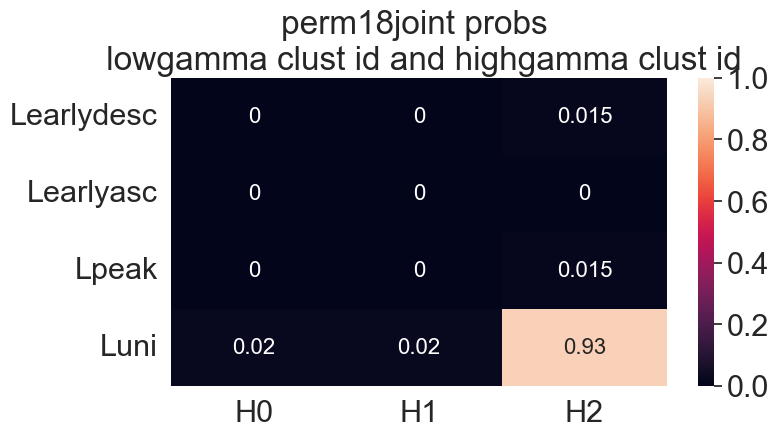

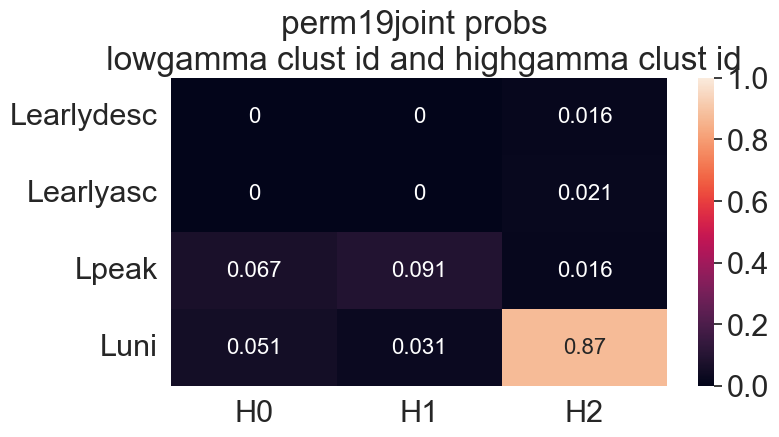

In [144]:
for perm in npermlist: 
    
    subperm = perm_joint_probs[perm_joint_probs['perm']==perm]
    
    H0L0 = subperm['H0L0'].values[0]
    H0L1 = subperm['H0L1'].values[0]
    H0L2 = subperm['H0L2'].values[0]
    H0L3 = subperm['H0L3'].values[0]
    
    H1L0 = subperm['H1L0'].values[0]
    H1L1 = subperm['H1L1'].values[0]
    H1L2 = subperm['H1L2'].values[0]
    H1L3 = subperm['H1L3'].values[0]

    H2L0 = subperm['H2L0'].values[0]
    H2L1 = subperm['H2L1'].values[0]
    H2L2 = subperm['H2L2'].values[0]
    H2L3 = subperm['H2L3'].values[0]
    
    
    HandL = {'H0': [H0L0,H0L1,H0L2,H0L3],
             'H1': [H1L0,H1L1,H1L2,H1L3],
             'H2': [H2L0,H2L1,H2L2,H2L3]
              }
    HandL_df = pd.DataFrame(HandL)

    L = pd.Series(['Learlydesc','Learlyasc','Lpeak','Luni'])
    HandL_df = HandL_df.set_index(L)
    
    
    sns.set(font_scale=2)
    fig,ax = plt.subplots(figsize=(8,4))
    g = sns.heatmap(data=HandL_df,
                        vmin=0,
                        vmax=1,
                        annot=True,
                        annot_kws={"size": 16},
                        ax=ax
                       ).set_title('perm'+str(perm)+'joint probs \n lowgamma clust id and highgamma clust id')

### Supplementary Figure 2C

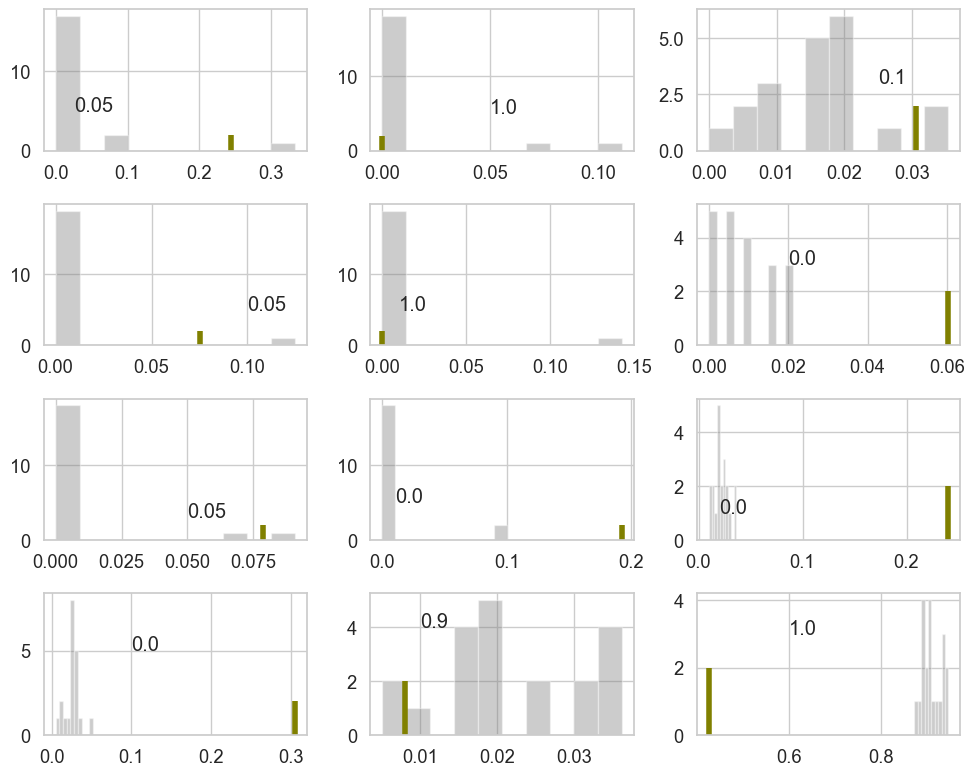

In [146]:
sns.set(style='whitegrid',font_scale=1.2)
fig,ax = plt.subplots(4,3,figsize=(10,8))

ax[0][0].hist(perm_joint_probs['H0L0'].values,alpha=0.4,color='grey')
ax[0][0].vlines(x=trueH0L0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H0L0'].values if i>=trueH0L0]
p_geq_H0L0 =  len(geq) / len(perm_joint_probs['H0L0'].values)
ax[0][0].text(0.025,5,str(p_geq_H0L0))

ax[1][0].hist(perm_joint_probs['H0L1'].values,alpha=0.4,color='grey')
ax[1][0].vlines(x=trueH0L1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H0L1'].values if i>=trueH0L1]
p_geq_H0L1 =  len(geq) / len(perm_joint_probs['H0L1'].values)
ax[1][0].text(0.1,5,str(p_geq_H0L1))

ax[2][0].hist(perm_joint_probs['H0L2'].values,alpha=0.4,color='grey')
ax[2][0].vlines(x=trueH0L2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H0L2'].values if i>=trueH0L2]
p_geq_H0L2 =  len(geq) / len(perm_joint_probs['H0L2'].values)
ax[2][0].text(0.05,3,str(p_geq_H0L2))

ax[3][0].hist(perm_joint_probs['H0L3'].values,alpha=0.4,color='grey')
ax[3][0].vlines(x=trueH0L3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H0L3'].values if i>=trueH0L3]
p_geq_H0L3 =  len(geq) / len(perm_joint_probs['H0L3'].values)
ax[3][0].text(0.1,5,str(p_geq_H0L3))


ax[0][1].hist(perm_joint_probs['H1L0'].values,alpha=0.4,color='grey')
ax[0][1].vlines(x=trueH1L0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H1L0'].values if i>=trueH1L0]
p_geq_H1L0 =  len(geq) / len(perm_joint_probs['H1L0'].values)
ax[0][1].text(0.05,5,str(p_geq_H1L0))

ax[1][1].hist(perm_joint_probs['H1L1'].values,alpha=0.4,color='grey')
ax[1][1].vlines(x=trueH1L1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H1L1'].values if i>=trueH1L1]
p_geq_H1L1 =  len(geq) / len(perm_joint_probs['H1L1'].values)
ax[1][1].text(0.01,5,str(p_geq_H1L1))

ax[2][1].hist(perm_joint_probs['H1L2'].values,alpha=0.4,color='grey')
ax[2][1].vlines(x=trueH1L2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H1L2'].values if i>=trueH1L2]
p_geq_H1L2 =  len(geq) / len(perm_joint_probs['H1L2'].values)
ax[2][1].text(0.01,5,str(p_geq_H1L2))

ax[3][1].hist(perm_joint_probs['H1L3'].values,alpha=0.4,color='grey')
ax[3][1].vlines(x=trueH1L3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H1L3'].values if i>=trueH1L3]
p_geq_H1L3 =  len(geq) / len(perm_joint_probs['H1L3'].values)
ax[3][1].text(0.01,4,str(p_geq_H1L3))

ax[0][2].hist(perm_joint_probs['H2L0'].values,alpha=0.4,color='grey')
ax[0][2].vlines(x=trueH2L0,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H2L0'].values if i>=trueH2L0]
p_geq_H2L0 =  len(geq) / len(perm_joint_probs['H2L0'].values)
ax[0][2].text(0.025,3,str(p_geq_H2L0))

ax[1][2].hist(perm_joint_probs['H2L1'].values,alpha=0.4,color='grey')
ax[1][2].vlines(x=trueH2L1,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H2L1'].values if i>=trueH2L1]
p_geq_H2L1 =  len(geq) / len(perm_joint_probs['H2L1'].values)
ax[1][2].text(0.02,3,str(p_geq_H2L1))

ax[2][2].hist(perm_joint_probs['H2L2'].values,alpha=0.4,color='grey')
ax[2][2].vlines(x=trueH2L2,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H2L2'].values if i>=trueH2L2]
p_geq_H2L2 =  len(geq) / len(perm_joint_probs['H2L2'].values)
ax[2][2].text(0.02,1,str(p_geq_H2L2))

ax[3][2].hist(perm_joint_probs['H2L3'].values,alpha=0.4,color='grey')
ax[3][2].vlines(x=trueH2L3,ymin=0,ymax=2,color='olive',linewidth = 4)

#find all perm values that are greater than or equal to true value
geq = [i for i in perm_joint_probs['H2L3'].values if i>=trueH2L3]
p_geq_H2L3 =  len(geq) / len(perm_joint_probs['H2L3'].values)
ax[3][2].text(0.6,3,str(p_geq_H2L3))



fig.tight_layout()


### example cells below

### Figure 4B (top left)

In [148]:
kde_odor

Unnamed: 0             cell_id  quarter_labels     rhythm  \
3000            0  LH03_D18_TETSPK85k               1      theta   
3001            1  LH03_D18_TETSPK85k               1      theta   
3002            2  LH03_D18_TETSPK85k               1      theta   
3003            3  LH03_D18_TETSPK85k               1      theta   
3004            4  LH03_D18_TETSPK85k               1      theta   
...           ...                 ...             ...        ...   
22995         995  LH08_D28_TETSPK29c               4  highgamma   
22996         996  LH08_D28_TETSPK29c               4  highgamma   
22997         997  LH08_D28_TETSPK29c               4  highgamma   
22998         998  LH08_D28_TETSPK29c               4  highgamma   
22999         999  LH08_D28_TETSPK29c               4  highgamma   

       kde_spikeprob  kde_phaseprob  condition_labels  spktrn_ind_labels  \
3000        0.015214       0.113189                 9                  0   
3001        0.015195       0.113041                 9                  0   
3002        0.015175       0.112895                 9                  0   
3003        0.015156       0.112752                 9                  0   
3004        0.015137       0.112610                 9                  0   
...              ...            ...               ...                ...   
22995       0.002384       0.149850                 6                205   
22996       0.002384       0.149860                 6                205   
22997       0.002384       0.149871                 6                205   
22998       0.002384       0.149882                 6                205   
22999       0.002384       0.149893                 6                205   

       odor_labels  
3000             9  
3001             9  
3002             9  
3003             9  
3004             9  
...            ...  
22995            6  
22996            6  
22997            6  
22998            6  
22999            6  

[618000 rows x 9 columns]

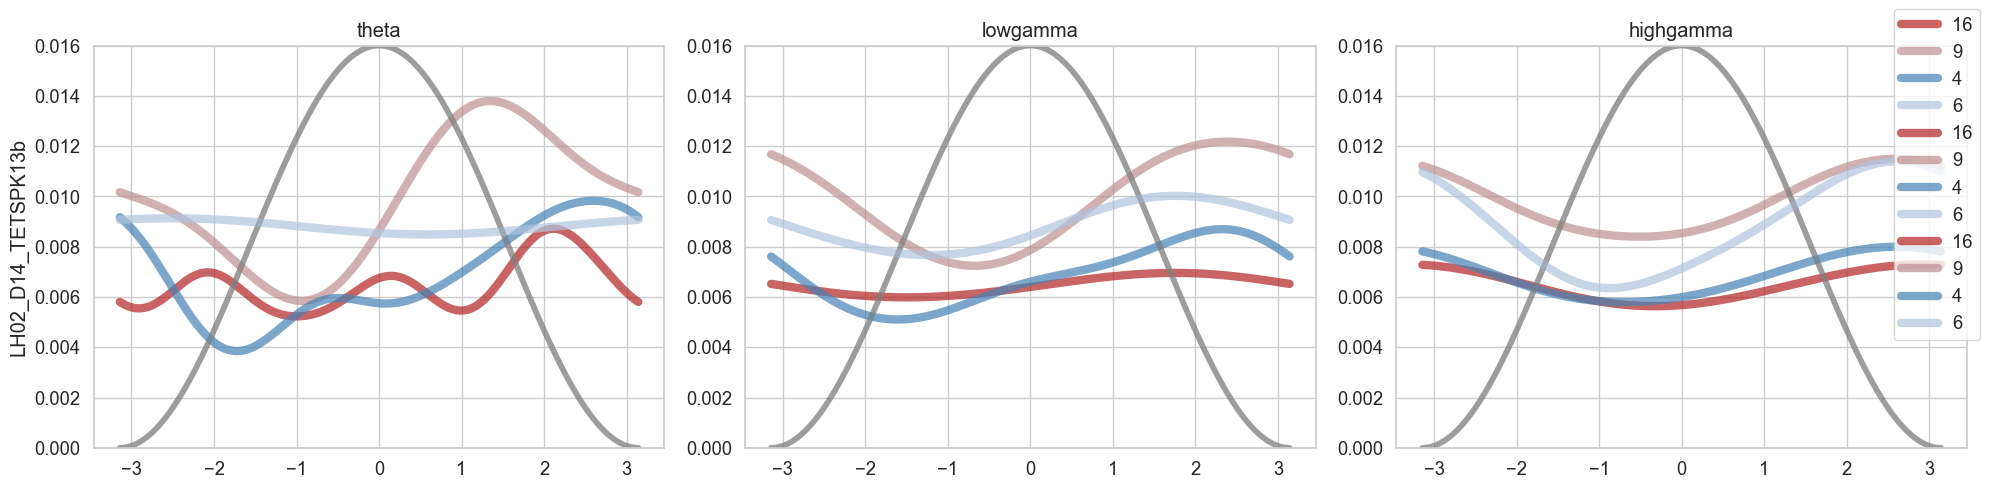

In [185]:
cell_id = 'LH02_D14_TETSPK13b'
ymax = 0.016

fig = example_cells_by_odor(cell_id,kde_odor,cluster_id_df,ymax,0)

fig.savefig('figures_odor/example_cell_'+cell_id+'_coloredby_odor_id_and_side_of_maze.pdf')

### Figure 4B (bottom left)


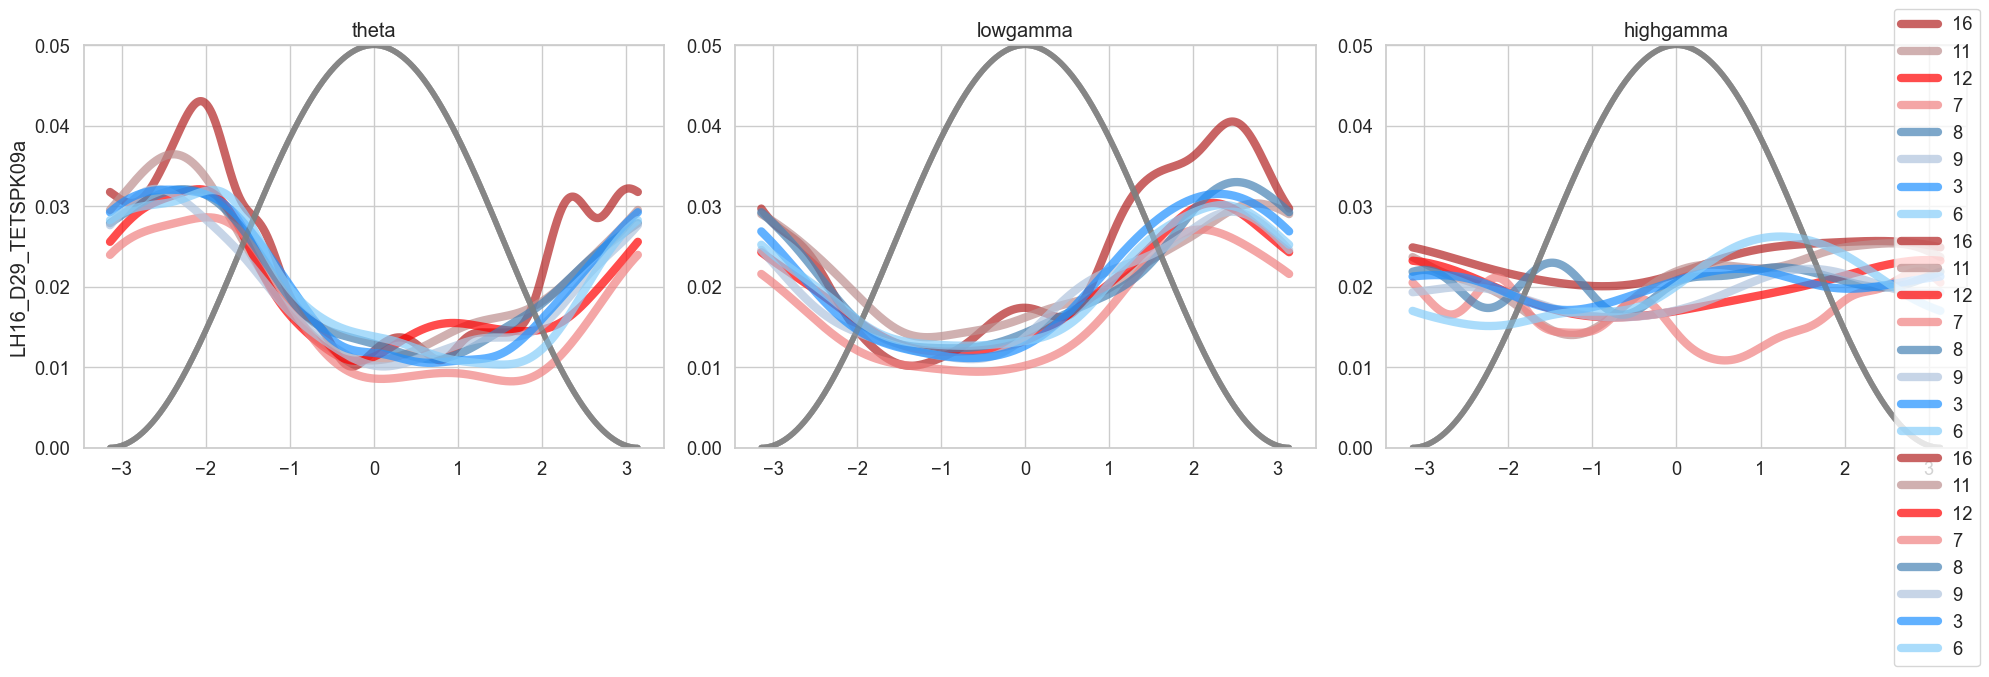

In [184]:
cell_id = 'LH16_D29_TETSPK09a'
ymax = 0.05

fig = example_cells_by_odor(cell_id,kde_odor,cluster_id_df,ymax,0)

fig.savefig('figures_odor/example_cell_'+cell_id+'_coloredby_odor_id_and_side_of_maze.pdf')

### Figure 4D (left)

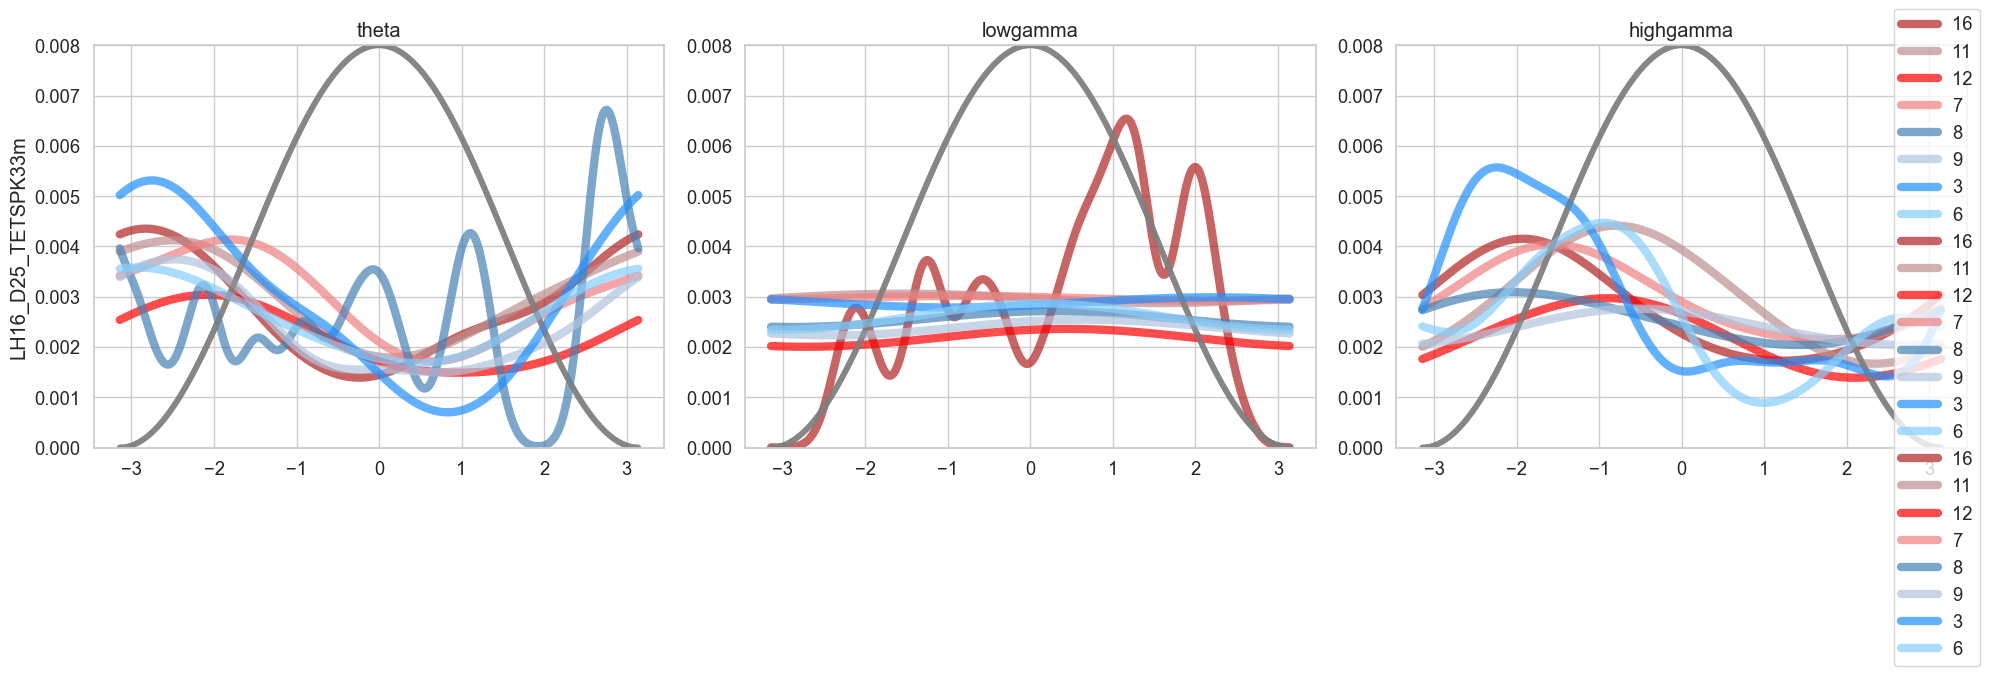

In [183]:
cell_id = 'LH16_D25_TETSPK33m'
ymax = 0.008
fig = example_cells_by_odor(cell_id,kde_odor,cluster_id_df,ymax,0)

fig.savefig('figures_odor/example_cell_'+cell_id+'_coloredby_odor_id_and_side_of_maze.pdf')

### Figure 4E (left)

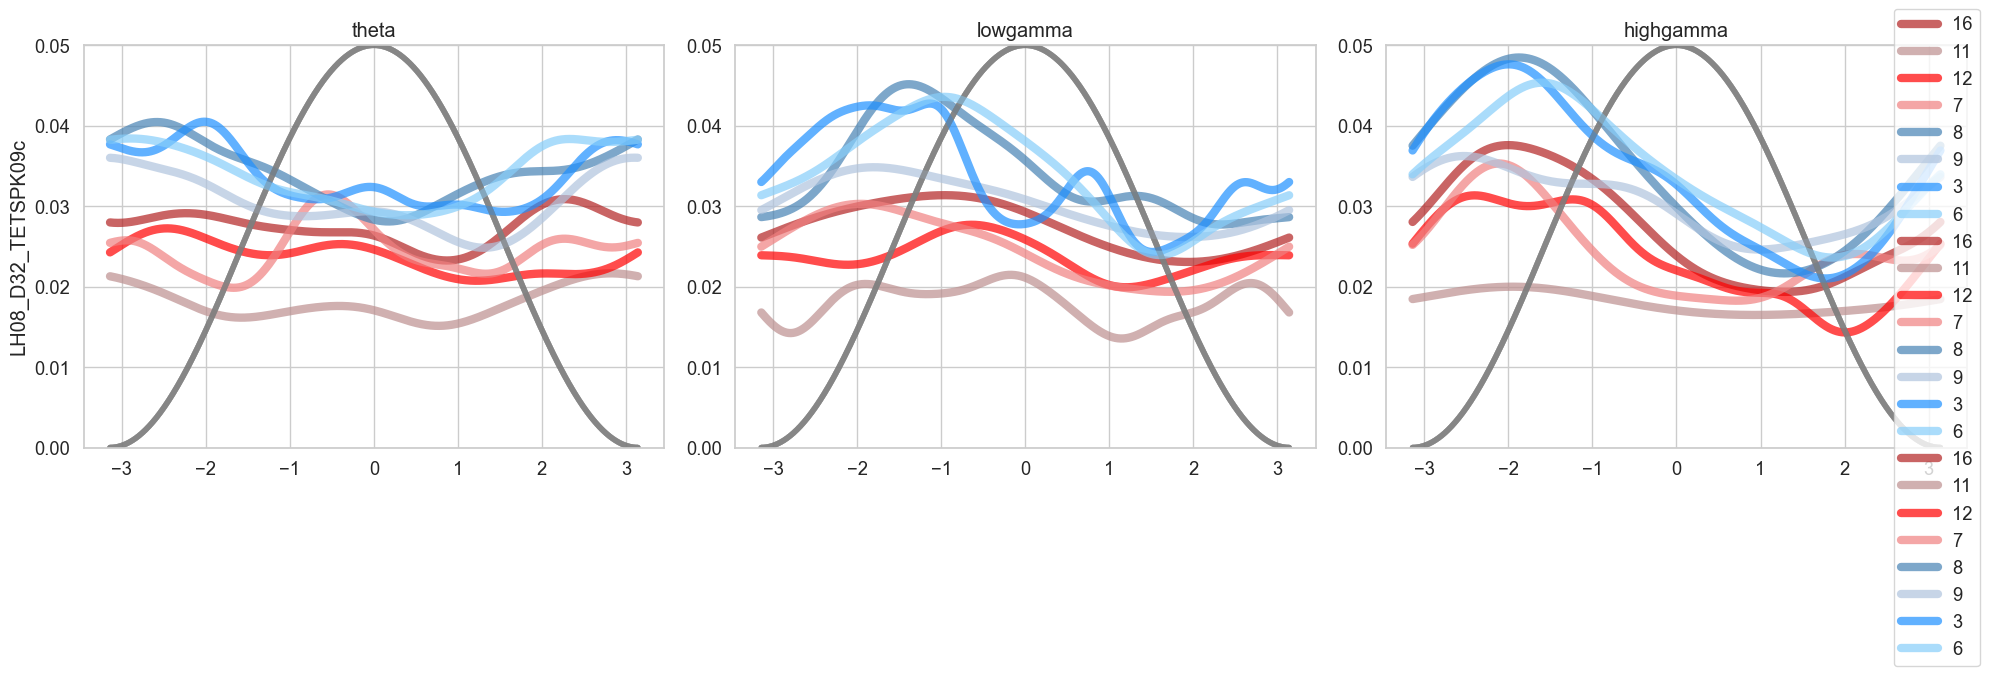

In [182]:
cell_id = 'LH08_D32_TETSPK09c'
ymax = 0.05
fig = example_cells_by_odor(cell_id,kde_odor,cluster_id_df,ymax,0)

fig.savefig('figures_odor/example_cell_'+cell_id+'_coloredby_odor_id_and_side_of_maze.pdf')